In [ ]:
import pandas as pd

# Load your dataset (adjust path/extension)
df = pd.read_csv("sherlock-export-cm-orders_dag-2022-12-11-2025-09-08.csv", sep=";", nrows=100)

# Show the first 5 rows
print(df.head())

# Show the first 10 rows
print(df.head(10))


                                            *bronxml  \
0  treinpadorder_ormas-prd_20221211-000004-418_02...   
1  treinpadorder_ormas-prd_20221211-000224-818_01...   
2  treinpadorder_ormas-prd_20221211-000452-164_03...   
3  treinpadorder_ormas-prd_20221211-000453-245_02...   
4  treinpadorder_ormas-prd_20221211-000456-414_01...   

  *Order_Orderelementen_teller *Order_Orderelementen_aangevraagdedagen_teller  \
0                          1/1                                              1   
1                          1/1                                              1   
2                          1/1                                            1/1   
3                          1/1                                              1   
4                          1/1                                              1   

  *Order_Reactielementen_teller          Tijdstempel  Ordergroep_Groepsid  \
0                             0  2022-12-11 00:00:04                  NaN   
1                     

In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np

# -------------------------
IN_FILE = Path("sample_data.csv")
OUT_FILE = Path("orders_with_backfilled.csv")
SEP = ";"
CHUNK = 200_000
# -------------------------

KEYS = ["Aanvraag_Treinnummer", "Aanvraag_Dagen_Specifiek"]
TYPE_COL = "Procestype"

# pass 1: collect NIEUW orders
nieuw_lookup = {}

for chunk in pd.read_csv(IN_FILE, sep=SEP, chunksize=CHUNK,
                         low_memory=True, encoding="latin1"):
    nieuw_rows = chunk[chunk[TYPE_COL].str.upper().str.strip() == "NIEUW"]
    for _, row in nieuw_rows.iterrows():
        key = tuple(row[k] for k in KEYS)
        if key not in nieuw_lookup:
            nieuw_lookup[key] = row.to_dict()

print(f"[PASS1] Collected {len(nieuw_lookup)} NIEUW orders in lookup")

# pass 2: write backfilled data
first = True
for chunk in pd.read_csv(IN_FILE, sep=SEP, chunksize=CHUNK,
                         low_memory=True, encoding="latin1"):
    out_chunk = []
    for _, row in chunk.iterrows():
        if str(row.get(TYPE_COL, "")).upper().strip() == "WIJZIGING":
            key = tuple(row[k] for k in KEYS)
            nieuw_row = nieuw_lookup.get(key)
            if nieuw_row:
                # fill NA/empty with values from NIEUW
                for col in row.index:
                    if pd.isna(row[col]) or str(row[col]).strip() == "":
                        row[col] = nieuw_row.get(col, row[col])
        out_chunk.append(row)

    out_df = pd.DataFrame(out_chunk)
    out_df.to_csv(OUT_FILE, sep=SEP, mode="w" if first else "a",
                  header=first, index=False, encoding="latin1")
    first = False

print(f"[DONE] Written backfilled data to {OUT_FILE}")  


[PASS1] Collected 19 NIEUW orders in lookup
[DONE] Written backfilled data to orders_with_backfilled.csv


In [14]:
import pandas as pd
from pathlib import Path

# -------------------------
IN_FILE = Path("sherlock-export-cm-orders_dag-2022-12-11-2025-09-08.csv")  # or your latest CSV
SEP = ";"
CHUNK = 200_000
COL = "Aanvraag_Eerste_Locatie_Behandelingen"
# -------------------------

unique_vals = set()

for chunk in pd.read_csv(IN_FILE, sep=SEP, chunksize=CHUNK, encoding="latin1", low_memory=True):
    if COL in chunk.columns:
        vals = chunk[COL].dropna().astype(str).str.strip()
        unique_vals.update(vals.unique())

print(f"Unique values in column {COL}: {len(unique_vals)}")


C:\Users\quint\AppData\Local\Temp\ipykernel_27072\442139763.py:13: DtypeWarning: Columns (7,25,27,29,31,42,56,63,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(IN_FILE, sep=SEP, chunksize=CHUNK, encoding="latin1", low_memory=True):
C:\Users\quint\AppData\Local\Temp\ipykernel_27072\442139763.py:13: DtypeWarning: Columns (42,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(IN_FILE, sep=SEP, chunksize=CHUNK, encoding="latin1", low_memory=True):
C:\Users\quint\AppData\Local\Temp\ipykernel_27072\442139763.py:13: DtypeWarning: Columns (42,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(IN_FILE, sep=SEP, chunksize=CHUNK, encoding="latin1", low_memory=True):
C:\Users\quint\AppData\Local\Temp\ipykernel_27072\442139763.py:13: DtypeWarning: Columns (42,56,63) have mixed types. Specify dtype option on import or set low_m

Unique values in column Aanvraag_Eerste_Locatie_Behandelingen: 3162


C:\Users\quint\AppData\Local\Temp\ipykernel_27072\442139763.py:13: DtypeWarning: Columns (18,42) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(IN_FILE, sep=SEP, chunksize=CHUNK, encoding="latin1", low_memory=True):


In [15]:
print(f"Unique values in column {COL}: {len(unique_vals)}")
print(list(unique_vals)[:10])


Unique values in column Aanvraag_Eerste_Locatie_Behandelingen: 3162
['0045|63591|GEEN_VOORKEUR|63591|Materieel afkomstig van|^', '0045||GEEN_VOORKEUR|41760|Materieel afkomstig van|^', '0022|komt uit de TMA terminal. |GEEN_VOORKEUR||Terminalafhandeling|^', '0045||GEEN_VOORKEUR|41787|Materieel afkomstig van|^', '0045||GEEN_VOORKEUR|43308|Materieel afkomstig van|^0023|Te Emmerich 10min.|GEEN_VOORKEUR||Machinistwissel|^', '0045||GEEN_VOORKEUR|91889|Materieel afkomstig van|^', '0045||GEEN_VOORKEUR|47793|Materieel afkomstig van|^', '0013|Trein uithalen TRS30 Vopak, TRS is besteld van 22.00 - 00.00 uur|GEEN_VOORKEUR||Aankoppelen wagon(s)|^', '0045||GEEN_VOORKEUR|48776|Materieel afkomstig van|^', '0040|losse loc te Em afkomstig van 43521|GEEN_VOORKEUR||Doorkomst|^0045||GEEN_VOORKEUR|49077|Materieel afkomstig van|^']


In [17]:
import pandas as pd
from pathlib import Path
import re

# -------------------------
IN_FILE = Path("sherlock-export-cm-orders_dag-2022-12-11-2025-09-08.csv")  # adjust if needed
SEP = ";"
CHUNK = 200_000
COLS = ["Aanvraag_Laatste_Locatie_Behandelingen",
        "Aanvraag_Eerste_Locatie_Behandelingen"]
# -------------------------

# regex: matches "Opstel" or "Opstellen" in any capitalization
pattern = re.compile(r"\bopstellen?\b", flags=re.IGNORECASE)

counts = {col: 0 for col in COLS}
total_rows = 0

for chunk in pd.read_csv(IN_FILE, sep=SEP, chunksize=CHUNK,
                         encoding="latin1", low_memory=True, usecols=COLS):
    total_rows += len(chunk)
    for col in COLS:
        matches = chunk[col].dropna().astype(str).str.contains(pattern, na=False)
        counts[col] += matches.sum()

print(f"Total rows scanned: {total_rows:,}")
for col, cnt in counts.items():
    print(f"{col}: {cnt:,} rows contain 'Opstel' or 'Opstellen'")


Total rows scanned: 2,020,302
Aanvraag_Laatste_Locatie_Behandelingen: 126,228 rows contain 'Opstel' or 'Opstellen'
Aanvraag_Eerste_Locatie_Behandelingen: 4,699 rows contain 'Opstel' or 'Opstellen'


In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Data cleaning & feature engineering for:
  sherlock-export-cm-orders_dag-2022-12-11-2025-09-08.csv

Pass-1:
  - Normalize headers (strip leading '*', trim)
  - Compute latest Tijdstempel per Ordernummer (fallback to last seen row if timestamp missing)

Pass-2:
  - Keep only rows that are the last for their Ordernummer
  - Filter rows:
      * Drop Procestype == ANNULERING/ANNULERINGEN (case-insensitive, prefix 'ANNUL')
      * Keep Reactie_type in {'AANGEBODEN', 'GEEN_AANBIEDING_MOGELIJK'}
      * Drop completely empty rows
      * Drop rows missing Reactie_type
      * Drop Aanvraagkanaal == 'HANDMATIG'
      * Drop Operator == 'NSR'  (tries 'Operator' first, otherwise 'Aanvraag_vervoerder_verkorting')
      * Drop Aanvraag_Fase_Planproces == 'JAARDIENST'
  - Keep/derive columns:
      * Keep Tijdstempel, Ordernummer, Procestype, Reactie_type
      * Keep request fields listed (see KEEP_COLS_RAW)
      * Derive:
          - stops_count (intermediate stops) from Aanvraag_Routelint
          - route_start, route_end from Aanvraag_Routelint
          - req_halfhour, req_dow, req_week from Aanvraag_Indienmoment
          - earliest_halfhour, latest_halfhour from times; (DoW/week for those = NaN)
          - halfhour_diff = latest_halfhour - earliest_halfhour (negative -> NaN)
          - opstel_flag (binary) from Aanvraag_Laatste_Locatie_Behandelingen (regex on 'opstel*')
      * Finally drop Aanvraag_Routelint and Aanvraag_Laatste_Locatie_Behandelingen
  - Write result to CSV in streaming mode

Assumptions:
  - CSV uses ';' delimiter and 'latin1' encoding (typical NL exports).
  - Time-only fields don't include a date; DoW/week on those are set to NaN.

Output:
  orders_cleaned_modelready_v2.csv
"""

from pathlib import Path
import pandas as pd
import numpy as np
import re
from datetime import datetime

# -------- CONFIG --------
SRC  = Path("sherlock-export-cm-orders_dag-2022-12-11-2025-09-08.csv")
OUT  = Path("orders_cleaned_modelready_v2.csv")
SEP  = ";"
ENC  = "latin1"
CHUNK = 200_000

# Column names (normalized, i.e., without leading '*'):
COL_TIME         = "Tijdstempel"
COL_ORDER        = "Ordernummer"
COL_PROCETYPE    = "Procestype"
COL_REACTIE_TYPE = "Reactie_type"
COL_KANAAL       = "Aanvraagkanaal"
COL_OPERATOR     = "Operator"  # if absent, we fallback to 'Aanvraag_vervoerder_verkorting'
COL_OPERATOR_FALLBACK = "Aanvraag_vervoerder_verkorting"
COL_FASE         = "Aanvraag_Fase_Planproces"

# Request columns to keep
KEEP_COLS_RAW = [
    "Aanvraag_vervoerder_verkorting",
    "Aanvraag_Indienmoment",
    "Aanvraag_Dienstregelingjaar",
    "Aanvraag_Routelint",
    "Aanvraag_Eerste_Locatie_Dienstregelpunt",
    "Aanvraag_Laatste_Locatie_Dienstregelpunt",
    "Aanvraag_Eerste_Locatie_DienstregelpuntSpoor",
    "Aanvraag_Eerste_Locatie_Vroegste_Vertrektijd",
    "Aanvraag_Eerste_Locatie_Laatste_Vertrektijd",
    "Aanvraag_Eerste_Locatie_Behandelingen",
    "Aanvraag_Laatste_Locatie_Behandelingen",
    "Aanvraag_Eerste_Locatie_MaxLengte",
    "Aanvraag_Eerste_Locatie_MaxSnelheid",
    "Aanvraag_Eerste_Locatie_MaxGewicht",
]

# regex for "opstel" / "opstellen"
RE_OPSTEL = re.compile(r"\bopstel\w*\b", flags=re.IGNORECASE)

# ---------- helpers ----------
def clean_cols(cols):
    return [c.lstrip("*").strip() if isinstance(c, str) else c for c in cols]

def to_datetime_series(s: pd.Series):
    return pd.to_datetime(s, errors="coerce", utc=False)

def to_time_halfhour_bucket(s: pd.Series) -> pd.Series:
    """
    Parse time strings like 'HH:MM'/'HH:MM:SS' into half-hour bucket [0..47].
    Non-parsable -> NaN.
    """
    s = s.astype("string").str.strip()
    dt1 = pd.to_datetime(s, format="%H:%M:%S", errors="coerce")
    dt2 = pd.to_datetime(s, format="%H:%M", errors="coerce")
    dt = dt1.fillna(dt2)
    mins = (dt.dt.hour.fillna(0)*60 + dt.dt.minute.fillna(0)).astype("float")
    mins[dt.isna()] = np.nan
    return np.floor_divide(mins, 30).astype("float").where(~np.isnan(mins), np.nan)

def split_routelint(s: pd.Series):
    s = s.astype("string").fillna("")
    parts = s.str.split(r"\s*-\s*", regex=True)
    start = parts.str[0].str.strip().replace("", pd.NA)
    end   = parts.str[-1].str.strip().replace("", pd.NA)
    # intermediate stops (exclude first and last)
    lengths = parts.apply(lambda lst: len(lst) if isinstance(lst, list) else 0)
    inter_cnt = (lengths - 2).clip(lower=0)
    return start, end, inter_cnt

def normalize_upper(s: pd.Series) -> pd.Series:
    return s.astype("string").str.upper().str.strip()

# ---------- sanity ----------
if not SRC.exists():
    raise FileNotFoundError(SRC)

# ---------- PASS 0: header ----------
hdr = pd.read_csv(SRC, sep=SEP, nrows=0, encoding=ENC, low_memory=False)
hdr.columns = clean_cols(hdr.columns)

# columns we will reference (present or not)
present_cols = set(hdr.columns)

# ---------- PASS 1: compute latest Tijdstempel per Ordernummer ----------
print("[PASS-1] Finding latest Tijdstempel per Ordernummer ...")
latest_map_ts  = {}   # Ordernummer -> latest pd.Timestamp
latest_map_row = {}   # Ordernummer -> last seen row counter (fallback)
row_counter = 0

usecols_p1 = [c for c in [COL_ORDER, COL_TIME] if c in present_cols]
if COL_ORDER not in present_cols:
    raise RuntimeError("Ordernummer column not found.")

for chunk in pd.read_csv(SRC, sep=SEP, chunksize=CHUNK, encoding=ENC, low_memory=True, usecols=usecols_p1):
    chunk.columns = clean_cols(chunk.columns)
    # parse timestamps (might be missing)
    ts = to_datetime_series(chunk.get(COL_TIME)) if COL_TIME in chunk.columns else pd.Series(pd.NaT, index=chunk.index)

    for i, row in chunk.iterrows():
        row_counter += 1
        order_id = row.get(COL_ORDER)
        if pd.isna(order_id):
            continue
        cur_ts = ts.get(i, pd.NaT) if COL_TIME in chunk.columns else pd.NaT

        if order_id not in latest_map_ts:
            latest_map_ts[order_id]  = cur_ts
            latest_map_row[order_id] = row_counter
        else:
            prev_ts = latest_map_ts[order_id]
            if pd.notna(cur_ts) and (pd.isna(prev_ts) or cur_ts >= prev_ts):
                latest_map_ts[order_id]  = cur_ts
                latest_map_row[order_id] = row_counter
            elif pd.isna(cur_ts) and pd.isna(prev_ts):
                # both NaT -> keep the last occurrence
                latest_map_row[order_id] = row_counter

print(f"[PASS-1] Unique orders: {len(latest_map_row):,}")

print("[PASS-2] Filtering, engineering, streaming write ...")
if OUT.exists():
    OUT.unlink()
first_write = True

# build combined set of columns to read
read_cols = set([COL_TIME, COL_ORDER, COL_PROCETYPE, COL_REACTIE_TYPE, COL_KANAAL, COL_OPERATOR, COL_OPERATOR_FALLBACK, COL_FASE] + KEEP_COLS_RAW)
read_cols = [c for c in read_cols if c in present_cols]

total_in = total_kept = 0
dropped_annul = dropped_no_reactie = dropped_empty = 0
dropped_handmatig = dropped_nsr = dropped_jaar = 0
dropped_not_last = 0

row_counter2 = 0  # NEW: global row position for pass-2

for chunk in pd.read_csv(SRC, sep=SEP, chunksize=CHUNK, encoding=ENC, low_memory=True, usecols=read_cols):
    chunk.columns = clean_cols(chunk.columns)
    total_in += len(chunk)

    # --- compute per-row keep flag based on global rules from pass-1 ---
    if COL_TIME in chunk.columns:
        ts = to_datetime_series(chunk[COL_TIME])
    else:
        ts = pd.Series(pd.NaT, index=chunk.index)

    orders = chunk[COL_ORDER]
    # map per-row order's global latest timestamp and global last-row position
    latest_ts_for_order  = orders.map(latest_map_ts)
    latest_pos_for_order = orders.map(latest_map_row)

    # Build keep mask
    keep_mask_last = np.zeros(len(chunk), dtype=bool)
    for i in chunk.index:
        row_counter2 += 1
        ord_id = orders.at[i]
        if pd.isna(ord_id):
            # no order id: drop
            continue
        lt_ts = latest_ts_for_order.at[i]
        if pd.notna(lt_ts):
            # keep if this row's timestamp equals the global latest timestamp
            keep_mask_last[i - chunk.index[0]] = (pd.notna(ts.at[i]) and ts.at[i] == lt_ts)
        else:
            # all timestamps for this order are NaT -> keep only the globally last occurrence
            keep_mask_last[i - chunk.index[0]] = (row_counter2 == latest_pos_for_order.at[i])

    # apply keep
    mask_series = pd.Series(keep_mask_last, index=chunk.index)
    dropped_not_last += int((~mask_series).sum())
    chunk = chunk.loc[mask_series]
    if chunk.empty:
        continue

    # 2) drop completely empty rows (within read columns)
    not_all_na = ~chunk.isna().all(axis=1)
    dropped_empty += int((~not_all_na).sum())
    chunk = chunk.loc[not_all_na]
    if chunk.empty:
        continue

    # 3) normalize key filters
    proc = normalize_upper(chunk.get(COL_PROCETYPE)) if COL_PROCETYPE in chunk.columns else pd.Series("", index=chunk.index)
    reactie = normalize_upper(chunk.get(COL_REACTIE_TYPE)) if COL_REACTIE_TYPE in chunk.columns else pd.Series("", index=chunk.index)
    kanaal = normalize_upper(chunk.get(COL_KANAAL)) if COL_KANAAL in chunk.columns else pd.Series("", index=chunk.index)
    fase   = normalize_upper(chunk.get(COL_FASE))   if COL_FASE   in chunk.columns else pd.Series("", index=chunk.index)

    # operator prefer 'Operator', fallback to 'Aanvraag_vervoerder_verkorting'
    if COL_OPERATOR in chunk.columns:
        oper = normalize_upper(chunk[COL_OPERATOR])
    elif COL_OPERATOR_FALLBACK in chunk.columns:
        oper = normalize_upper(chunk[COL_OPERATOR_FALLBACK])
    else:
        oper = pd.Series("", index=chunk.index)

    # 4) filters in order
    # Drop Procestype starting with 'ANNUL' (covers ANNULERING, ANNULERINGEN)
    m_annul = proc.str.startswith("ANNUL", na=False)
    dropped_annul += int(m_annul.sum())
    chunk = chunk.loc[~m_annul]
    if chunk.empty:
        continue

    # Keep only certain Reactie_type
    keep_reactie = reactie.isin(["AANGEBODEN", "GEEN_AANBIEDING_MOGELIJK"])
    dropped_no_reactie += int((~keep_reactie).sum())
    chunk = chunk.loc[keep_reactie]
    if chunk.empty:
        continue

    # Drop Aanvraagkanaal == HANDMATIG
    if COL_KANAAL in chunk.columns:
        m_hand = (kanaal == "HANDMATIG")
        dropped_handmatig += int(m_hand.sum())
        chunk = chunk.loc[~m_hand]
        if chunk.empty:
            continue

    # Drop Operator == NSR
    m_nsr = (oper == "NSR")
    dropped_nsr += int(m_nsr.sum())
    chunk = chunk.loc[~m_nsr]
    if chunk.empty:
        continue

    # Drop Fase == JAARDIENST
    if COL_FASE in chunk.columns:
        m_jaar = (fase == "JAARDIENST")
        dropped_jaar += int(m_jaar.sum())
        chunk = chunk.loc[~m_jaar]
        if chunk.empty:
            continue

    # ---------- feature engineering (unchanged from your version) ----------
    route = chunk.get("Aanvraag_Routelint")
    if route is not None:
        route_start, route_end, stops_count = split_routelint(route)
    else:
        route_start = route_end = pd.Series(pd.NA, index=chunk.index)
        stops_count = pd.Series(np.nan, index=chunk.index)

    req_ts = to_datetime_series(chunk.get("Aanvraag_Indienmoment")) if "Aanvraag_Indienmoment" in chunk.columns else pd.Series(pd.NaT, index=chunk.index)
    req_halfhour = np.floor_divide((req_ts.dt.hour.fillna(0)*60 + req_ts.dt.minute.fillna(0)).astype("int"), 30).astype("Int64")
    req_dow  = req_ts.dt.weekday.astype("Int64")
    req_week = req_ts.dt.isocalendar().week.astype("Int64") if hasattr(req_ts.dt, "isocalendar") else pd.Series(pd.NA, index=chunk.index, dtype="Int64")

    earliest_halfhour = to_time_halfhour_bucket(chunk.get("Aanvraag_Eerste_Locatie_Vroegste_Vertrektijd")) if "Aanvraag_Eerste_Locatie_Vroegste_Vertrektijd" in chunk.columns else pd.Series(np.nan, index=chunk.index)
    latest_halfhour   = to_time_halfhour_bucket(chunk.get("Aanvraag_Eerste_Locatie_Laatste_Vertrektijd"))  if "Aanvraag_Eerste_Locatie_Laatste_Vertrektijd"  in chunk.columns else pd.Series(np.nan, index=chunk.index)
    earliest_dow  = pd.Series(pd.NA, index=chunk.index, dtype="Int64")
    earliest_week = pd.Series(pd.NA, index=chunk.index, dtype="Int64")
    latest_dow    = pd.Series(pd.NA, index=chunk.index, dtype="Int64")
    latest_week   = pd.Series(pd.NA, index=chunk.index, dtype="Int64")

    halfhour_diff = (latest_halfhour - earliest_halfhour).astype("float")
    halfhour_diff[(earliest_halfhour.isna()) | (latest_halfhour.isna())] = np.nan
    halfhour_diff[halfhour_diff < 0] = np.nan

    last_beh = chunk.get("Aanvraag_Laatste_Locatie_Behandelingen")
    if last_beh is not None:
        opstel_flag = last_beh.astype("string").str.contains(RE_OPSTEL, na=False).astype("Int8")
    else:
        opstel_flag = pd.Series(0, index=chunk.index, dtype="Int8")

    keep_base = {
        "Tijdstempel": chunk.get(COL_TIME),
        "Ordernummer": chunk.get(COL_ORDER),
        "Procestype": chunk.get(COL_PROCETYPE),
        "Reactie_type": normalize_upper(chunk.get(COL_REACTIE_TYPE)) if COL_REACTIE_TYPE in chunk.columns else pd.NA,

        "Aanvraag_vervoerder_verkorting": chunk.get("Aanvraag_vervoerder_verkorting"),
        "Aanvraag_Indienmoment": chunk.get("Aanvraag_Indienmoment"),
        "Aanvraag_Dienstregelingjaar": chunk.get("Aanvraag_Dienstregelingjaar"),
        "Aanvraag_Eerste_Locatie_Dienstregelpunt": chunk.get("Aanvraag_Eerste_Locatie_Dienstregelpunt"),
        "Aanvraag_Laatste_Locatie_Dienstregelpunt": chunk.get("Aanvraag_Laatste_Locatie_Dienstregelpunt"),
        "Aanvraag_Eerste_Locatie_DienstregelpuntSpoor": chunk.get("Aanvraag_Eerste_Locatie_DienstregelpuntSpoor"),
        "Aanvraag_Eerste_Locatie_Vroegste_Vertrektijd": chunk.get("Aanvraag_Eerste_Locatie_Vroegste_Vertrektijd"),
        "Aanvraag_Eerste_Locatie_Laatste_Vertrektijd": chunk.get("Aanvraag_Eerste_Locatie_Laatste_Vertrektijd"),
        "Aanvraag_Eerste_Locatie_Behandelingen": chunk.get("Aanvraag_Eerste_Locatie_Behandelingen"),
        "Aanvraag_Eerste_Locatie_MaxLengte": chunk.get("Aanvraag_Eerste_Locatie_MaxLengte"),
        "Aanvraag_Eerste_Locatie_MaxSnelheid": chunk.get("Aanvraag_Eerste_Locatie_MaxSnelheid"),
        "Aanvraag_Eerste_Locatie_MaxGewicht": chunk.get("Aanvraag_Eerste_Locatie_MaxGewicht"),
    }

    df_out = pd.DataFrame(keep_base)
    df_out["route_start"]  = route_start
    df_out["route_end"]    = route_end
    df_out["stops_count"]  = stops_count

    df_out["req_halfhour"] = req_halfhour
    df_out["req_dow"]      = req_dow
    df_out["req_week"]     = req_week

    df_out["earliest_halfhour"] = pd.to_numeric(earliest_halfhour, errors="coerce").astype("float")
    df_out["latest_halfhour"]   = pd.to_numeric(latest_halfhour, errors="coerce").astype("float")
    df_out["earliest_dow"]   = earliest_dow
    df_out["earliest_week"]  = earliest_week
    df_out["latest_dow"]     = latest_dow
    df_out["latest_week"]    = latest_week

    df_out["halfhour_diff"] = halfhour_diff
    df_out["opstel_flag"]   = opstel_flag

    # Drop derived-away columns
    for dc in ["Aanvraag_Laatste_Locatie_Behandelingen", "Aanvraag_Routelint"]:
        if dc in df_out.columns:
            df_out = df_out.drop(columns=[dc])

    df_out.to_csv(OUT, sep=SEP, index=False, mode="w" if first_write else "a",
                  header=first_write, encoding=ENC)
    first_write = False
    total_kept += len(df_out)

print("[DONE]")
print(f"  rows in: {total_in:,}")
print(f"  dropped not last: {dropped_not_last:,}")
print(f"  dropped ANNUL*: {dropped_annul:,}")
print(f"  dropped missing/other Reactie (kept only OFFERED/NO_OFFER_POSSIBLE): {dropped_no_reactie:,}")
print(f"  dropped empty rows: {dropped_empty:,}")
print(f"  dropped HANDMATIG: {dropped_handmatig:,}")
print(f"  dropped NSR: {dropped_nsr:,}")
print(f"  dropped JAARDIENST: {dropped_jaar:,}")
print(f"  rows written: {total_kept:,}")
print(f"Output -> {OUT.resolve()}")


[PASS-1] Finding latest Tijdstempel per Ordernummer ...
[PASS-1] Unique orders: 301,669
[PASS-2] Filtering, engineering, streaming write ...
[DONE]
  rows in: 2,020,302
  dropped not last: 1,661,874
  dropped ANNUL*: 91,995
  dropped missing/other Reactie (kept only OFFERED/NO_OFFER_POSSIBLE): 135,558
  dropped empty rows: 0
  dropped HANDMATIG: 37,029
  dropped NSR: 53,293
  dropped JAARDIENST: 8,774
  rows written: 171,911
Output -> C:\Users\quint\Downloads\orders_cleaned_modelready_v2.csv



[Scan] total rows: 2,020,302
[Scan] Tijdstempel parsed: 2,020,302 (100.0%)
[Tijdstempel] min=2022-12-11 00:00:04  max=2023-12-09 23:58:07
[Reactie_Moment] min=2022-08-11 13:09:11  max=2023-12-09 23:43:56
[Aanvraag_Indienmoment] min=2021-04-09 12:04:36  max=2023-12-09 23:58:07

[Coverage per year]
   year  Tijdstempel  Reactie_Moment  Aanvraag_Indienmoment
0  2021            0               0                    587
1  2022        70666          167952                 145202
2  2023      1949636          803335                1312733
[i] Saved coverage table: C:\Users\quint\Downloads\viz_out\date_coverage_by_year.csv


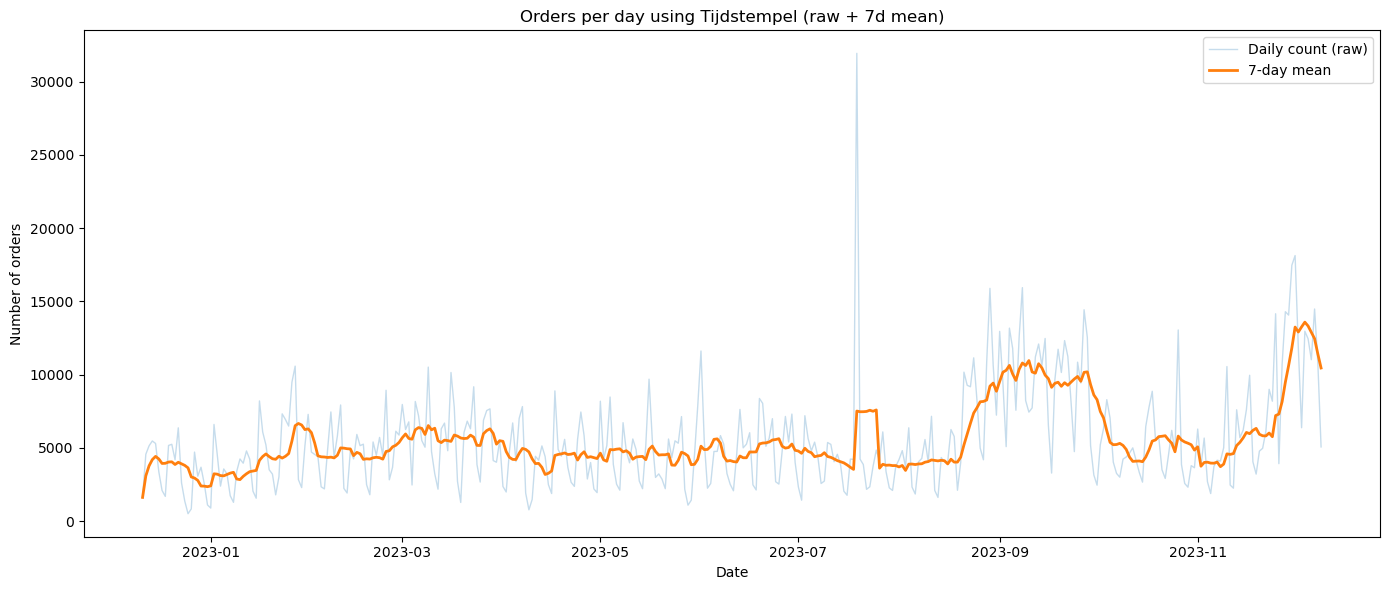

[✓] Plot saved: C:\Users\quint\Downloads\viz_out\orders_per_day_tijdstempel.png


In [24]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Diagnose date coverage and plot orders-per-day from the raw dataset using Tijdstempel.

What it does:
- Streams the CSV in chunks (latin1, ';').
- Normalizes headers (strips leading '*').
- Parses Tijdstempel -> date; counts ALL rows per day (orders), no filtering.
- Also parses Reactie_Moment and Aanvraag_Indienmoment; reports per-year coverage.
- Prints min/max, per-year counts for each timestamp field.
- Saves a sample of unparsable Tijdstempel values for inspection.
- Plots daily total orders (raw + 7d rolling mean).

Outputs:
- ./viz_out/orders_per_day_tijdstempel.png
- ./viz_out/date_coverage_by_year.csv
- ./viz_out/unparsable_tijdstempel_sample.csv
"""

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
SRC   = Path("sherlock-export-cm-orders_dag-2022-12-11-2025-09-08.csv")
SEP   = ";"
ENC   = "latin1"
CHUNK = 200_000

OUTDIR = Path("./viz_out")
OUTDIR.mkdir(parents=True, exist_ok=True)
PLOT  = OUTDIR / "orders_per_day_tijdstempel.png"
COV_CSV = OUTDIR / "date_coverage_by_year.csv"
BAD_SAMPLE_CSV = OUTDIR / "unparsable_tijdstempel_sample.csv"

COL_TS   = "Tijdstempel"
COL_RM   = "Reactie_Moment"
COL_AIM  = "Aanvraag_Indienmoment"
# ----------------------------------------

def clean_cols(cols):
    return [c.lstrip("*").strip() if isinstance(c, str) else c for c in cols]

if not SRC.exists():
    raise FileNotFoundError(SRC)

# Map actual column names
hdr = pd.read_csv(SRC, sep=SEP, nrows=0, encoding=ENC, low_memory=False)
hdr.columns = clean_cols(hdr.columns)
lower = {c.lower(): c for c in hdr.columns}
def actual(name): return lower.get(name.lower())

ts_col  = actual(COL_TS)
rm_col  = actual(COL_RM)
aim_col = actual(COL_AIM)

if ts_col is None:
    raise RuntimeError(f"Column '{COL_TS}' not found. Available: {list(hdr.columns)[:15]} ...")

usecols = [ts_col] + [c for c in [rm_col, aim_col] if c is not None]

# Aggregators
day_counts = {}           # date -> count of orders (from Tijdstempel date)
bad_ts_values = set()     # unique examples of unparsable Tijdstempel
year_counts = { "Tijdstempel": {}, "Reactie_Moment": {}, "Aanvraag_Indienmoment": {} }
minmax = { "Tijdstempel": [None, None], "Reactie_Moment": [None, None], "Aanvraag_Indienmoment": [None, None] }

total_rows = 0
ts_parsed = 0

for ch in pd.read_csv(SRC, sep=SEP, encoding=ENC, chunksize=CHUNK, low_memory=True, usecols=usecols):
    ch.columns = clean_cols(ch.columns)
    total_rows += len(ch)

    # --- Tijdstempel to date ---
    raw_ts = ch[ts_col].astype("string")
    dt_ts = pd.to_datetime(raw_ts, errors="coerce")
    ts_parsed += int(dt_ts.notna().sum())

    # collect examples of unparsable values (limit to keep file small)
    bad_mask = dt_ts.isna() & raw_ts.notna()
    if bad_mask.any():
        # add up to 500 examples
        for v in raw_ts[bad_mask].unique()[:500 - len(bad_ts_values)]:
            bad_ts_values.add(v)
            if len(bad_ts_values) >= 500:
                break

    # daily counts from Tijdstempel
    d = dt_ts.dt.floor("D")
    vc = d.value_counts(dropna=True)
    for day, n in vc.items():
        day_counts[day.date()] = day_counts.get(day.date(), 0) + int(n)

    # min/max & per-year coverage for each field we have
    for label, series in [("Tijdstempel", dt_ts)]:
        if series.notna().any():
            mn, mx = series.min(), series.max()
            if minmax[label][0] is None or mn < minmax[label][0]: minmax[label][0] = mn
            if minmax[label][1] is None or mx > minmax[label][1]: minmax[label][1] = mx
            yrs = series.dt.year.dropna().astype(int).value_counts()
            for y, n in yrs.items():
                year_counts[label][y] = year_counts[label].get(y, 0) + int(n)

    if rm_col is not None:
        dt_rm = pd.to_datetime(ch[rm_col], errors="coerce")
        if dt_rm.notna().any():
            mn, mx = dt_rm.min(), dt_rm.max()
            if minmax["Reactie_Moment"][0] is None or mn < minmax["Reactie_Moment"][0]: minmax["Reactie_Moment"][0] = mn
            if minmax["Reactie_Moment"][1] is None or mx > minmax["Reactie_Moment"][1]: minmax["Reactie_Moment"][1] = mx
            yrs = dt_rm.dt.year.dropna().astype(int).value_counts()
            for y, n in yrs.items():
                year_counts["Reactie_Moment"][y] = year_counts["Reactie_Moment"].get(y, 0) + int(n)

    if aim_col is not None:
        dt_aim = pd.to_datetime(ch[aim_col], errors="coerce")
        if dt_aim.notna().any():
            mn, mx = dt_aim.min(), dt_aim.max()
            if minmax["Aanvraag_Indienmoment"][0] is None or mn < minmax["Aanvraag_Indienmoment"][0]: minmax["Aanvraag_Indienmoment"][0] = mn
            if minmax["Aanvraag_Indienmoment"][1] is None or mx > minmax["Aanvraag_Indienmoment"][1]: minmax["Aanvraag_Indienmoment"][1] = mx
            yrs = dt_aim.dt.year.dropna().astype(int).value_counts()
            for y, n in yrs.items():
                year_counts["Aanvraag_Indienmoment"][y] = year_counts["Aanvraag_Indienmoment"].get(y, 0) + int(n)

# ---- Summaries ----
print(f"\n[Scan] total rows: {total_rows:,}")
print(f"[Scan] Tijdstempel parsed: {ts_parsed:,} ({ts_parsed/total_rows:.1%})")

for label in ["Tijdstempel", "Reactie_Moment", "Aanvraag_Indienmoment"]:
    mn, mx = minmax[label]
    if mn is not None:
        print(f"[{label}] min={mn}  max={mx}")
    else:
        print(f"[{label}] not present or not parseable in this file.")

# Per-year coverage table
years = sorted(set().union(*[set(d.keys()) for d in year_counts.values()]))
cov_rows = []
for y in years:
    cov_rows.append({
        "year": y,
        "Tijdstempel": year_counts["Tijdstempel"].get(y, 0),
        "Reactie_Moment": year_counts["Reactie_Moment"].get(y, 0),
        "Aanvraag_Indienmoment": year_counts["Aanvraag_Indienmoment"].get(y, 0),
    })
cov_df = pd.DataFrame(cov_rows).sort_values("year")
cov_df.to_csv(COV_CSV, index=False)
print(f"\n[Coverage per year]\n{cov_df}")
print(f"[i] Saved coverage table: {COV_CSV.resolve()}")

# Save a small sample of unparsable Tijdstempel values (if any)
if bad_ts_values:
    pd.DataFrame({"unparsable_Tijdstempel": sorted(list(bad_ts_values))}).to_csv(BAD_SAMPLE_CSV, index=False)
    print(f"[!] Saved {len(bad_ts_values)} unparsable Tijdstempel samples: {BAD_SAMPLE_CSV.resolve()}")

# ---- Plot daily orders from Tijdstempel ----
if day_counts:
    day_series = pd.Series(day_counts).sort_index()
    # convert index to pandas datetime index
    day_series.index = pd.to_datetime(day_series.index)

    plt.figure(figsize=(14,6))
    # raw counts
    plt.plot(day_series.index, day_series.values, alpha=0.25, linewidth=1, label="Daily count (raw)")
    # 7d rolling mean
    sm = day_series.rolling(7, min_periods=1).mean()
    plt.plot(day_series.index, sm.values, linewidth=2, label="7-day mean")

    plt.title("Orders per day using Tijdstempel (raw + 7d mean)")
    plt.xlabel("Date")
    plt.ylabel("Number of orders")
    plt.legend()
    plt.tight_layout()
    plt.savefig(PLOT, dpi=150)
    plt.show()
    print(f"[✓] Plot saved: {PLOT.resolve()}")
else:
    print("[!] No daily counts built from Tijdstempel — all values unparsable?")


Processed 0 rows...
Processed 2,000,000 rows...
Finished streaming.


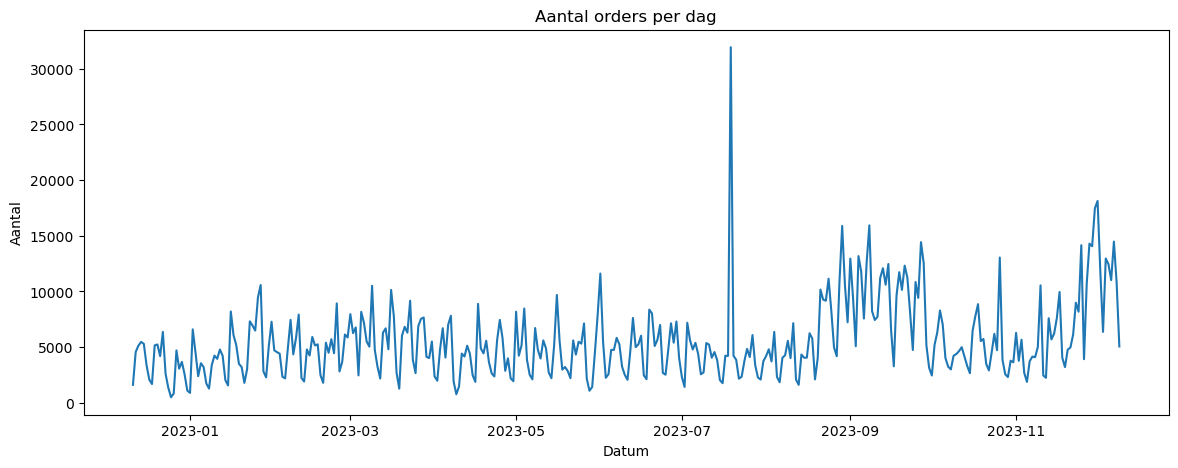

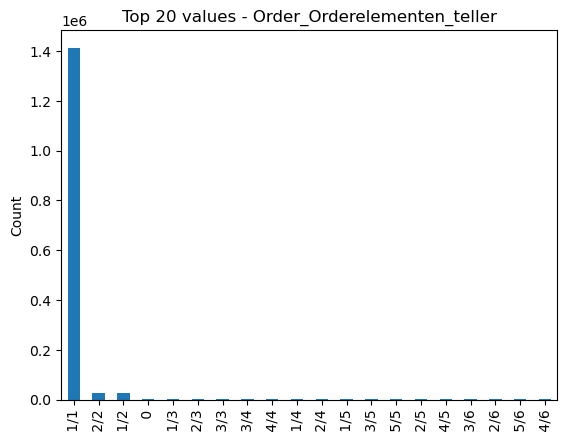

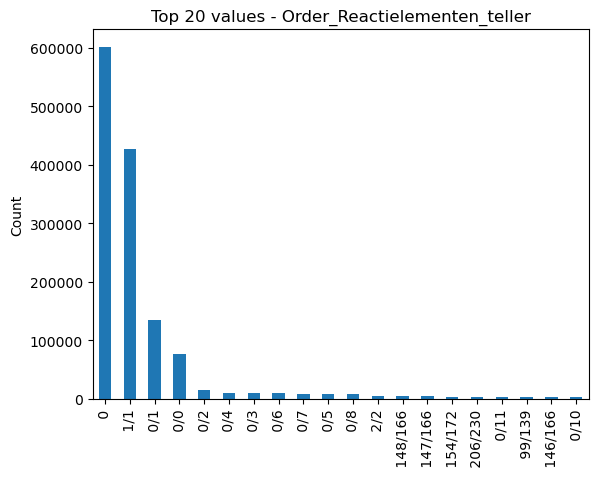

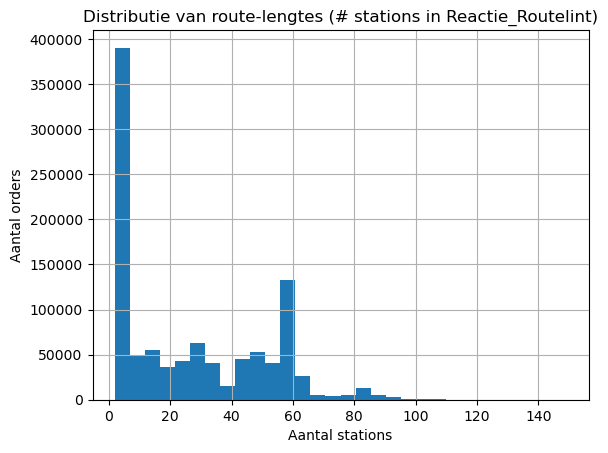

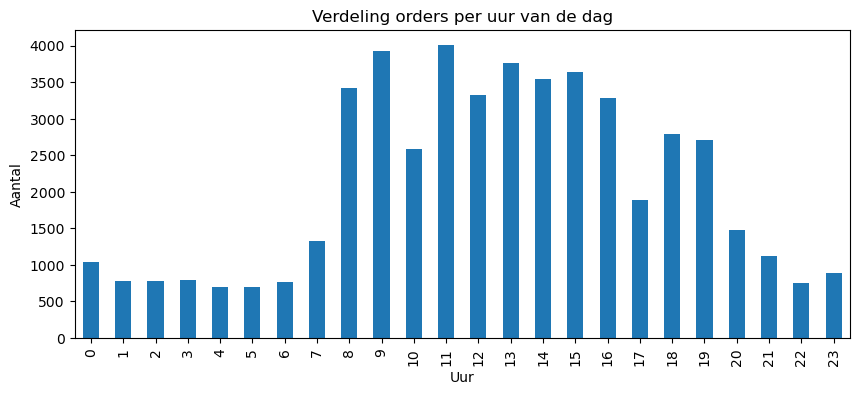

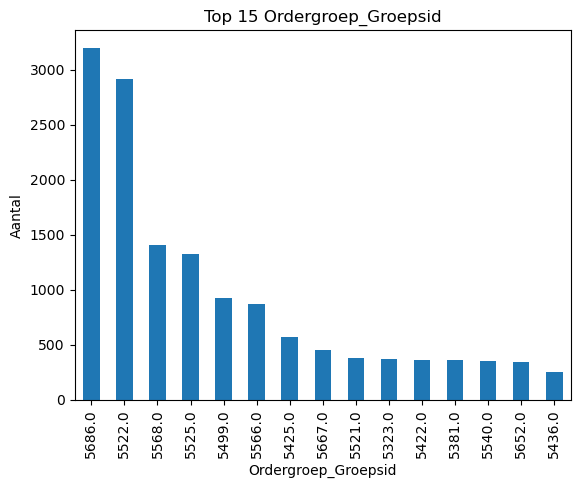

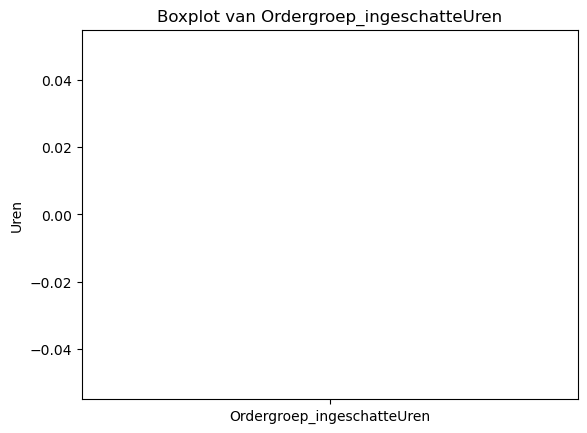

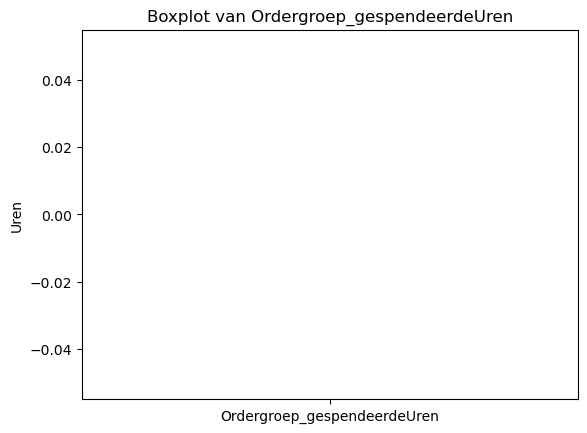

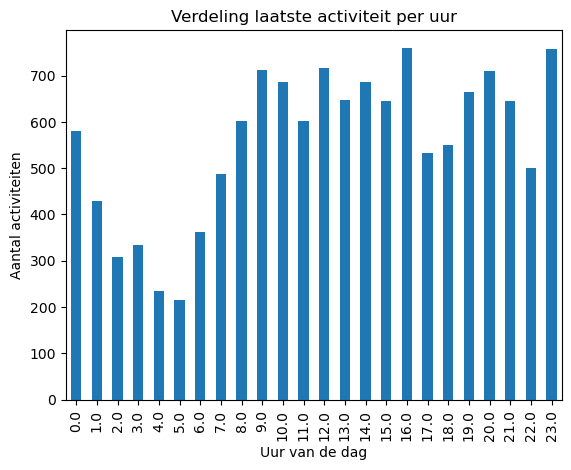

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Settings ---
FILE = "sherlock-export-cm-orders_dag-2022-12-11-2025-09-08.csv"
CHUNKSIZE = 200_000  # process in chunks to avoid memory blow-up

# --- Prepare accumulators ---
daily_counts = {}
ord_counts = {}
react_counts = {}
route_lengths = []

# --- Helper: count updates ---
def update_counter(counter, series):
    for val, cnt in series.value_counts().items():
        counter[val] = counter.get(val, 0) + int(cnt)

# --- Stream file in chunks ---
for i, chunk in enumerate(pd.read_csv(FILE, sep=";", chunksize=CHUNKSIZE, low_memory=False)):
    # Normalise column names
    chunk.columns = [c.strip("*") for c in chunk.columns]

    # Convert Tijdstempel to datetime
    if "Tijdstempel" in chunk:
        chunk["Tijdstempel"] = pd.to_datetime(chunk["Tijdstempel"], errors="coerce")
        daily = chunk["Tijdstempel"].dt.date.value_counts()
        for d, cnt in daily.items():
            daily_counts[d] = daily_counts.get(d, 0) + int(cnt)

    # Count Order_Orderelementen_teller
    if "Order_Orderelementen_teller" in chunk:
        update_counter(ord_counts, chunk["Order_Orderelementen_teller"].astype(str))

    # Count Order_Reactielementen_teller
    if "Order_Reactielementen_teller" in chunk:
        update_counter(react_counts, chunk["Order_Reactielementen_teller"].astype(str))

    # Route length distribution
    if "Reactie_Routelint" in chunk:
        rlens = chunk["Reactie_Routelint"].dropna().astype(str).apply(lambda x: len(x.split(" - ")))
        route_lengths.extend(rlens.tolist())

    if i % 10 == 0:
        print(f"Processed {i*CHUNKSIZE:,} rows...")



# 1. Orders per day
dc = pd.Series(daily_counts).sort_index()
plt.figure(figsize=(14,5))
dc.plot()
plt.title("Aantal orders per dag")
plt.xlabel("Datum")
plt.ylabel("Aantal")
plt.show()

# 2. Top orderelementen teller
pd.Series(ord_counts).sort_values(ascending=False).head(20).plot(kind="bar")
plt.title("Top 20 values - Order_Orderelementen_teller")
plt.ylabel("Count")
plt.show()

# 3. Top reactieelementen teller
pd.Series(react_counts).sort_values(ascending=False).head(20).plot(kind="bar")
plt.title("Top 20 values - Order_Reactielementen_teller")
plt.ylabel("Count")
plt.show()

# 4. Distribution of route lengths
pd.Series(route_lengths).hist(bins=30)
plt.title("Distributie van route-lengtes (# stations in Reactie_Routelint)")
plt.xlabel("Aantal stations")
plt.ylabel("Aantal orders")
plt.show()


# 5. Orders per uur van de dag
if "Tijdstempel" in chunk:
    chunk["Tijdstempel"] = pd.to_datetime(chunk["Tijdstempel"], errors="coerce")
    hours = chunk["Tijdstempel"].dt.hour.dropna()
    plt.figure(figsize=(10,4))
    hours.value_counts().sort_index().plot(kind="bar")
    plt.title("Verdeling orders per uur van de dag")
    plt.xlabel("Uur")
    plt.ylabel("Aantal")
    plt.show()

# 6. Top Ordergroep_Groepsid
if "Ordergroep_Groepsid" in chunk:
    chunk["Ordergroep_Groepsid"].value_counts().head(15).plot(kind="bar")
    plt.title("Top 15 Ordergroep_Groepsid")
    plt.ylabel("Aantal")
    plt.show()

# 7. Boxplots voor urenvelden
for col in ["Ordergroep_ingeschatteUren", "Ordergroep_gespendeerdeUren"]:
    if col in chunk:
        plt.figure()
        chunk[col].dropna().astype(float).plot(kind="box")
        plt.title(f"Boxplot van {col}")
        plt.ylabel("Uren")
        plt.show()

# 8. Activiteitstijdstip distributie
if "Reactie_Laatste_Activiteit_Tijdstip" in chunk:
    tijd = pd.to_datetime(chunk["Reactie_Laatste_Activiteit_Tijdstip"], errors="coerce", format="%H:%M:%S").dt.hour
    tijd.dropna().value_counts().sort_index().plot(kind="bar")
    plt.title("Verdeling laatste activiteit per uur")
    plt.xlabel("Uur van de dag")
    plt.ylabel("Aantal activiteiten")
    plt.show()


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\2531761719.py:55: DtypeWarning: Columns (7,25,27,29,31,42,56,63,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(FILE, sep=SEP, chunksize=CHUNKSIZE, low_memory=True)):


Processed ~0 rows...


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\2531761719.py:55: DtypeWarning: Columns (42,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(FILE, sep=SEP, chunksize=CHUNKSIZE, low_memory=True)):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\2531761719.py:55: DtypeWarning: Columns (42,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(FILE, sep=SEP, chunksize=CHUNKSIZE, low_memory=True)):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\2531761719.py:55: DtypeWarning: Columns (42,56,63) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(FILE, sep=SEP, chunksize=CHUNKSIZE, low_memory=True)):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\2531761719.py:55: DtypeWarning: Columns (26,42) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in 

Processed ~2,000,000 rows...
Finished streaming all figures.


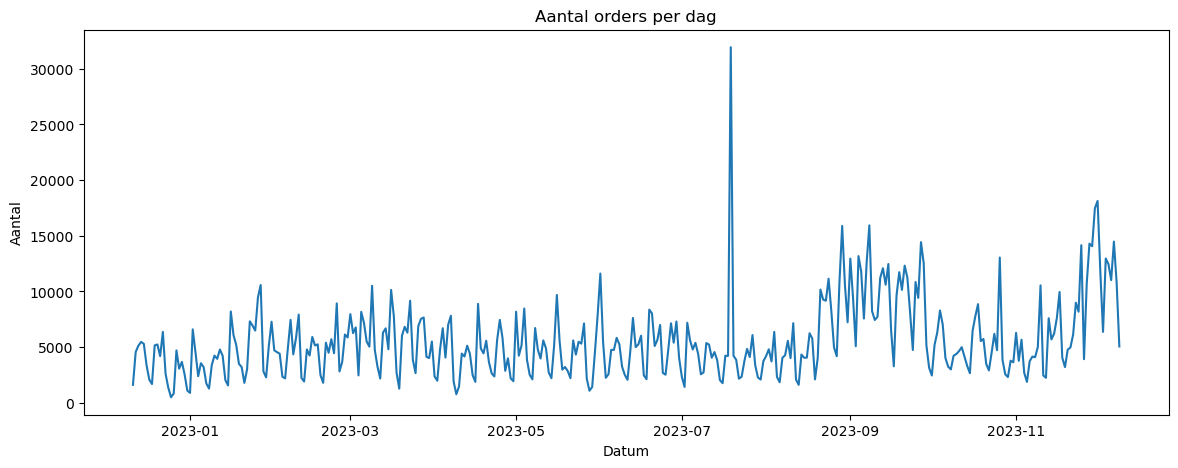

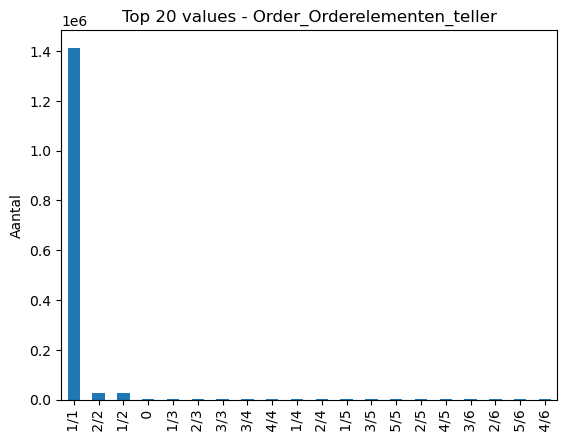

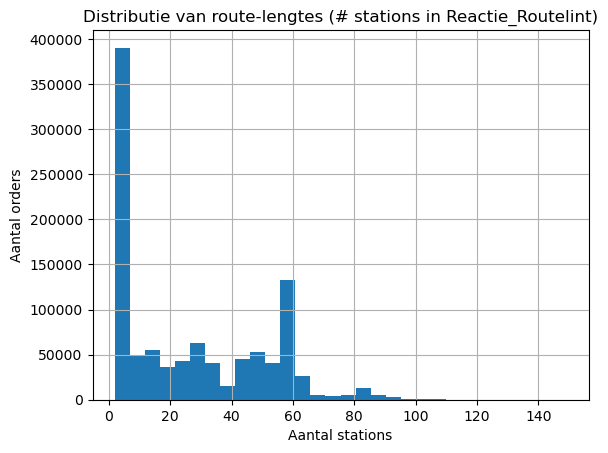

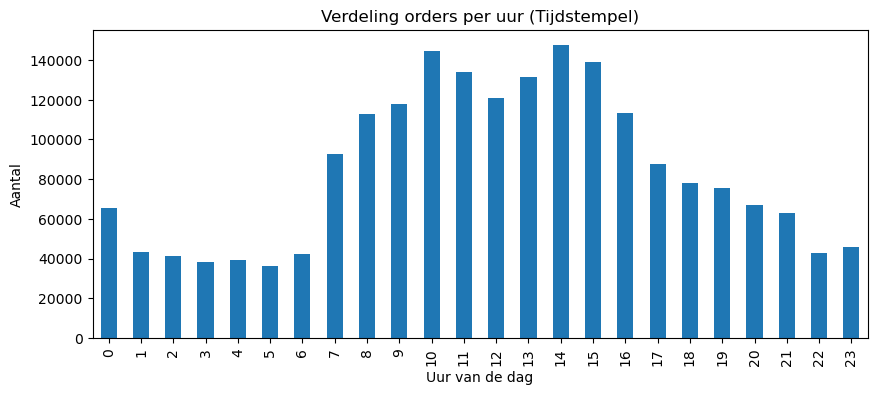

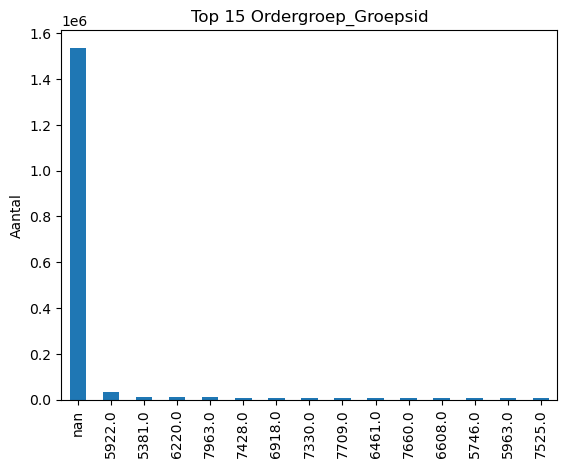

<Figure size 640x480 with 0 Axes>

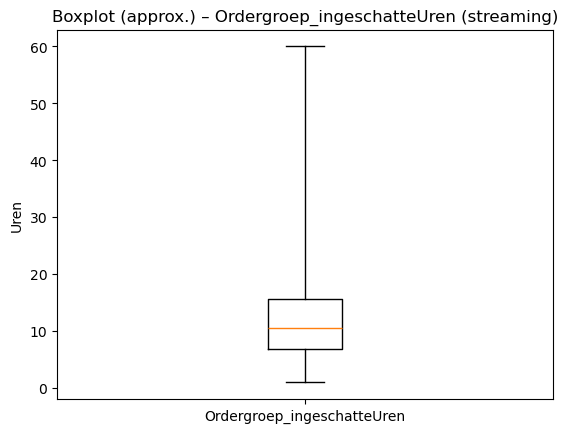

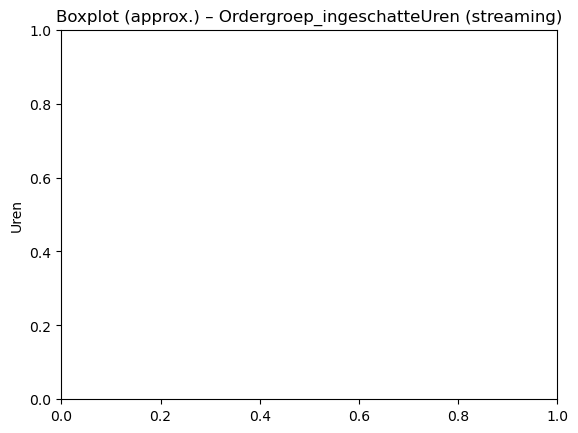

<Figure size 640x480 with 0 Axes>

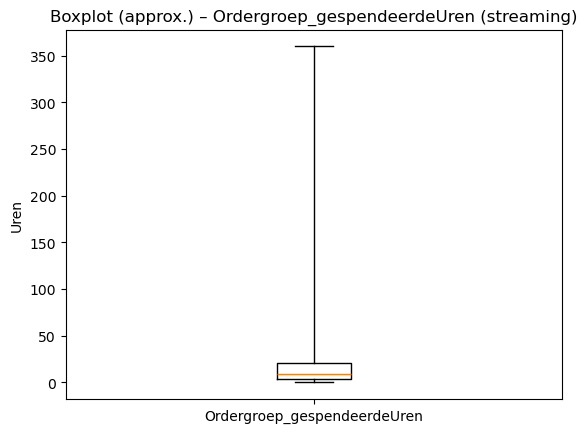

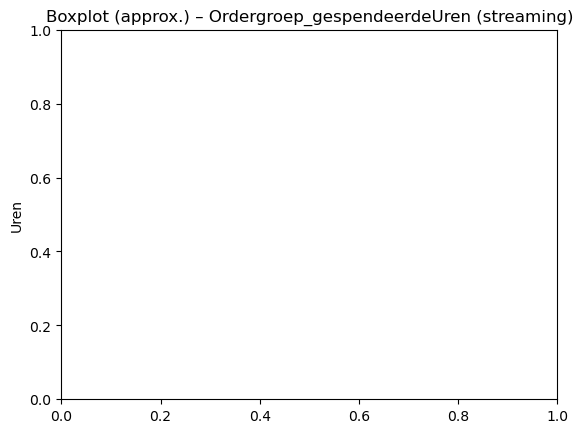

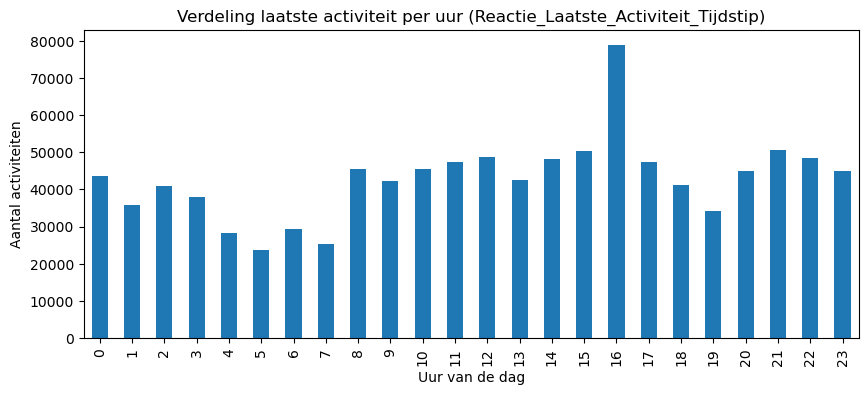

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# --- Settings ---
FILE = "sherlock-export-cm-orders_dag-2022-12-11-2025-09-08.csv"
CHUNKSIZE = 200_000
SEP = ";"  # pas aan indien nodig

# --- Accumulators voor 1–4 (zoals je al had) ---
daily_counts = {}
ord_counts = {}
react_counts = {}
route_lengths = []

def update_counter(counter, series):
    vc = series.value_counts()
    for val, cnt in vc.items():
        counter[val] = counter.get(val, 0) + int(cnt)

# --- Extra accumulators voor 5–8 (ook streaming) ---
# 5) orders per uur (uit Tijdstempel)
hour_counts = Counter()

# 6) top Ordergroep_Groepsid
group_counts = Counter()

# 8) laatste activiteit per uur (uit Reactie_Laatste_Activiteit_Tijdstip)
activity_hour_counts = Counter()

# 7) & 8) boxplots voor urenkolommen via streaming-histogrammen (geen full load)
uren_cols = ["Ordergroep_ingeschatteUren", "Ordergroep_gespendeerdeUren"]

# We nemen een ruime range (0–200 uur) en 1-uur bins; pas aan als nodig
BIN_MIN, BIN_MAX, BIN_STEP = 0.0, 200.0, 1.0
BIN_EDGES = np.arange(BIN_MIN, BIN_MAX + BIN_STEP, BIN_STEP)  # bijv. 0..200
hist_counts_per_col = {c: np.zeros(len(BIN_EDGES) - 1, dtype=np.int64) for c in uren_cols}
global_min = {c: np.inf for c in uren_cols}
global_max = {c: -np.inf for c in uren_cols}
global_count = {c: 0 for c in uren_cols}

def parse_uren_series(s: pd.Series) -> pd.Series:
    # Converteer "12,5" -> "12.5"
    s = s.astype(str).str.replace(",", ".", regex=False)
    return pd.to_numeric(s, errors="coerce")

def add_to_hist(colname: str, values: np.ndarray):
    if values.size == 0:
        return
    hist, _ = np.histogram(values, bins=BIN_EDGES)
    hist_counts_per_col[colname] += hist

# --- Stream file in chunks (één pass voor alles) ---
for i, chunk in enumerate(pd.read_csv(FILE, sep=SEP, chunksize=CHUNKSIZE, low_memory=True)):
    # Normaliseer kolomnamen
    chunk.columns = [c.strip("*") for c in chunk.columns]

    # 1) Aantal orders per dag
    if "Tijdstempel" in chunk:
        ts = pd.to_datetime(chunk["Tijdstempel"], errors="coerce")
        # voor figuur 1:
        daily = ts.dt.date.value_counts()
        for d, cnt in daily.items():
            daily_counts[d] = daily_counts.get(d, 0) + int(cnt)
        # voor figuur 5:
        hrs = ts.dt.hour.dropna().astype(int).value_counts()
        for h, cnt in hrs.items():
            hour_counts[int(h)] += int(cnt)

    # 2) teller orderelementen
    if "Order_Orderelementen_teller" in chunk:
        update_counter(ord_counts, chunk["Order_Orderelementen_teller"].astype(str))

    # 3) teller reactie-elementen
    if "Order_Reactieelementen_teller" in chunk:
        update_counter(react_counts, chunk["Order_Reactieelementen_teller"].astype(str))

    # 4) route-lengtes (aantal stations in routelint)
    if "Reactie_Routelint" in chunk:
        rlens = chunk["Reactie_Routelint"].dropna().astype(str).apply(lambda x: len([p for p in x.split(" - ") if p.strip()]))
        route_lengths.extend(rlens.tolist())

    # 6) groepen
    if "Ordergroep_Groepsid" in chunk:
        # cast naar string, drop lege
        vals = chunk["Ordergroep_Groepsid"].astype(str)
        group_counts.update(vals[vals.str.len() > 0])

    # 7 & 8) uren-kolommen histogrammen en min/max
    for col in uren_cols:
        if col in chunk:
            vals = parse_uren_series(chunk[col]).dropna()
            if len(vals):
                v = vals.to_numpy()
                add_to_hist(col, v)
                global_min[col] = min(global_min[col], float(np.min(v)))
                global_max[col] = max(global_max[col], float(np.max(v)))
                global_count[col] += int(v.size)

    # 8) laatste activiteit per uur
    if "Reactie_Laatste_Activiteit_Tijdstip" in chunk:
        act = pd.to_datetime(chunk["Reactie_Laatste_Activiteit_Tijdstip"], errors="coerce", format="%H:%M:%S")
        ah = act.dt.hour.dropna().astype(int).value_counts()
        for h, cnt in ah.items():
            activity_hour_counts[int(h)] += int(cnt)

    if i % 10 == 0:
        print(f"Processed ~{i*CHUNKSIZE:,} rows...")

print("Finished streaming all figures.")

# -----------------------------
# Plotten (1–8) op basis van accumulators
# -----------------------------

# 1. Orders per dag
dc = pd.Series(daily_counts).sort_index()
plt.figure(figsize=(14,5))
dc.plot()
plt.title("Aantal orders per dag")
plt.xlabel("Datum")
plt.ylabel("Aantal")
plt.show()

# 2. Top orderelementen teller
pd.Series(ord_counts).sort_values(ascending=False).head(20).plot(kind="bar")
plt.title("Top 20 values - Order_Orderelementen_teller")
plt.ylabel("Aantal")
plt.show()

# # 3. Top reactieelementen teller
# pd.Series(react_counts).sort_values(ascending=False).head(20).plot(kind="bar")
# plt.title("Top 20 values - Order_Reactieelementen_teller")
# plt.ylabel("Aantal")
# plt.show()

# 4. Distributie van route-lengtes
pd.Series(route_lengths).hist(bins=30)
plt.title("Distributie van route-lengtes (# stations in Reactie_Routelint)")
plt.xlabel("Aantal stations")
plt.ylabel("Aantal orders")
plt.show()

# 5. Orders per uur van de dag (Tijdstempel)
if hour_counts:
    hr = pd.Series(hour_counts).sort_index()
    plt.figure(figsize=(10,4))
    hr.plot(kind="bar")
    plt.title("Verdeling orders per uur (Tijdstempel)")
    plt.xlabel("Uur van de dag")
    plt.ylabel("Aantal")
    plt.show()

# 6. Top Ordergroep_Groepsid
if group_counts:
    pd.Series(group_counts).sort_values(ascending=False).head(15).plot(kind="bar")
    plt.title("Top 15 Ordergroep_Groepsid")
    plt.ylabel("Aantal")
    plt.show()

# Helpers voor 7 & 8 (boxplot-achtige weergave via histogram-quantielen)
def quantiles_from_hist(hist_counts, bin_edges, qs=(0.25, 0.5, 0.75)):
    csum = np.cumsum(hist_counts)
    total = csum[-1]
    if total == 0:
        return {q: np.nan for q in qs}
    out = {}
    for q in qs:
        target = q * total
        idx = np.searchsorted(csum, target, side="left")
        idx = np.clip(idx, 0, len(bin_edges) - 2)
        left_edge, right_edge = bin_edges[idx], bin_edges[idx + 1]
        prev = csum[idx - 1] if idx > 0 else 0
        denom = hist_counts[idx] if hist_counts[idx] > 0 else 1
        frac = float((target - prev) / denom)
        out[q] = float(left_edge + (right_edge - left_edge) * np.clip(frac, 0.0, 1.0))
    return out

# 7 & 8. Boxplots (approx) voor urenkolommen over alle data
for col in uren_cols:
    h = hist_counts_per_col[col]
    if h.sum() == 0:
        continue
    qs = quantiles_from_hist(h, BIN_EDGES, qs=(0.25, 0.5, 0.75))
    bxp_stats = [{
        "label": col,
        "whislo": float(global_min[col]) if np.isfinite(global_min[col]) else qs[0.25],
        "q1": qs[0.25],
        "med": qs[0.5],
        "q3": qs[0.75],
        "whishi": float(global_max[col]) if np.isfinite(global_max[col]) else qs[0.75],
        "fliers": []
    }]
    plt.figure()
    fig, ax = plt.subplots()
    ax.bxp(bxp_stats, showfliers=False)
    plt.title(f"Boxplot (approx.) – {col} (streaming)")
    plt.ylabel("Uren")
    plt.show()
    plt.title(f"Boxplot (approx.) – {col} (streaming)")
    plt.ylabel("Uren")
    plt.show()

# 8. (extra) Verd. laatste activiteit per uur
if activity_hour_counts:
    ahs = pd.Series(activity_hour_counts).sort_index()
    plt.figure(figsize=(10,4))
    ahs.plot(kind="bar")
    plt.title("Verdeling laatste activiteit per uur (Reactie_Laatste_Activiteit_Tijdstip)")
    plt.xlabel("Uur van de dag")
    plt.ylabel("Aantal activiteiten")
    plt.show()


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3184258903.py:38: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  t1_dt = pd.to_datetime(chunk["Reactie_Moment"], errors="coerce", infer_datetime_format=True)
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3184258903.py:38: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  t1_dt = pd.to_datetime(chunk["Reactie_Moment"], errors="coerce", infer_datetime_format=True)
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3184258903.py:38: UserWarning: The argument 'infer_datetime_format' is deprecated and will be remo

Processed ~2,000,000 rows; collected 259,359 durations...
Totale geldige doorlooptijden: 261,055


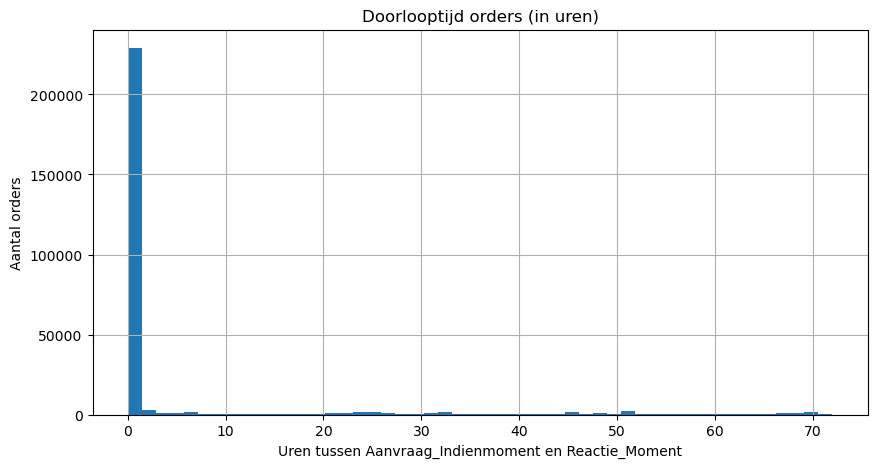

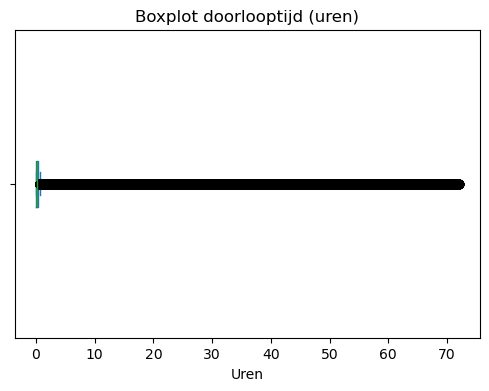

C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3184258903.py:100: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  t1_dt = pd.to_datetime(chunk["Reactie_Moment"], errors="coerce", infer_datetime_format=True)
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3184258903.py:100: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  t1_dt = pd.to_datetime(chunk["Reactie_Moment"], errors="coerce", infer_datetime_format=True)
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3184258903.py:100: UserWarning: The argument 'infer_datetime_format' is deprecated and will be r

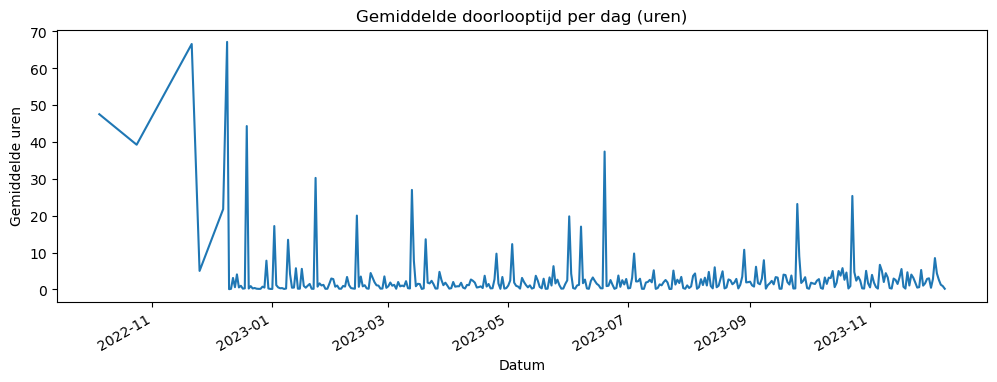

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE = "sherlock-export-cm-orders_dag-2022-12-11-2025-09-08.csv"
CHUNKSIZE = 200_000
SEP = ";"

# verzamel doorlooptijden in uren
durations = []

usecols = ["*Aanvraag_Indienmoment", "*Reactie_Moment", "Aanvraag_Indienmoment", "Reactie_Moment"]

def clean_cols(cols):
    return [c.lstrip("*").strip() if isinstance(c, str) else c for c in cols]

def parse_time_only_to_timedelta(s: pd.Series) -> pd.Series:
    """Zet strings als 'HH:MM:SS' om naar tijdsdeltas (uren,min,sec)."""
    # parse als datetime met fictieve datum, daarna alleen tijdcomponent houden
    dt = pd.to_datetime(s, format="%H:%M:%S", errors="coerce")
    return (dt.dt.hour.fillna(0)*3600 + dt.dt.minute.fillna(0)*60 + dt.dt.second.fillna(0)).astype("float64")

reader = pd.read_csv(FILE, sep=SEP, chunksize=CHUNKSIZE, usecols=lambda c: c in usecols or c.lstrip("*").strip() in ["Aanvraag_Indienmoment","Reactie_Moment"], low_memory=True)

for i, chunk in enumerate(reader, start=1):
    # kolomnamen normaliseren (sterretjes weg)
    chunk.columns = clean_cols(chunk.columns)

    if not {"Aanvraag_Indienmoment","Reactie_Moment"}.issubset(chunk.columns):
        # soms heet het nét anders; print een hint
        if i == 1:
            print("[!] Kolommen niet gevonden. Beschikbare:", list(chunk.columns)[:20], "...")
        continue

    t0 = pd.to_datetime(chunk["Aanvraag_Indienmoment"], errors="coerce")

    # eerst proberen als volledige datetime
    t1_dt = pd.to_datetime(chunk["Reactie_Moment"], errors="coerce", infer_datetime_format=True)

    # detecteer 'time-only' patronen: veel jaren 1899/1900 of alles NaT
    looks_like_time_only = False
    if t1_dt.notna().any():
        years = t1_dt.dt.year.dropna()
        if len(years) > 0 and (years <= 1901).mean() > 0.8:
            looks_like_time_only = True
    else:
        # alles NaT -> mogelijk tijdformaat dat niet geparsed werd
        looks_like_time_only = True

    if looks_like_time_only:
        # parse als HH:MM:SS -> timedelta
        td_seconds = parse_time_only_to_timedelta(chunk["Reactie_Moment"])
        # combineer met de datum van t0
        t1 = t0.dt.normalize() + pd.to_timedelta(td_seconds, unit="s")
    else:
        t1 = t1_dt

    # verschil in uren
    delta_hours = (t1 - t0).dt.total_seconds() / 3600.0

    # schoon: verwijder NaN, negatieve waarden (behandeling vóór indiening) en absurde outliers
    delta_hours = delta_hours.replace([np.inf, -np.inf], np.nan).dropna()
    delta_hours = delta_hours[(delta_hours >= 0) & (delta_hours <= 72)]

    durations.extend(delta_hours.tolist())

    if i % 10 == 0:
        print(f"Processed ~{i*CHUNKSIZE:,} rows; collected {len(durations):,} durations...")

print(f"Totale geldige doorlooptijden: {len(durations):,}")

# ---- Visualisaties ----
dur = pd.Series(durations)

plt.figure(figsize=(10,5))
dur.hist(bins=50)
plt.title("Doorlooptijd orders (in uren)")
plt.xlabel("Uren tussen Aanvraag_Indienmoment en Reactie_Moment")
plt.ylabel("Aantal orders")
plt.show()

plt.figure(figsize=(6,4))
dur.plot(kind="box", vert=False)
plt.title("Boxplot doorlooptijd (uren)")
plt.xlabel("Uren")
plt.show()

# Optioneel: gemiddelde doorlooptijd per dag van indiening
# (handig om procesverloop over tijd te zien)
# We moeten hiervoor nogmaals streamen om per dag te aggregeren zonder alles in geheugen te houden.
daily_sum = {}
daily_cnt = {}

reader2 = pd.read_csv(FILE, sep=SEP, chunksize=CHUNKSIZE, usecols=lambda c: c in usecols or c.lstrip("*").strip() in ["Aanvraag_Indienmoment","Reactie_Moment"], low_memory=True)
for chunk in reader2:
    chunk.columns = clean_cols(chunk.columns)
    if not {"Aanvraag_Indienmoment","Reactie_Moment"}.issubset(chunk.columns):
        continue
    t0 = pd.to_datetime(chunk["Aanvraag_Indienmoment"], errors="coerce")
    t1_dt = pd.to_datetime(chunk["Reactie_Moment"], errors="coerce", infer_datetime_format=True)

    looks_like_time_only = False
    if t1_dt.notna().any():
        years = t1_dt.dt.year.dropna()
        if len(years) > 0 and (years <= 1901).mean() > 0.8:
            looks_like_time_only = True
    else:
        looks_like_time_only = True

    if looks_like_time_only:
        td_seconds = parse_time_only_to_timedelta(chunk["Reactie_Moment"])
        t1 = t0.dt.normalize() + pd.to_timedelta(td_seconds, unit="s")
    else:
        t1 = t1_dt

    delta_hours = (t1 - t0).dt.total_seconds() / 3600.0
    mask = delta_hours.notna() & (delta_hours >= 0) & (delta_hours <= 72) & t0.notna()
    if mask.any():
        dates = t0[mask].dt.date
        vals = delta_hours[mask]
        grp = pd.concat([pd.Series(dates.values), pd.Series(vals.values)], axis=1)
        grp.columns = ["date","dur"]
        daily = grp.groupby("date")["dur"].agg(["sum","count"])
        for d, row in daily.iterrows():
            daily_sum[d] = daily_sum.get(d, 0.0) + float(row["sum"])
            daily_cnt[d] = daily_cnt.get(d, 0) + int(row["count"])

if daily_cnt:
    import pandas as pd
    dates = sorted(daily_cnt.keys())
    avg = [daily_sum[d]/daily_cnt[d] for d in dates]
    s = pd.Series(avg, index=pd.to_datetime(dates))
    plt.figure(figsize=(12,4))
    s.plot()
    plt.title("Gemiddelde doorlooptijd per dag (uren)")
    plt.xlabel("Datum")
    plt.ylabel("Gemiddelde uren")
    plt.show()


[i] Gebruik kolom procestype: Procestype
[i] Gebruik timestamp: Tijdstempel
[i] Verwerkt ~2,000,000 rijen...
[i] Streaming klaar.


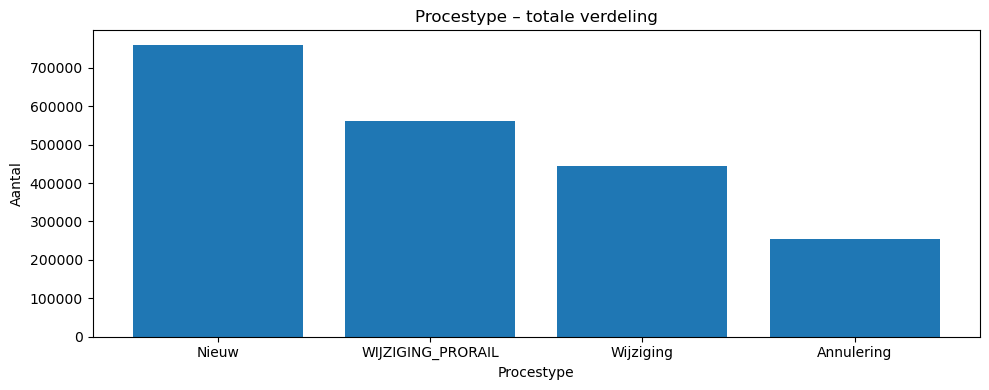

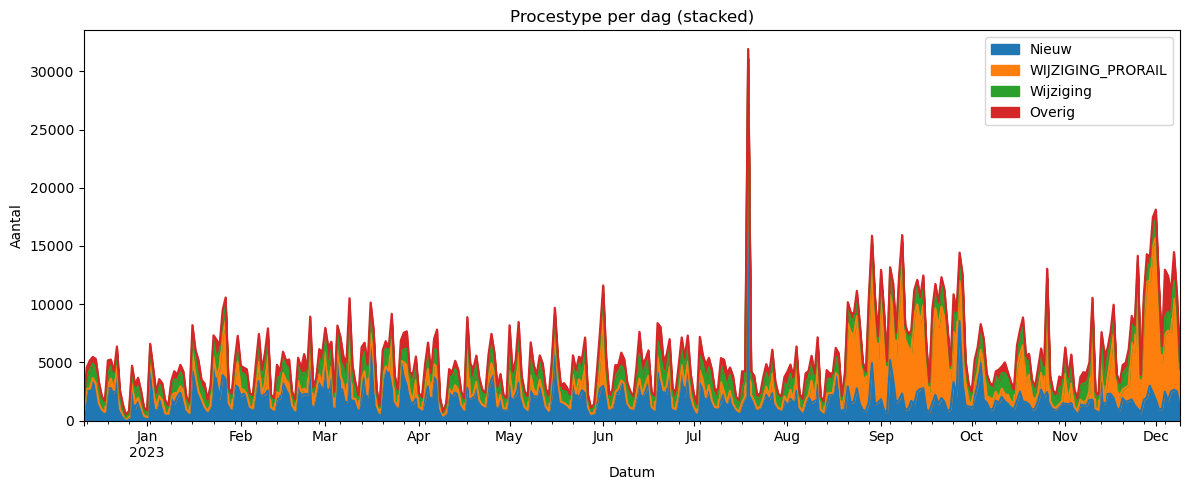

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import csv

# ---------------- settings ----------------
FILE = "sherlock-export-cm-orders_dag-2022-12-11-2025-09-08.csv"
SEP = ";"                 # wijzig indien nodig
CHUNKSIZE = 200_000
# Kandidaten voor de procestype-kolom (we pakken de eerste die bestaat)
PROCESS_COL_CANDIDATES = [
    "Procestype", "Order_Procestype", "Order_OrderType", "Order_Type"
]
TIMESTAMP_COL_CANDIDATES = ["Tijdstempel", "Order_Tijdstempel", "Created", "CreateTime"]

# ---------------- helpers ----------------
def normalize_cols(cols):
    return [c.lstrip("*").strip() if isinstance(c, str) else c for c in cols]

def normalize_proces_value(val: str) -> str:
    """Zachte normalisatie: trims/ lower-case, mapt varianten op Annulering/Wijziging/Nieuw."""
    if not isinstance(val, str):
        return "Onbekend"
    s = val.strip().lower()
    if s in {"annulering", "annuleren", "cancel", "cancellation", "annul"}:
        return "Annulering"
    if s in {"wijziging", "wijzigen", "update", "change", "mutatie"}:
        return "Wijziging"
    if s in {"nieuw", "new", "aanvraag", "create", "aanmaken"}:
        return "Nieuw"
    # laat originele hoofdletters staan als het al netjes is
    return val.strip() if val.strip() else "Onbekend"

def detect_existing_columns(path: Path, sep: str):
    hdr = pd.read_csv(path, sep=sep, nrows=0, low_memory=False)
    hdr.columns = normalize_cols(hdr.columns)
    # procestype kolom
    proc_col = next((c for c in PROCESS_COL_CANDIDATES if c in hdr.columns), None)
    # timestamp kolom
    ts_col = next((c for c in TIMESTAMP_COL_CANDIDATES if c in hdr.columns), None)
    return proc_col, ts_col, hdr.columns.tolist()

# ---------------- discover columns ----------------
p = Path(FILE)
if not p.exists():
    raise FileNotFoundError(p)

proc_col, ts_col, all_cols = detect_existing_columns(p, SEP)
if proc_col is None:
    raise RuntimeError(f"Kon geen procestype-kolom vinden. Beschikbare kolommen (eerste 40): {all_cols[:40]}")

usecols = [proc_col]
if ts_col is not None:
    usecols.append(ts_col)

print(f"[i] Gebruik kolom procestype: {proc_col}")
if ts_col: print(f"[i] Gebruik timestamp: {ts_col}")

# ---------------- stream & aggregate ----------------
totals = Counter()
daily = {}   # dict[date] -> Counter({type: count})

reader = pd.read_csv(FILE, sep=SEP, chunksize=CHUNKSIZE, usecols=usecols, low_memory=True)
for i, chunk in enumerate(reader, start=1):
    chunk.columns = normalize_cols(chunk.columns)

    # procestype normaliseren
    s = chunk[proc_col].astype("string").fillna("Onbekend").map(normalize_proces_value)
    vc = s.value_counts(dropna=False)
    for k, v in vc.items():
        totals[k] += int(v)

    # tijdlijn per dag (alleen als timestamp aanwezig)
    if ts_col is not None:
        t = pd.to_datetime(chunk[ts_col], errors="coerce")
        df_tmp = pd.DataFrame({"date": t.dt.date, "type": s})
        grp = df_tmp.dropna(subset=["date"]).groupby(["date", "type"]).size()
        for (d, typ), cnt in grp.items():
            if d not in daily:
                daily[d] = Counter()
            daily[d][typ] += int(cnt)

    if i % 10 == 0:
        print(f"[i] Verwerkt ~{i*CHUNKSIZE:,} rijen...")

print("[i] Streaming klaar.")

# ---------------- plots ----------------
# 1) Totale verdeling (bar)
tot_s = pd.Series(totals).sort_values(ascending=False)
plt.figure(figsize=(10,4))
plt.bar(tot_s.index.astype(str), tot_s.values.astype(float))
plt.title("Procestype – totale verdeling")
plt.xlabel("Procestype")
plt.ylabel("Aantal")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2) Tijdlijn per dag (stacked area), als timestamp beschikbaar is
if daily:
    # maak dataframe: index=datum, kolommen=procestypes
    all_types = sorted({t for c in daily.values() for t in c.keys()})
    dates_sorted = sorted(daily.keys())
    data = pd.DataFrame(0, index=pd.to_datetime(dates_sorted), columns=all_types)
    for d in dates_sorted:
        for t, v in daily[d].items():
            data.loc[pd.to_datetime(d), t] = v

    # optioneel: alleen de 3 hoofdtypes tonen als er veel unieke zijn
    top3 = tot_s.head(3).index.tolist()
    keep_cols = [c for c in data.columns if c in top3]
    other = data.drop(columns=keep_cols).sum(axis=1)
    plot_df = data[keep_cols].copy()
    if (other > 0).any():
        plot_df["Overig"] = other

    # stacked area
    plot_df = plot_df.sort_index()
    plot_df.plot(kind="area", figsize=(12,5))
    plt.title("Procestype per dag (stacked)")
    plt.xlabel("Datum")
    plt.ylabel("Aantal")
    plt.tight_layout()
    plt.show()


In [27]:
import pandas as pd
import numpy as np
from pathlib import Path

# ---------- instellingen ----------
IN_FILE   = "sherlock-export-cm-orders_dag-2022-12-11-2025-09-08.csv"
OUT_FILE  = "orders_filtered_clean.csv"
LOG_FILE  = "orders_filtered_clean_log.txt"
SEP       = ";"              # pas aan indien nodig
CHUNKSIZE = 200_000
TIME_COL  = "EersteBehandelTijdstip"  # opgeSCHOONDE naam (dus zonder '*')

def clean_col(name):
    return name.lstrip("*").strip() if isinstance(name, str) else name

def clean_cols(cols):
    return [clean_col(c) for c in cols]

def has_any_value(s: pd.Series) -> bool:
    if s.dtype == object:
        s = s.replace({"": np.nan, " ": np.nan})
    return s.notna().any()

# ---- Pass 0: header lezen, mapping ruwe->cleaned maken ----
hdr_raw = pd.read_csv(IN_FILE, sep=SEP, nrows=0, low_memory=False)
raw_cols = list(hdr_raw.columns)
cleaned_cols = clean_cols(raw_cols)
raw_to_clean = dict(zip(raw_cols, cleaned_cols))

if TIME_COL not in cleaned_cols:
    raise RuntimeError(f"Kolom '{TIME_COL}' niet gevonden. Beschikbare (gecleanede) kolommen: {cleaned_cols[:40]} ...")

# ---- Pass 1: bepaal niet-lege kolommen na rijenfilter op TIME_COL ----
non_empty_clean = set()
total_rows_seen = 0
total_rows_kept = 0

reader1 = pd.read_csv(IN_FILE, sep=SEP, chunksize=CHUNKSIZE, low_memory=True)
for i, chunk in enumerate(reader1, start=1):
    total_rows_seen += len(chunk)

    # kolomnamen opschonen binnen de chunk
    chunk.columns = clean_cols(chunk.columns)

    # rijen filteren: TIME_COL moet niet leeg/space zijn
    t = chunk[TIME_COL].astype("string")
    mask_time = t.str.strip().ne("").fillna(False)
    kept = chunk[mask_time]
    total_rows_kept += len(kept)

    if kept.empty:
        if i % 10 == 0:
            print(f"[Pass1] ~{i*CHUNKSIZE:,} rijen gezien; (geen rows in deze chunk na filter)")
        continue

    # update set met kolommen die iéts bevatten
    for col in kept.columns:
        if has_any_value(kept[col]):
            non_empty_clean.add(col)

    if i % 10 == 0:
        print(f"[Pass1] ~{i*CHUNKSIZE:,} rijen gezien; niet-lege kolommen tot nu toe: {len(non_empty_clean)}")

if not non_empty_clean:
    raise RuntimeError("Na filtering op 'EersteBehandelTijdstip' blijft er geen data over.")

# behoud oorspronkelijke volgorde van de kolommen (op basis van cleaned volgorde)
keep_clean_cols = [c for c in cleaned_cols if c in non_empty_clean]

# Voor logging: bepaal gedropte kolommen (gecleaned)
dropped_clean_cols = [c for c in cleaned_cols if c not in keep_clean_cols]

print(f"Totaal rijen gezien: {total_rows_seen:,}")
print(f"Rijen na filter (TIME_COL niet leeg): {total_rows_kept:,}")
print(f"Totaal niet-lege kolommen: {len(keep_clean_cols)}")

# ---- Pass 2: schrijven naar CSV met een usecols-callable die raw->clean map gebruikt ----

# usecols callable: accepteer ruwe kolomnaam als de GELEANDE naam in keep_clean_cols zit
keep_clean_set = set(keep_clean_cols)
def usecols_callable(raw_colname: str) -> bool:
    return clean_col(raw_colname) in keep_clean_set

first_chunk = True
written_rows = 0

reader2 = pd.read_csv(IN_FILE, sep=SEP, chunksize=CHUNKSIZE, usecols=usecols_callable, low_memory=True)
for j, chunk in enumerate(reader2, start=1):
    # schoon kolomnamen in de chunk zodat headers in output netjes zijn
    chunk.columns = clean_cols(chunk.columns)

    # rijen filteren
    t = chunk[TIME_COL].astype("string")
    mask_time = t.str.strip().ne("").fillna(False)
    chunk = chunk[mask_time]
    if chunk.empty:
        if j % 10 == 0:
            print(f"[Pass2] ~{j*CHUNKSIZE:,} rijen verwerkt; (geen rows in deze chunk na filter)")
        continue

    # object-lege strings -> NaN (optioneel, netter)
    obj_cols = chunk.select_dtypes(include=["object"]).columns
    if len(obj_cols):
        chunk[obj_cols] = chunk[obj_cols].replace({"": np.nan, " ": np.nan})

    # append naar CSV
    chunk.to_csv(
        OUT_FILE,
        sep=SEP,
        index=False,
        mode="w" if first_chunk else "a",
        header=first_chunk
    )
    first_chunk = False
    written_rows += len(chunk)

    if j % 10 == 0:
        print(f"[Pass2] ~{j*CHUNKSIZE:,} rijen verwerkt; totaal weggeschreven: {written_rows:,}")

print(f"[✓] Klaar. Weggeschreven rijen: {written_rows:,} → {OUT_FILE}")

# ---- Logging ----
with open(LOG_FILE, "w", encoding="utf-8") as f:
    f.write(f"Input: {IN_FILE}\n")
    f.write(f"Output: {OUT_FILE}\n")
    f.write(f"Separator: {SEP}\n")
    f.write(f"Chunksize: {CHUNKSIZE}\n")
    f.write(f"Filter: {TIME_COL} != '' (na strip)\n")
    f.write(f"Rows seen: {total_rows_seen}\n")
    f.write(f"Rows kept: {total_rows_kept}\n")
    f.write(f"Rows written: {written_rows}\n\n")
    f.write("Kept columns (cleaned names):\n")
    for c in keep_clean_cols:
        f.write(f"  - {c}\n")
    f.write("\nDropped columns (cleaned names):\n")
    for c in dropped_clean_cols:
        f.write(f"  - {c}\n")

print(f"[i] Log geschreven naar: {LOG_FILE}")


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1534598927.py:39: DtypeWarning: Columns (7,25,27,29,31,42,56,63,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader1, start=1):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1534598927.py:39: DtypeWarning: Columns (42,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader1, start=1):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1534598927.py:39: DtypeWarning: Columns (42,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader1, start=1):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1534598927.py:39: DtypeWarning: Columns (42,56,63) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader1, start=1):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1534598927.py:39: DtypeWarning: Columns (2

[Pass1] ~2,000,000 rijen gezien; niet-lege kolommen tot nu toe: 99


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1534598927.py:39: DtypeWarning: Columns (18,42) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader1, start=1):


Totaal rijen gezien: 2,020,302
Rijen na filter (TIME_COL niet leeg): 1,330,904
Totaal niet-lege kolommen: 99


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1534598927.py:88: DtypeWarning: Columns (7,25,27,29,31,42,56,63,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for j, chunk in enumerate(reader2, start=1):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1534598927.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[obj_cols] = chunk[obj_cols].replace({"": np.nan, " ": np.nan})
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1534598927.py:88: DtypeWarning: Columns (42,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for j, chunk in enumerate(reader2, start=1):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1534598927.py:104: SettingWithCopyWarning: 
A value is try

[Pass2] ~2,000,000 rijen verwerkt; totaal weggeschreven: 1,314,548


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1534598927.py:88: DtypeWarning: Columns (18,42) have mixed types. Specify dtype option on import or set low_memory=False.
  for j, chunk in enumerate(reader2, start=1):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1534598927.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[obj_cols] = chunk[obj_cols].replace({"": np.nan, " ": np.nan})


[✓] Klaar. Weggeschreven rijen: 1,330,904 → orders_filtered_clean.csv
[i] Log geschreven naar: orders_filtered_clean_log.txt


In [53]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Data cleaning (chunked) voor sherlock-export-cm-orders_dag-2022-12-11-2025-09-08.csv

Regels verwijderen als:
- hele rij leeg
- Reactie_type ontbreekt/leeg
- Aanvraagkanaal == 'handmatig' (case-insensitive)
- Aanvraag_Fase_Planproces == 'Jaardienst' (case-insensitive)

Behouden kolommen + afgeleiden:
- Aanvraag_Indienmoment (AG)  -> req_ts (datetime), req_year, dow, hour
- Aanvraag_Dienstregelingjaar (AH) -> dienstregelingjaar (int)
- Vergelijk AG vs AH          -> year_match (bool -> int)
- Aanvraag_vervoerder_verkorting (AJ)
- Aanvraag_Routelint (BQ)
- Aanvraag_Eerste_Locatie_Vroegste_Vertrektijd (BF)
- Aanvraag_Eerste_Locatie_Laatste_Vertrektijd  (BG)
    -> earliest_dep_s, latest_dep_s, tolerance_min
- Aanvraag_Eerste_Locatie_Behandelingen (BH)   -> stabling_first_flag
- Aanvraag_Laatste_Locatie_Behandelingen (BO)  -> stabling_last_flag
- Reactie_type (target)
"""

from pathlib import Path
import pandas as pd
import numpy as np

# ---------- CONFIG ----------
SRC = Path("sherlock-export-cm-orders_dag-2022-12-11-2025-09-08.csv")
OUT = Path("orders_cleaned_modelready.csv")
SEP = ";"            # pas aan indien nodig
CHUNK = 200_000      # verlaag als je weinig RAM hebt
# ----------------------------

if not SRC.exists():
    raise FileNotFoundError(SRC)

def norm_cols(cols):
    return [c.lstrip("*").strip() if isinstance(c, str) else c for c in cols]

# 1) Header inlezen en kolomnamen normaliseren
hdr = pd.read_csv(SRC, sep=SEP, nrows=0, low_memory=False)
hdr.columns = norm_cols(hdr.columns)

# Kolomnamen zoals in de dataset (na normaliseren, geen sterretje)
COLS = {
    "indien": "Aanvraag_Indienmoment",                         # AG
    "dienstjaar": "Aanvraag_Dienstregelingjaar",               # AH
    "vervoerder": "Aanvraag_vervoerder_verkorting",            # AJ
    "routelint": "Aanvraag_Routelint",                         # BQ
    "earliest": "Aanvraag_Eerste_Locatie_Vroegste_Vertrektijd",# BF
    "latest":   "Aanvraag_Eerste_Locatie_Laatste_Vertrektijd", # BG
    "beh_first":"Aanvraag_Eerste_Locatie_Behandelingen",       # BH
    "beh_last": "Aanvraag_Laatste_Locatie_Behandelingen",      # BO
    "kanaal":   "Aanvraagkanaal",
    "fase":     "Aanvraag_Fase_Planproces",
    "reactie":  "Reactie_type",
}

# Controleer aanwezigheid; sommige kunnen ontbreken in bepaalde dagen — we gaan daar defensief mee om
missing = [v for v in COLS.values() if v not in hdr.columns]
if missing:
    print("[Waarschuwing] Ontbrekende kolommen in header:", missing)

# 2) Helpers
def parse_time_to_seconds(x: pd.Series) -> pd.Series:
    """
    Verwacht HH:MM:SS of HH:MM; retourneert seconden sinds middernacht.
    Onparseerbare waarden -> NaN.
    """
    s = x.astype("string").str.strip()
    # leeg naar NaN
    s = s.replace({"": np.nan, "NaN": np.nan})
    # parse naar tijdcomponent
    # gebruik pandas to_datetime met errors='coerce' en een dummy datum
    dt = pd.to_datetime(s, format="%H:%M:%S", errors="coerce")
    dt2 = pd.to_datetime(s, format="%H:%M", errors="coerce")
    dt = dt.fillna(dt2)
    secs = (dt.dt.hour.fillna(0)*3600 + dt.dt.minute.fillna(0)*60 + dt.dt.second.fillna(0)).astype("float")
    secs[dt.isna()] = np.nan
    return secs

def safe_upper(s: pd.Series) -> pd.Series:
    return s.astype("string").str.upper().str.strip()

# 3) Output initialiseren
if OUT.exists():
    OUT.unlink()
first = True

stats_in = 0
stats_kept = 0
stats_dropped_empty = 0
stats_dropped_no_reactie = 0
stats_dropped_kanaal = 0
stats_dropped_fase = 0
rows_with_neg_tol = 0

# 4) Streamen
usecols_all = [c for c in COLS.values() if c in hdr.columns]
reader = pd.read_csv(SRC, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=usecols_all)

for chunk in reader:
    chunk.columns = norm_cols(chunk.columns)
    stats_in += len(chunk)

    # Drop volledig lege rijen (op basis van alle ingelezen kolommen)
    m_not_all_na = ~chunk.isna().all(axis=1)
    stats_dropped_empty += int((~m_not_all_na).sum())
    chunk = chunk.loc[m_not_all_na]

    # Filter 1: Reactie_type niet leeg
    if COLS["reactie"] in chunk.columns:
        rt = safe_upper(chunk[COLS["reactie"]])
        m_reactie_present = rt.notna() & (rt.str.len() > 0)
        stats_dropped_no_reactie += int((~m_reactie_present).sum())
        chunk = chunk.loc[m_reactie_present]
        # gebruik genormaliseerde versie:
        chunk[COLS["reactie"]] = rt.loc[m_reactie_present]
    else:
        # als Reactie_type ontbreekt in deze export: alles valt af
        continue

    # Filter 2: Aanvraagkanaal != handmatig
    if COLS["kanaal"] in chunk.columns:
        kanaal = safe_upper(chunk[COLS["kanaal"]])
        m_keep_kanaal = ~(kanaal == "HANDMATIG")
        stats_dropped_kanaal += int((~m_keep_kanaal).sum())
        chunk = chunk.loc[m_keep_kanaal]

    # Filter 3: Aanvraag_Fase_Planproces != Jaardienst
    if COLS["fase"] in chunk.columns:
        fase = safe_upper(chunk[COLS["fase"]])
        m_keep_fase = ~(fase == "JAARDIENST")
        stats_dropped_fase += int((~m_keep_fase).sum())
        chunk = chunk.loc[m_keep_fase]

    if chunk.empty:
        continue

    # Afgeleide features
    # 3.1 Aanvraag_Indienmoment -> req_ts, req_year, dow, hour
    req_ts = pd.to_datetime(chunk.get(COLS["indien"]), errors="coerce")
    req_year = req_ts.dt.year.astype("Int64")
    dow = req_ts.dt.weekday.astype("Int64")    # 0=ma .. 6=zo
    hour = req_ts.dt.hour.astype("Int64")

    # 3.2 Aanvraag_Dienstregelingjaar
    dienstjaar = pd.to_numeric(chunk.get(COLS["dienstjaar"]), errors="coerce").astype("Int64")

    # 3.3 Compare AG vs AH
    year_match = (req_year == dienstjaar).astype("Int8")

    # 3.4 Vertrektijden -> seconds + tolerance
    earliest_s = parse_time_to_seconds(chunk.get(COLS["earliest"])) if COLS["earliest"] in chunk.columns else pd.Series(np.nan, index=chunk.index)
    latest_s   = parse_time_to_seconds(chunk.get(COLS["latest"]))   if COLS["latest"]   in chunk.columns else pd.Series(np.nan, index=chunk.index)
    tol_min = (latest_s - earliest_s) / 60.0
    # negatieve toleranties naar NaN (inconsistente input)
    bad = tol_min.notna() & (tol_min < 0)
    rows_with_neg_tol += int(bad.sum())
    tol_min[bad] = np.nan

    # 3.5 Behandelingen flags
    beh_first = chunk.get(COLS["beh_first"])
    beh_last  = chunk.get(COLS["beh_last"])
    stabling_first_flag = beh_first.astype("string").str.strip().ne("").astype("Int8") if beh_first is not None else pd.Series(0, index=chunk.index, dtype="Int8")
    stabling_last_flag  = beh_last.astype("string").str.strip().ne("").astype("Int8")  if beh_last  is not None else pd.Series(0, index=chunk.index, dtype="Int8")

    # 3.6 Subset + rename
    out = pd.DataFrame({
        # Target
        "Reactie_type": chunk[COLS["reactie"]],
        # When request submitted
        "req_ts": req_ts,
        "req_year": req_year,
        "dienstregelingjaar": dienstjaar,
        "year_match": year_match,
        # By whom
        "aanvraag_vervoerder_verkorting": chunk.get(COLS["vervoerder"]),
        # OD + intermediate
        "aanvraag_routelint": chunk.get(COLS["routelint"]),
        # Time of day / tolerance
        "earliest_dep_s": earliest_s,
        "latest_dep_s": latest_s,
        "tolerance_min": tol_min,
        # Day of week / hour
        "dow": dow,
        "hour": hour,
        # Services / stabling
        "aanvraag_eerste_locatie_behandelingen": beh_first if beh_first is not None else pd.NA,
        "aanvraag_laatste_locatie_behandelingen": beh_last if beh_last is not None else pd.NA,
        "stabling_first_flag": stabling_first_flag,
        "stabling_last_flag": stabling_last_flag,
    })

    # Eventueel NA-only rijen nogmaals weg (na transformaties)
    out = out.dropna(how="all")
    if out.empty:
        continue

    # Append naar CSV
    out.to_csv(OUT, sep=SEP, index=False, mode="w" if first else "a", header=first)
    first = False
    stats_kept += len(out)

print("[Klaar]")
print(f" Ingelezen rijen:          {stats_in:,}")
print(f" Verwijderd (volledig leeg): {stats_dropped_empty:,}")
print(f" Verwijderd (geen reactie):  {stats_dropped_no_reactie:,}")
print(f" Verwijderd (kanaal=handmatig): {stats_dropped_kanaal:,}")
print(f" Verwijderd (fase=Jaardienst):  {stats_dropped_fase:,}")
print(f" Geschreven (keep):         {stats_kept:,}")
print(f" Negatieve toleranties gecorrigeerd naar NaN: {rows_with_neg_tol:,}")
print(f" Uitvoer: {OUT.resolve()}")


[Klaar]
 Ingelezen rijen:          2,020,302
 Verwijderd (volledig leeg): 0
 Verwijderd (geen reactie):  934,209
 Verwijderd (kanaal=handmatig): 634,575
 Verwijderd (fase=Jaardienst):  18,115
 Geschreven (keep):         433,402
 Negatieve toleranties gecorrigeerd naar NaN: 1,512
 Uitvoer: C:\Users\quint\Downloads\orders_cleaned_modelready.csv


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# -------------------------
DATA = Path("orders_cleaned_modelready.csv")
OUTDIR = Path("plots_reactietype")
OUTDIR.mkdir(exist_ok=True)
SEP = ";"
CHUNK = 200_000
# -------------------------

CAT_COLS = [
    "aanvraag_vervoerder_verkorting",
    "aanvraag_routelint",
    "dow",
    "hour",
    "stabling_first_flag",
    "stabling_last_flag",
]
NUM_COLS = [
    "earliest_dep_s",
    "latest_dep_s",
    "tolerance_min",
]
TARGET = "Reactie_type"

cat_counts = {c: {} for c in CAT_COLS}
num_stats = {c: {} for c in NUM_COLS}

# ---- Data inlezen in chunks ----
for chunk in pd.read_csv(DATA, sep=SEP, chunksize=CHUNK, low_memory=True):
    if TARGET not in chunk.columns:
        continue
    chunk[TARGET] = chunk[TARGET].astype(str).str.upper().str.strip()

    # categorisch
    for c in CAT_COLS:
        if c not in chunk.columns:
            continue
        counts = chunk.groupby([TARGET, c]).size()
        for (rt, val), cnt in counts.items():
            cat_counts[c].setdefault(rt, {})
            cat_counts[c][rt][val] = cat_counts[c][rt].get(val, 0) + cnt

    # numeriek
    for c in NUM_COLS:
        if c not in chunk.columns:
            continue
        for rt, vals in chunk.groupby(TARGET)[c]:
            vals = pd.to_numeric(vals, errors="coerce").dropna()
            if len(vals) == 0:
                continue
            stats = num_stats[c].setdefault(rt, {"count":0, "sum":0, "values":[]})
            stats["count"] += len(vals)
            stats["sum"] += vals.sum()
            stats["values"].extend(
                vals.sample(min(500, len(vals)), random_state=0).tolist()
            )

# ---- Plot categorisch ----
for c, by_rt in cat_counts.items():
    df = []
    for rt, d in by_rt.items():
        for val, cnt in d.items():
            df.append({"Reactie_type": rt, c: val, "count": cnt})
    if not df:
        continue
    plot_df = pd.DataFrame(df)

    # sorteer op totale count
    totals = plot_df.groupby(c)["count"].sum().sort_values(ascending=False)
    plot_df[c] = pd.Categorical(plot_df[c], categories=totals.index, ordered=True)

    plt.figure(figsize=(12,6))
    sns.barplot(data=plot_df, x=c, y="count", hue="Reactie_type")
    plt.title(f"Verdeling van {c} per Reactie_type")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    out_path = OUTDIR / f"{c}_per_reactie.png"
    plt.savefig(out_path, dpi=150)
    plt.close()
    print(f"[OK] Saved {out_path}")

# ---- Plot numeriek ----
for c, by_rt in num_stats.items():
    df = []
    for rt, d in by_rt.items():
        for v in d["values"]:
            df.append({"Reactie_type": rt, c: v})
    if not df:
        continue
    plot_df = pd.DataFrame(df)

    plt.figure(figsize=(10,6))
    sns.boxplot(data=plot_df, x="Reactie_type", y=c)
    plt.title(f"Boxplot van {c} per Reactie_type")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()

    out_path = OUTDIR / f"{c}_per_reactie.png"
    plt.savefig(out_path, dpi=150)
    plt.close()
    print(f"[OK] Saved {out_path}")


[OK] Saved plots_reactietype\aanvraag_vervoerder_verkorting_per_reactie.png


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1330316028.py:81: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1330316028.py:81: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1330316028.py:84: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(out_path, dpi=150)


[OK] Saved plots_reactietype\aanvraag_routelint_per_reactie.png
[OK] Saved plots_reactietype\dow_per_reactie.png
[OK] Saved plots_reactietype\hour_per_reactie.png
[OK] Saved plots_reactietype\stabling_first_flag_per_reactie.png
[OK] Saved plots_reactietype\stabling_last_flag_per_reactie.png
[OK] Saved plots_reactietype\earliest_dep_s_per_reactie.png
[OK] Saved plots_reactietype\latest_dep_s_per_reactie.png
[OK] Saved plots_reactietype\tolerance_min_per_reactie.png


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Maak visualisaties per feature (die NIET gedropt worden) versus Reactie_type.
- Leest de originele CSV in chunks (RAM-vriendelijk).
- Past dezelfde whitelist/forbidden toe als het model.
- Numeriek: 2-pass -> min/max bepalen, daarna histogram per klasse (Reactie_type).
- Categorisch: frequenties per klasse; plot top-N categorieën per kolom.

Output: PNG's in ./viz_out/
"""

from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

# ======================= CONFIG =======================
CSV_PATH   = Path("orders_cleaned_modelready.csv")   # originele, grote CSV
SEP        = ";"
CHUNK      = 100_000
OUT_DIR    = Path("./viz_out")
TARGET_RT  = "Reactie_type"
TIME_COL   = "Tijdstempel"
MAX_CATS   = 15
NUM_BINS   = 30
LIMIT_COLS = None
RANDOM_SEED = 42

# Zelfde whitelist/forbidden als in het model
WHITELIST_PREFIXES = [
    "Aanvraag_",
    "AangevraagdeDatumStatus",
    "Aanvraagkanaal",
    "Aanvraagcategorie","Ordercategorie","Procestype",
    "Aanvrager_Verkorting","Aanvraag_vervoerder_verkorting",
    "Aanvraag_Treinnummer","Oorspronkelijk_Treinnummer",
    "Order_Orderelementen_teller","Order_Orderelementen_aangevraagdedagen_teller",
    "Order_Reactieelementen_teller",
    "Ordernummer","Orderversienummer",
    "Aanvraag_Dienstregelingjaar","Aanvraag_Fase_Planproces","Aanvraag_Berichttype","Aanvraag_Soort",
    "Aanvraag_Eerste_Locatie_","Aanvraag_Laatste_Locatie_",
    "Aanvraag_Treinwijzingen","Aanvraag_Routelint",
    TIME_COL, "Tijdstempel",
]

FORBIDDEN_COLS = set([
    "Status","Taastatus","Behandelaar","EersteBehandelTijdstip",
    "VerwachtePublicatiedatum","AfgesprokenPublicatdatum","AfgesprokenPublicatiedatum",
    "Aanvraag_Case_Reference","Aanvraag_Identificatie","Aanvraag_Variant",
    "Reactie_Variant","Reactie_Moment","Reactie_type","Reactie_Toelichting",
    "Reactie_Dienstregelingjaar","Reactie_Vervoerder_Afkorting","Reactie_Treinnummer",
    "Aanvraag_Verwerkingdagen_Aangebodendag",
    "Reactie_Eerste_Activiteit_Treintype","Reactie_Eerste_Activiteit_Rijkarakteristiek",
    "Reactie_Eerste_Activiteit_BVRegelingen","Reactie_Eerste_Activiteit_Materieelsoort",
    "Reactie_Eerste_Activiteit_Materieeltype","Reactie_Eerste_Activiteit_Tractievorm",
    "Reactie_Eerste_Activiteit_MaxLengte","Reactie_Eerste_Activiteit_MaxSnelheid",
    "Reactie_Eerste_Activiteit_Dienstregelingssnelheid","Reactie_Eerste_Activiteit_MaxGewicht",
    "Reactie_Eerste_Activiteit_Remstand","Reactie_Eerste_Activiteit_RemPercentage",
    "Reactie_Eerste_Activiteit_Belastingklasse","Reactie_Eerste_Activiteit_Profielcodes",
    "Reactie_Eerste_Activiteit_Toelichting","Reactie_Eerste_Activiteit_Dienstregelpunt",
    "Reactie_Eerste_Activiteit_DienstregelpuntSpoor","Reactie_Eerste_Activiteit_Treinactiviteit",
    "Reactie_Eerste_Activiteit_Tijdstip","Reactie_Eerste_Activiteit_Tijdstip_offset",
    "Reactie_Eerste_Activiteit_Opmerkingen",
    "Reactie_Laatste_Activiteit_Dienstregelpunt","Reactie_Laatste_Activiteit_DienstregelpuntSpoor",
    "Reactie_Laatste_Activiteit_Activiteitsoort","Reactie_Laatste_Activiteit_Tijdstip",
    "Reactie_Laatste_Activiteit_Tijdstip_Offset","Reactie_Laatste_Activiteit_Opmerkingen",
    "Reactie_Routelint","IngeschatteUren","GespendeerdeUren","ResterendeUren","Unnamed: 109",
    "Omschrijving","Opmerkingen_Intern"
])
# =======================================================

np.random.seed(RANDOM_SEED)
OUT_DIR.mkdir(parents=True, exist_ok=True)

def clean_cols_inplace(df: pd.DataFrame):
    df.columns = [c.lstrip("*").strip() if isinstance(c, str) else c for c in df.columns]

def is_whitelisted(col: str) -> bool:
    return any(col.startswith(p) for p in WHITELIST_PREFIXES)

if not CSV_PATH.exists():
    raise FileNotFoundError(f"Bestand niet gevonden: {CSV_PATH}")

# ---------- PASS 0: header & schema ----------
hdr = pd.read_csv(CSV_PATH, sep=SEP, nrows=0, low_memory=False)
clean_cols_inplace(hdr)
if TARGET_RT not in hdr.columns:
    raise RuntimeError(f"Kolom '{TARGET_RT}' niet gevonden in {CSV_PATH}")

cand_cols = [c for c in hdr.columns if c != TARGET_RT and c not in FORBIDDEN_COLS and is_whitelisted(c)]
if LIMIT_COLS is not None:
    cand_cols = [c for c in cand_cols if c in set(LIMIT_COLS)]

sample = pd.read_csv(CSV_PATH, sep=SEP, nrows=20_000, low_memory=False, usecols=[TARGET_RT] + cand_cols)
clean_cols_inplace(sample)

num_cols = sample[cand_cols].select_dtypes(include=["number","bool"]).columns.tolist()
cat_cols = [c for c in cand_cols if c not in num_cols]
for tcol in [TIME_COL, "Tijdstempel"]:
    if tcol in num_cols: num_cols.remove(tcol)
    if tcol in cat_cols: cat_cols.remove(tcol)

print(f"[Schema] #features={len(cand_cols)} | #num={len(num_cols)} | #cat={len(cat_cols)}")

# ---------- PASS 1 (numeriek): min/max ----------
num_min = {c: np.inf for c in num_cols}
num_max = {c: -np.inf for c in num_cols}

if num_cols:
    for ch in pd.read_csv(CSV_PATH, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=[TARGET_RT] + num_cols):
        clean_cols_inplace(ch)
        for c in num_cols:
            s = pd.to_numeric(ch[c], errors="coerce")
            if s.notna().any():
                num_min[c] = min(num_min[c], float(s.min()))
                num_max[c] = max(num_max[c], float(s.max()))

num_bins = {}
for c in num_cols:
    lo, hi = num_min[c], num_max[c]
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = 0.0, 1.0
    num_bins[c] = np.linspace(lo, hi, NUM_BINS + 1)

# ---------- PASS 2: histogrammen (num) & counts (cat) per Reactie_type ----------
classes = set()
num_hists = {c: defaultdict(lambda: np.zeros(NUM_BINS, dtype=np.int64)) for c in num_cols}
cat_counts = {c: defaultdict(Counter) for c in cat_cols}

usecols_pass2 = [TARGET_RT] + num_cols + cat_cols
for ch in pd.read_csv(CSV_PATH, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=usecols_pass2):
    clean_cols_inplace(ch)
    # normaliseer Reactie_type
    rt = ch[TARGET_RT].astype("string").str.upper().str.strip()
    classes.update(rt.dropna().unique().tolist())

    # ---- numeriek (FIXED: gebruik pandas voor grouping) ----
    for c in num_cols:
        s = pd.to_numeric(ch[c], errors="coerce")
        valid = s.notna()
        if not valid.any():
            continue
        b = num_bins[c]
        bin_idx = np.digitize(s[valid].astype(float), b) - 1
        bin_idx = np.clip(bin_idx, 0, NUM_BINS - 1)
        cls_valid = rt[valid].astype("string").fillna("(NA)")
        dfb = pd.DataFrame({"cls": cls_valid.to_numpy(), "bin": bin_idx})
        vc = dfb.value_counts(["cls", "bin"])
        for (cls, bin_id), cnt in vc.items():
            num_hists[c][cls][int(bin_id)] += int(cnt)

    # ---- categorisch ----
    for c in cat_cols:
        s = ch[c].astype("string")
        # groepeer op klasse
        grouped = s.groupby(rt)
        for cls, grp in grouped:
            vals = grp.fillna("__NA__")
            cat_counts[c][cls].update(vals.tolist())

classes = [x for x in sorted(classes) if x is not None and x != ""] or ["(ONBEKEND)"]
print(f"[Classes] Reactie_type={classes}")

# ---------- Plotten ----------
def safe_filename(name: str) -> str:
    name = re.sub(r"[^A-Za-z0-9_.-]+", "_", name.strip())
    return name[:150]

# Numeriek: overlay histogrammen per klasse (genormaliseerd binnen klasse)
for c in num_cols:
    b = num_bins[c]
    centers = (b[:-1] + b[1:]) / 2.0
    plt.figure()
    for cls in classes:
        counts = num_hists[c].get(cls, np.zeros(NUM_BINS, dtype=np.int64))
        denom = counts.sum()
        y = counts / denom if denom > 0 else counts
        plt.plot(centers, y, label=str(cls))
    plt.title(f"{c} vs {TARGET_RT} (histogram, genormaliseerd)")
    plt.xlabel(c)
    plt.ylabel("Relatieve frequentie")
    plt.legend()
    out = OUT_DIR / f"{safe_filename(c)}__vs__{TARGET_RT}__hist.png"
    plt.tight_layout()
    plt.savefig(out, dpi=150)
    plt.close()

# Categorisch: top-N categorieën overall, gegroepeerde bars per klasse
for c in cat_cols:
    overall = Counter()
    for cls in classes:
        overall.update(cat_counts[c].get(cls, Counter()))
    top_items = [k for k, _ in overall.most_common(MAX_CATS)]
    if not top_items:
        continue

    mat = np.zeros((len(top_items), len(classes)), dtype=np.int64)
    for i, catv in enumerate(top_items):
        for j, cls in enumerate(classes):
            mat[i, j] = cat_counts[c].get(cls, Counter()).get(catv, 0)

    idx = np.arange(len(top_items))
    width = 0.8 / max(1, len(classes))

    plt.figure()
    for j, cls in enumerate(classes):
        plt.bar(idx + j*width, mat[:, j], width=width, label=str(cls))
    plt.title(f"{c} vs {TARGET_RT} (top {MAX_CATS} categorieën)")
    plt.xticks(idx + width*(len(classes)-1)/2, [str(x)[:40] for x in top_items], rotation=45, ha="right")
    plt.ylabel("Aantal")
    plt.legend()
    out = OUT_DIR / f"{safe_filename(c)}__vs__{TARGET_RT}__bars.png"
    plt.tight_layout()
    plt.savefig(out, dpi=150)
    plt.close()

print(f"[✓] Klaar. Grafieken staan in: {OUT_DIR.resolve()}")


[Schema] #features=0 | #num=0 | #cat=0
[Classes] Reactie_type=['AANGEBODEN', 'AFWIJZING', 'ANNULEER_BEVESTIGING', 'GEEN_AANBIEDING_MOGELIJK', 'OPGEHEVEN']
[✓] Klaar. Grafieken staan in: C:\Users\quint\Downloads\viz_out2


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
[Info] Gebruik kolommen: datum='Aanvraag_Dagen_Specifiek', klasse='Reactie_type'


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1399604146.py:51: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in pd.read_csv(CSV_PATH, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=usecols):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1399604146.py:56: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(ch[date_col], errors="coerce")


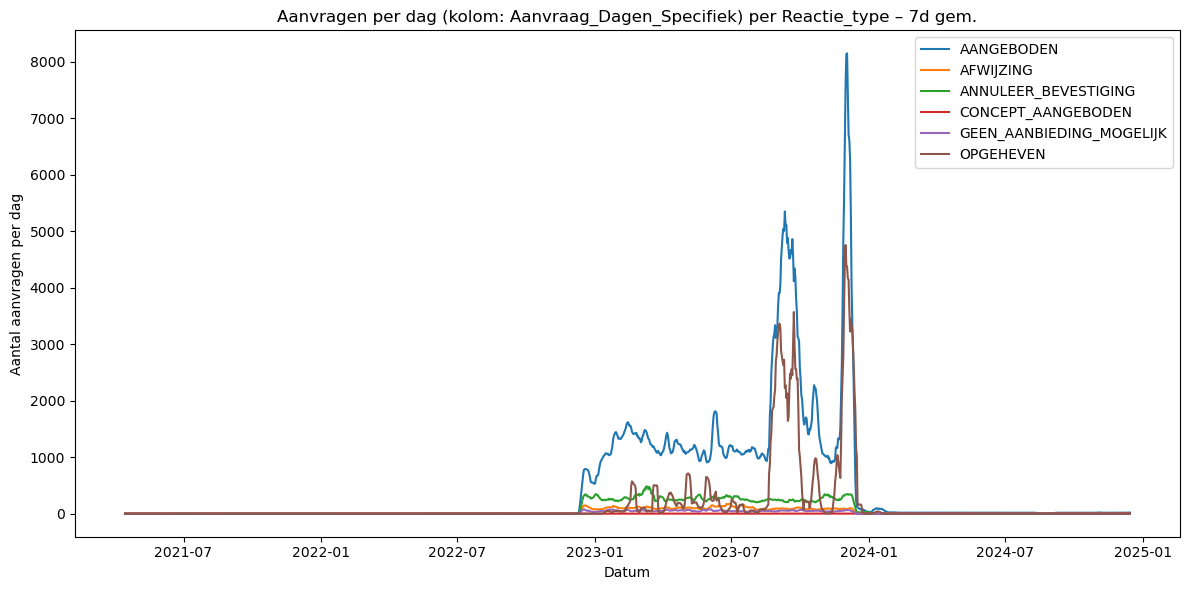

[✓] Figuur opgeslagen: C:\Users\quint\Downloads\viz_out\aanvraag_dagen_specifiek_per_reactie_type.png


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# =================== CONFIG ===================
CSV_PATH   = Path("orders_filtered_clean.csv")   # jouw grote bron-CSV
SEP        = ";"                                 # scheidingsteken
CHUNK      = 100_000                             # chunkgrootte voor streamen
TARGET_RT  = "Reactie_type"                      # klassedoel
DATE_CANDIDATES = [
    "Aanvraag_Dagen_Specifiek",
    "Aanvraag_dagen_specifiek",
    "aanvraag_dagen_specifiek",
]
DATE_ROLLING_WINDOW = 7                          # aantal dagen voor moving average (None = geen smoothing)
DATE_MIN, DATE_MAX = None, None                  # beperk optioneel: bv. "2023-01-01", "2023-12-31"
SAVE_PATH = Path("./viz_out/aanvraag_dagen_specifiek_per_reactie_type.png")
# ==============================================

SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)

# 1) Header lezen en juiste kolomnamen vinden
hdr = pd.read_csv(CSV_PATH, sep=SEP, nrows=0, low_memory=False)
# normaliseer alleen zichtbaar gebruik: strip '*' en spaties aan het einde/begin
hdr.columns = [c.lstrip("*").strip() if isinstance(c, str) else c for c in hdr.columns]

# vind de date kolom (case-insensitief)
date_col = None
hdr_lower = {c.lower(): c for c in hdr.columns}
for cand in DATE_CANDIDATES:
    if cand.lower() in hdr_lower:
        date_col = hdr_lower[cand.lower()]
        break

if date_col is None:
    raise RuntimeError(
        f"Kon kolom niet vinden (geprobeerd: {DATE_CANDIDATES}). "
        f"Beschikbare kolommen: {list(hdr.columns)[:10]} ..."
    )

if TARGET_RT not in hdr.columns:
    raise RuntimeError(f"Kolom '{TARGET_RT}' niet gevonden in {CSV_PATH}")

print(f"[Info] Gebruik kolommen: datum='{date_col}', klasse='{TARGET_RT}'")

# 2) Tellen per dag x Reactie_type (streamend)
parts = []  # we bewaren compacte tussenresultaten
usecols = [date_col, TARGET_RT]

for ch in pd.read_csv(CSV_PATH, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=usecols):
    # strip '*' eventueel in chunks (hoeft alleen als de header dat niet afdekt)
    ch.columns = [c.lstrip("*").strip() if isinstance(c, str) else c for c in ch.columns]

    # parse datum
    dt = pd.to_datetime(ch[date_col], errors="coerce")
    # we willen per kalenderdag (zonder tijd)
    day = dt.dt.floor("D")

    # normaliseer klassenaam
    cls = ch[TARGET_RT].astype("string").str.upper().str.strip()

    # filter niet-lege datums
    m = day.notna()
    if not m.any():
        continue

    df = pd.DataFrame({
        "day": day[m].to_numpy(),
        "cls": cls[m].to_numpy()
    })

    # tel records per (dag, klasse)
    cnt = df.value_counts(["day", "cls"]).rename("n").reset_index()
    parts.append(cnt)

if not parts:
    raise RuntimeError("Geen bruikbare rijen gevonden (alle datums leeg?).")

daily = pd.concat(parts, ignore_index=True)
daily = daily.groupby(["day", "cls"], as_index=False)["n"].sum()

# 3) Eventuele datumfilter
if DATE_MIN is not None:
    daily = daily[daily["day"] >= pd.to_datetime(DATE_MIN)]
if DATE_MAX is not None:
    daily = daily[daily["day"] <= pd.to_datetime(DATE_MAX)]

# 4) Pivot naar tijdreeks per klasse en resample naar dagelijks raster
#    (vult missende dagen met 0)
idx_all_days = pd.date_range(daily["day"].min(), daily["day"].max(), freq="D")
wide = (daily
        .pivot_table(index="day", columns="cls", values="n", aggfunc="sum", fill_value=0)
        .reindex(idx_all_days, fill_value=0)
        .sort_index())
wide.index.name = "day"

# 5) Optionele smoothing
plot_df = wide.copy()
if DATE_ROLLING_WINDOW and DATE_ROLLING_WINDOW > 1:
    plot_df = wide.rolling(window=DATE_ROLLING_WINDOW, min_periods=1, center=False).mean()

# 6) Plotten (lijn per Reactie_type)
plt.figure(figsize=(12, 6))
for col in plot_df.columns:
    plt.plot(plot_df.index, plot_df[col], label=str(col))  # geen specifieke kleuren instellen

plt.title(f"Aanvragen per dag (kolom: {date_col}) per {TARGET_RT}"
          + (f" – {DATE_ROLLING_WINDOW}d gem." if DATE_ROLLING_WINDOW else ""))
plt.xlabel("Datum")
plt.ylabel("Aantal aanvragen per dag")
plt.legend()
plt.tight_layout()
plt.savefig(SAVE_PATH, dpi=150)
plt.show()

print(f"[✓] Figuur opgeslagen: {SAVE_PATH.resolve()}")


In [30]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Maak ML-trainingsbestanden uit orders_filtered_clean.csv (groot bestand, RAM-vriendelijk):

- Gebruikt alleen aanvraag-kolommen (drop alle "lekkende" reactievelden).
- Target: y_offered = 1{Reactie_type == "AANGEBODEN"}, 0 anders (AFWIJZING / GEEN_AANBIEDING_MOGELIJK / ANNULEER_BEVESTIGING).
- Filtert rijen met onbekende/lege Reactie_type (target NA) uit.
- Tijdgebaseerde split (train/val/test) op Tijdstempel.
- Leest en schrijft in chunks naar CSV.

Aanpassen indien nodig:
  - IN_FILE / SEP
  - TIME_COL / TARGET_COL
  - SPLIT_TRAIN_END / SPLIT_VAL_END
"""

import pandas as pd
import numpy as np
from pathlib import Path

# ----------------- Instellingen -----------------
IN_FILE     = "orders_filtered_clean.csv"
SEP         = ";"                 # pas aan indien nodig
CHUNKSIZE   = 200_000
TIME_COL    = "Tijdstempel"       # kolom voor tijd-split
TARGET_COL  = "Reactie_type"      # bronveld target

# Splits (op basis van datum in TIME_COL)
SPLIT_TRAIN_END = "2024-12-31"    # t/m deze datum -> train
SPLIT_VAL_END   = "2025-06-30"    # (train_end, val_end] -> val; daarna test

# Uitvoer
OUT_DIR   = Path("./ml_ready")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_TRAIN = OUT_DIR / "train.csv"
OUT_VAL   = OUT_DIR / "val.csv"
OUT_TEST  = OUT_DIR / "test.csv"
OUT_FEATS = OUT_DIR / "features_used.txt"
OUT_LOG   = OUT_DIR / "prep_log.txt"

# ----------------- Leakage-kolommen (NIET gebruiken als features) -----------------
LEAK_COLUMNS = {
    "Status","Reactie_Variant","Reactie_Moment","Reactie_type","Reactie_Toelichting",
    "Reactie_Dienstregelingjaar","Reactie_Vervoerder_Afkorting","Reactie_Treinnummer",
    "Aanvraag_Verwerkingdagen_Aangebodendag",
    "Reactie_Eerste_Activiteit_Treintype","Reactie_Eerste_Activiteit_Rijkarakteristiek",
    "Reactie_Eerste_Activiteit_BVRegelingen","Reactie_Eerste_Activiteit_Materieelsoort",
    "Reactie_Eerste_Activiteit_Materieeltype","Reactie_Eerste_Activiteit_Tractievorm",
    "Reactie_Eerste_Activiteit_MaxLengte","Reactie_Eerste_Activiteit_MaxSnelheid",
    "Reactie_Eerste_Activiteit_Dienstregelingssnelheid","Reactie_Eerste_Activiteit_MaxGewicht",
    "Reactie_Eerste_Activiteit_Remstand","Reactie_Eerste_Activiteit_RemPercentage",
    "Reactie_Eerste_Activiteit_Belastingklasse","Reactie_Eerste_Activiteit_Profielcodes",
    "Reactie_Eerste_Activiteit_Toelichting","Reactie_Eerste_Activiteit_Dienstregelpunt",
    "Reactie_Eerste_Activiteit_DienstregelpuntSpoor","Reactie_Eerste_Activiteit_Treinactiviteit",
    "Reactie_Eerste_Activiteit_Tijdstip","Reactie_Eerste_Activiteit_Tijdstip_offset",
    "Reactie_Eerste_Activiteit_Opmerkingen",
    "Reactie_Laatste_Activiteit_Dienstregelpunt","Reactie_Laatste_Activiteit_DienstregelpuntSpoor",
    "Reactie_Laatste_Activiteit_Activiteitsoort","Reactie_Laatste_Activiteit_Tijdstip",
    "Reactie_Laatste_Activiteit_Tijdstip_Offset","Reactie_Laatste_Activiteit_Opmerkingen",
    "Reactie_Routelint",
    "IngeschatteUren","GespendeerdeUren","ResterendeUren",
    "Unnamed: 109",
}

# ----------------- Helpers -----------------
ALLOWED_CLASSES = {"AANGEBODEN","AFWIJZING","GEEN_AANBIEDING_MOGELIJK","ANNULEER_BEVESTIGING"}

def clean_col(name):
    return name.lstrip("*").strip() if isinstance(name, str) else name

def clean_cols(cols):
    return [clean_col(c) for c in cols]

def to_target_nullable(s: pd.Series) -> pd.Series:
    """Binaire target met NA's (Int8): 1 als AANGEBODEN, 0 voor andere ALLOWED, NA voor onbekend/lege."""
    ss = s.astype("string").str.strip().str.upper()
    ss = ss.where(ss.isin(ALLOWED_CLASSES), pd.NA)
    return (ss == "AANGEBODEN").astype("Int8")  # {1,0,<NA>}

def split_by_date(ts: pd.Series) -> pd.Series:
    """Return 'train'/'val'/'test' obv TIME_COL."""
    t = pd.to_datetime(ts, errors="coerce", utc=False, infer_datetime_format=True)
    train_end = pd.Timestamp(SPLIT_TRAIN_END)
    val_end   = pd.Timestamp(SPLIT_VAL_END)
    out = pd.Series(index=t.index, dtype="string")
    out[(t.notna()) & (t <= train_end)] = "train"
    out[(t.notna()) & (t >  train_end) & (t <= val_end)] = "val"
    out[(t.notna()) & (t >  val_end)] = "test"
    return out

# ----------------- Header & featurelijst bepalen -----------------
hdr = pd.read_csv(IN_FILE, sep=SEP, nrows=0, low_memory=False)
hdr.columns = clean_cols(hdr.columns)
all_cols = hdr.columns.tolist()

if TARGET_COL not in all_cols:
    raise RuntimeError(f"TARGET_COL '{TARGET_COL}' niet gevonden. Beschikbare kolommen: {all_cols[:40]} ...")
if TIME_COL not in all_cols:
    raise RuntimeError(f"TIME_COL '{TIME_COL}' niet gevonden. Beschikbare kolommen: {all_cols[:40]} ...")

# Leakage-kolommen die daadwerkelijk bestaan
present_leaks = sorted(list(set(LEAK_COLUMNS) & set(all_cols)))

# Features = alle kolommen minus leaks en minus target (TIME_COL houden we ook als feature; kan later worden afgeleid)
candidate_features = [c for c in all_cols if c not in present_leaks and c != TARGET_COL]
feature_cols = candidate_features  # behoud oorspronkelijke volgorde

# Kolommen die we per chunk nodig hebben
needed_cols = list(dict.fromkeys(feature_cols + [TARGET_COL, TIME_COL]))

# ----------------- Outputs initialiseren -----------------
for p in (OUT_TRAIN, OUT_VAL, OUT_TEST):
    if p.exists():
        p.unlink()

with open(OUT_FEATS, "w", encoding="utf-8") as f:
    f.write("# Features used (X)\n")
    for c in feature_cols:
        f.write(c + "\n")
    f.write("\n# Dropped leakage columns (present in data)\n")
    for c in present_leaks:
        f.write("- " + c + "\n")

# ----------------- Streamen en schrijven -----------------
flags = {"train": True, "val": True, "test": True}
counts_seen = 0
counts_written = {"train": 0, "val": 0, "test": 0}
counts_na_target = 0

reader = pd.read_csv(IN_FILE, sep=SEP, chunksize=CHUNKSIZE, usecols=needed_cols, low_memory=True)
for i, chunk in enumerate(reader, start=1):
    counts_seen += len(chunk)
    chunk.columns = clean_cols(chunk.columns)

    # Target bouwen (nullable) en rijen zonder geldige target droppen
    y_nullable = to_target_nullable(chunk[TARGET_COL])
    mask_have_target = y_nullable.notna()
    counts_na_target += int((~mask_have_target).sum())
    if not mask_have_target.any():
        if i % 10 == 0:
            print(f"[Chunk {i}] geen geldige targets; seen={counts_seen:,}")
        continue

    chunk = chunk.loc[mask_have_target].copy()
    chunk["y_offered"] = y_nullable.loc[mask_have_target].astype("int8")

    # Tijdsplit
    split = split_by_date(chunk[TIME_COL])

    # Voor elke subset wegschrijven
    for part, out_path in (("train", OUT_TRAIN), ("val", OUT_VAL), ("test", OUT_TEST)):
        mask = (split == part)
        if mask.any():
            out_df = chunk.loc[mask, feature_cols + ["y_offered"]]
            out_df.to_csv(
                out_path,
                sep=SEP,
                index=False,
                mode="w" if flags[part] else "a",
                header=flags[part]
            )
            flags[part] = False
            counts_written[part] += len(out_df)

    if i % 10 == 0:
        print(f"[Chunk {i}] seen={counts_seen:,}  written(train/val/test)=({counts_written['train']:,}/{counts_written['val']:,}/{counts_written['test']:,})")

# ----------------- Log -----------------
with open(OUT_LOG, "w", encoding="utf-8") as f:
    f.write(f"Input: {IN_FILE}\n")
    f.write(f"Separator: {SEP}\n")
    f.write(f"Chunksize: {CHUNKSIZE}\n")
    f.write(f"Time column: {TIME_COL}\n")
    f.write(f"Target column: {TARGET_COL}\n")
    f.write(f"Split train end: {SPLIT_TRAIN_END}, val end: {SPLIT_VAL_END}\n\n")
    f.write(f"Rows seen total: {counts_seen}\n")
    f.write(f"Rows dropped due to NA/unknown target: {counts_na_target}\n")
    f.write(f"Rows written train: {counts_written['train']}\n")
    f.write(f"Rows written val:   {counts_written['val']}\n")
    f.write(f"Rows written test:  {counts_written['test']}\n\n")
    f.write("Feature columns used:\n")
    for c in feature_cols:
        f.write(f"  - {c}\n")
    f.write("\nLeakage columns dropped (present):\n")
    for c in present_leaks:
        f.write(f"  - {c}\n")

print("\n[✓] Klaar.")
print(f"Geschreven rijen: train={counts_written['train']:,}, val={counts_written['val']:,}, test={counts_written['test']:,}")
print(f"Uitvoer in map: {OUT_DIR.resolve()}")


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\651022076.py:133: DtypeWarning: Columns (7,24,26,28,30,40,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader, start=1):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\651022076.py:84: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  t = pd.to_datetime(ts, errors="coerce", utc=False, infer_datetime_format=True)
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\651022076.py:133: DtypeWarning: Columns (40,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader, start=1):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\651022076.py:84: UserWarning: The argument 'infer_datetime_format' is deprecated an


[✓] Klaar.
Geschreven rijen: train=849,582, val=0, test=0
Uitvoer in map: C:\Users\quint\Downloads\ml_ready


In [31]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Maak ML-trainingsbestanden uit orders_filtered_clean.csv (groot bestand, RAM-vriendelijk):

- Drop alle 'lekkende' reactie-velden.
- Target: y_offered = 1{Reactie_type == 'AANGEBODEN'}, 0 anders; onbekende/lege targets worden gedropt.
- Tijd-split:
    1) Probeer vaste datums (t/m 2024-12-31; t/m 2025-06-30).
    2) Als val/test leeg zouden zijn, kies automatische cut-datums o.b.v. 70% / 85% tijd-percentielen.
    3) Als er praktisch geen datumbereik is, val terug op row-wise 70/15/15.
- Chunked I/O.

Logs schrijven de gekozen strategie en aantallen weg.
"""

import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter

# ----------------- Instellingen -----------------
IN_FILE     = "orders_filtered_clean.csv"
SEP         = ";"                 # pas aan indien nodig
CHUNKSIZE   = 200_000
TIME_COL    = "Tijdstempel"
TARGET_COL  = "Reactie_type"

# VASTE cut-datums (worden alleen gebruikt als ze zinvol zijn)
FIXED_TRAIN_END = pd.Timestamp("2024-12-31")
FIXED_VAL_END   = pd.Timestamp("2025-06-30")

# Uitvoer
OUT_DIR   = Path("./ml_ready")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_TRAIN = OUT_DIR / "train.csv"
OUT_VAL   = OUT_DIR / "val.csv"
OUT_TEST  = OUT_DIR / "test.csv"
OUT_FEATS = OUT_DIR / "features_used.txt"
OUT_LOG   = OUT_DIR / "prep_log.txt"

# ----------------- Leakage-kolommen (niet als features gebruiken) -----------------
LEAK_COLUMNS = {
    "Reactie_Variant","Reactie_Moment","Reactie_type","Reactie_Toelichting",
    "Reactie_Dienstregelingjaar","Reactie_Vervoerder_Afkorting","Reactie_Treinnummer",
    "Aanvraag_Verwerkingdagen_Aangebodendag",
    "Reactie_Eerste_Activiteit_Treintype","Reactie_Eerste_Activiteit_Rijkarakteristiek",
    "Reactie_Eerste_Activiteit_BVRegelingen","Reactie_Eerste_Activiteit_Materieelsoort",
    "Reactie_Eerste_Activiteit_Materieeltype","Reactie_Eerste_Activiteit_Tractievorm",
    "Reactie_Eerste_Activiteit_MaxLengte","Reactie_Eerste_Activiteit_MaxSnelheid",
    "Reactie_Eerste_Activiteit_Dienstregelingssnelheid","Reactie_Eerste_Activiteit_MaxGewicht",
    "Reactie_Eerste_Activiteit_Remstand","Reactie_Eerste_Activiteit_RemPercentage",
    "Reactie_Eerste_Activiteit_Belastingklasse","Reactie_Eerste_Activiteit_Profielcodes",
    "Reactie_Eerste_Activiteit_Toelichting","Reactie_Eerste_Activiteit_Dienstregelpunt",
    "Reactie_Eerste_Activiteit_DienstregelpuntSpoor","Reactie_Eerste_Activiteit_Treinactiviteit",
    "Reactie_Eerste_Activiteit_Tijdstip","Reactie_Eerste_Activiteit_Tijdstip_offset",
    "Reactie_Eerste_Activiteit_Opmerkingen",
    "Reactie_Laatste_Activiteit_Dienstregelpunt","Reactie_Laatste_Activiteit_DienstregelpuntSpoor",
    "Reactie_Laatste_Activiteit_Activiteitsoort","Reactie_Laatste_Activiteit_Tijdstip",
    "Reactie_Laatste_Activiteit_Tijdstip_Offset","Reactie_Laatste_Activiteit_Opmerkingen",
    "Reactie_Routelint",
    "IngeschatteUren","GespendeerdeUren","ResterendeUren",
    "Unnamed: 109",
}

ALLOWED_CLASSES = {"AANGEBODEN","AFWIJZING","GEEN_AANBIEDING_MOGELIJK","ANNULEER_BEVESTIGING"}

# ----------------- Helpers -----------------
def clean_col(name):
    return name.lstrip("*").strip() if isinstance(name, str) else name

def clean_cols(cols):
    return [clean_col(c) for c in cols]

def to_target_nullable(s: pd.Series) -> pd.Series:
    """Binaire target met NA's (Int8): 1 als AANGEBODEN, 0 voor andere ALLOWED, NA voor onbekend/lege."""
    ss = s.astype("string").str.strip().str.upper()
    ss = ss.where(ss.isin(ALLOWED_CLASSES), pd.NA)
    return (ss == "AANGEBODEN").astype("Int8")  # {1,0,<NA>}

def parse_time(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, errors="coerce", utc=False, infer_datetime_format=True)

def compute_quantile_cuts(daily_counts: dict, q_train=0.70, q_val=0.85):
    """Bepaal datum-cuts op basis van cumulatieve dagtellingen."""
    if not daily_counts:
        return None, None
    items = sorted(daily_counts.items())  # (date, count)
    dates = [pd.Timestamp(k) for k, _ in items]
    counts = np.array([v for _, v in items], dtype=np.int64)
    total = counts.sum()
    if total == 0:
        return None, None
    cum = counts.cumsum()
    cut1 = dates[int(np.searchsorted(cum, total * q_train, side="left"))]
    cut2 = dates[int(np.searchsorted(cum, total * q_val,   side="left"))]
    if cut2 < cut1:
        cut2 = cut1
    return cut1, cut2

# ----------------- Header & featurelijst -----------------
hdr = pd.read_csv(IN_FILE, sep=SEP, nrows=0, low_memory=False)
hdr.columns = clean_cols(hdr.columns)
all_cols = hdr.columns.tolist()

if TARGET_COL not in all_cols:
    raise RuntimeError(f"TARGET_COL '{TARGET_COL}' niet gevonden. Beschikbare kolommen: {all_cols[:40]} ...")
if TIME_COL not in all_cols:
    raise RuntimeError(f"TIME_COL '{TIME_COL}' niet gevonden. Beschikbare kolommen: {all_cols[:40]} ...")

present_leaks = sorted(list(set(LEAK_COLUMNS) & set(all_cols)))
candidate_features = [c for c in all_cols if c not in present_leaks and c != TARGET_COL]
feature_cols = candidate_features  # TIME_COL blijft erin; later kun je er kalenderfeatures uit afleiden
needed_cols_scan = [TARGET_COL, TIME_COL]  # Pass A: minimaal nodig
needed_cols_write = list(dict.fromkeys(feature_cols + [TARGET_COL, TIME_COL]))

# ----------------- PASS A: Scan voor datumverdeling & strategie -----------------
daily = Counter()
total_seen = 0
total_valid_target = 0

readerA = pd.read_csv(IN_FILE, sep=SEP, chunksize=CHUNKSIZE, usecols=needed_cols_scan, low_memory=True)
for i, ch in enumerate(readerA, start=1):
    total_seen += len(ch)
    ch.columns = clean_cols(ch.columns)

    y_nullable = to_target_nullable(ch[TARGET_COL])
    mask = y_nullable.notna()
    if not mask.any():
        continue

    total_valid_target += int(mask.sum())
    t = parse_time(ch.loc[mask, TIME_COL])
    d = t.dt.floor("D").dropna()
    vc = d.value_counts()
    for k, v in vc.items():
        daily[str(pd.to_datetime(k).date())] += int(v)

# vaste datums evalueren
def apply_fixed_counts(daily_counts):
    train = val = test = 0
    for ds, c in daily_counts.items():
        d = pd.Timestamp(ds)
        if d <= FIXED_TRAIN_END:
            train += c
        elif d <= FIXED_VAL_END:
            val += c
        else:
            test += c
    return train, val, test

fixed_train, fixed_val, fixed_test = apply_fixed_counts(daily)

# Kies strategie
strategy = None
cut_train = None
cut_val = None
rowwise_thresholds = None  # (n_train, n_val) absolute aantallen als row-wise fallback
total_valid = sum(daily.values())

if total_valid == 0:
    raise RuntimeError("Geen rijen met geldige target gevonden na scan; check Reactie_type waarden.")

if fixed_val > 0 or fixed_test > 0:
    # vaste datums leveren bruikbare splits
    strategy = "fixed"
    cut_train = FIXED_TRAIN_END
    cut_val   = FIXED_VAL_END
else:
    # probeer percentiel-cuts
    q_train, q_val = compute_quantile_cuts(daily, 0.70, 0.85)
    if q_train is not None and q_val is not None and q_val >= q_train:
        strategy = "quantiles"
        cut_train = q_train
        cut_val   = q_val
    else:
        # laatste redmiddel: row-wise 70/15/15 (volgorde zoals in bestand)
        strategy = "rowwise"
        n_train = int(round(total_valid * 0.70))
        n_val   = int(round(total_valid * 0.15))
        rowwise_thresholds = (n_train, n_val)

# ----------------- Outputs initialiseren -----------------
for p in (OUT_TRAIN, OUT_VAL, OUT_TEST):
    if p.exists():
        p.unlink()

with open(OUT_FEATS, "w", encoding="utf-8") as f:
    f.write("# Features used (X)\n")
    for c in feature_cols:
        f.write(c + "\n")
    f.write("\n# Dropped leakage columns (present)\n")
    for c in present_leaks:
        f.write("- " + c + "\n")

# ----------------- PASS B: Schrijven -----------------
flags = {"train": True, "val": True, "test": True}
written = {"train": 0, "val": 0, "test": 0}
na_target_dropped = 0
rowwise_written = 0  # voor row-wise strategie

readerB = pd.read_csv(IN_FILE, sep=SEP, chunksize=CHUNKSIZE, usecols=needed_cols_write, low_memory=True)
for j, ch in enumerate(readerB, start=1):
    ch.columns = clean_cols(ch.columns)

    y_nullable = to_target_nullable(ch[TARGET_COL])
    mask = y_nullable.notna()
    na_target_dropped += int((~mask).sum())
    if not mask.any():
        continue

    ch = ch.loc[mask].copy()
    ch["y_offered"] = y_nullable.loc[mask].astype("int8")

    if strategy in {"fixed", "quantiles"}:
        t = parse_time(ch[TIME_COL])
        part = pd.Series(index=ch.index, dtype="string")
        part[t <= cut_train] = "train"
        part[(t > cut_train) & (t <= cut_val)] = "val"
        part[t > cut_val] = "test"
    else:
        # row-wise: 70/15/15 over het totaal (met geldige target), in volgorde
        n_train, n_val = rowwise_thresholds
        idx = ch.index
        start = rowwise_written
        end = start + len(ch)
        # bepaal segment-assignments voor dit chunkbereik
        assign = []
        for k in range(start, end):
            if k < n_train:
                assign.append("train")
            elif k < n_train + n_val:
                assign.append("val")
            else:
                assign.append("test")
        part = pd.Series(assign, index=idx, dtype="string")
        rowwise_written = end

    for name, outp in (("train", OUT_TRAIN), ("val", OUT_VAL), ("test", OUT_TEST)):
        m = (part == name)
        if m.any():
            out_df = ch.loc[m, feature_cols + ["y_offered"]]
            out_df.to_csv(outp, sep=SEP, index=False, mode="w" if flags[name] else "a", header=flags[name])
            flags[name] = False
            written[name] += len(out_df)

# ----------------- LOG -----------------
with open(OUT_LOG, "w", encoding="utf-8") as f:
    f.write(f"Input: {IN_FILE}\n")
    f.write(f"Separator: {SEP}\n")
    f.write(f"Chunksize: {CHUNKSIZE}\n")
    f.write(f"Time column: {TIME_COL}\n")
    f.write(f"Target column: {TARGET_COL}\n\n")

    f.write("Strategy: " + strategy + "\n")
    if strategy in {"fixed", "quantiles"}:
        f.write(f"cut_train_end: {cut_train}\n")
        f.write(f"cut_val_end:   {cut_val}\n")
        f.write(f"Fixed split counts (scan): train={fixed_train}, val={fixed_val}, test={fixed_test}\n")
    else:
        n_train, n_val = rowwise_thresholds
        f.write(f"rowwise thresholds (counts): train_first={n_train}, val_next={n_val}\n")

    f.write(f"\nRows seen (with valid target only, scan): {total_valid}\n")
    f.write(f"Rows dropped due to NA/unknown target (write): {na_target_dropped}\n")
    f.write(f"Written: train={written['train']}, val={written['val']}, test={written['test']}\n")

    f.write("\nFeature columns used:\n")
    for c in feature_cols:
        f.write(f"  - {c}\n")
    f.write("\nLeakage columns dropped (present):\n")
    for c in present_leaks:
        f.write(f"  - {c}\n")

print(f"[✓] Klaar. Strategy={strategy}. Geschreven rijen: train={written['train']:,}, val={written['val']:,}, test={written['test']:,}")
print(f"Cut datums (indien gebruikt): train_end={cut_train}, val_end={cut_val}")
print(f"Uitvoer in map: {OUT_DIR.resolve()}")


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\2482630790.py:83: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors="coerce", utc=False, infer_datetime_format=True)
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\2482630790.py:83: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors="coerce", utc=False, infer_datetime_format=True)
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\2482630790.py:83: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version.

[✓] Klaar. Strategy=quantiles. Geschreven rijen: train=593,780, val=124,129, test=131,673
Cut datums (indien gebruikt): train_end=2023-09-22 00:00:00, val_end=2023-11-10 00:00:00
Uitvoer in map: C:\Users\quint\Downloads\ml_ready


In [34]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Train a streaming binary classifier to predict P(Reactie_type == 'AANGEBODEN').

Fix: partial_fit doesn't support class_weight='balanced'.
We pre-scan train to compute class weights and pass them as sample_weight.

Inputs:
  ./ml_ready/train.csv (features + y_offered)
  ./ml_ready/val.csv
  ./ml_ready/test.csv

Outputs:
  ./ml_ready/offered_model.joblib
  ./ml_ready/offered_model_card.json
"""

from pathlib import Path
import json
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import SGDClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss, roc_auc_score, average_precision_score
from joblib import dump

# ----------------- Config -----------------
DATA_DIR   = Path("./ml_ready")
TRAIN_PATH = DATA_DIR / "train.csv"
VAL_PATH   = DATA_DIR / "val.csv"
TEST_PATH  = DATA_DIR / "test.csv"
SEP        = ";"            # adjust if needed
CHUNK      = 200_000
HASH_BITS  = 18             # 2**18 hashed features for categoricals
TARGET     = "y_offered"

MODEL_PATH = DATA_DIR / "offered_model.joblib"
CARD_PATH  = DATA_DIR / "offered_model_card.json"

# ----------------- Robust schema & vectorization -----------------
def robust_infer_coltypes(df: pd.DataFrame, target_col: str, sample_rows: int = 5000,
                          numeric_threshold: float = 0.9):
    cols = [c for c in df.columns if c != target_col]
    num_cols, cat_cols = [], []
    for c in cols:
        s = df[c]
        if pd.api.types.is_numeric_dtype(s) or pd.api.types.is_bool_dtype(s):
            num_cols.append(c); continue
        sample = s.dropna().astype("string").head(sample_rows)
        if sample.empty:
            cat_cols.append(c); continue
        coerced = pd.to_numeric(sample, errors="coerce")
        if coerced.notna().mean() >= numeric_threshold:
            num_cols.append(c)
        else:
            cat_cols.append(c)
    return num_cols, cat_cols

def build_sparse_X(df: pd.DataFrame, num_cols, cat_cols, hasher: FeatureHasher):
    blocks = []
    if cat_cols:
        dicts = (
            df[cat_cols]
            .astype("string")
            .where(lambda s: s.notna(), other="__NA__")
            .to_dict(orient="records")
        )
        Xc = hasher.transform(dicts)
        blocks.append(Xc)
    if num_cols:
        num_df = df[num_cols].apply(pd.to_numeric, errors="coerce")
        miss = num_df.isna().astype(np.uint8)
        num_df = num_df.fillna(0.0)
        Xn = sparse.csr_matrix(num_df.to_numpy(dtype=np.float32), dtype=np.float32)
        Xm = sparse.csr_matrix(miss.to_numpy(dtype=np.float32), dtype=np.float32)
        blocks.extend([Xn, Xm])
    if not blocks:
        return sparse.csr_matrix((len(df), 0), dtype=np.float32)
    return sparse.hstack(blocks, format="csr", dtype=np.float32)

def chunk_reader(path: Path, usecols=None):
    return pd.read_csv(path, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=usecols)

# ----------------- Check inputs -----------------
if not TRAIN_PATH.exists() or not VAL_PATH.exists() or not TEST_PATH.exists():
    raise FileNotFoundError("Missing one of train.csv / val.csv / test.csv in ./ml_ready")

sample = pd.read_csv(TRAIN_PATH, sep=SEP, nrows=10000, low_memory=False)
if TARGET not in sample.columns:
    raise RuntimeError(f"TARGET '{TARGET}' not found in train.csv")

# Infer types robustly
num_cols, cat_cols = robust_infer_coltypes(sample, TARGET, sample_rows=5000, numeric_threshold=0.9)
num_cols = [c for c in num_cols if c != TARGET]
cat_cols = [c for c in cat_cols if c != TARGET]
hasher = FeatureHasher(n_features=2**HASH_BITS, input_type="dict", alternate_sign=False)

# ----------------- Pre-scan to get class weights -----------------
class_counts = np.zeros(2, dtype=np.int64)  # [count_0, count_1]
usecols_labels = [TARGET]
for ch in chunk_reader(TRAIN_PATH, usecols=usecols_labels):
    y = ch[TARGET].astype("int8").to_numpy()
    # Ensure only 0/1
    y = np.clip(y, 0, 1)
    class_counts[0] += int((y == 0).sum())
    class_counts[1] += int((y == 1).sum())

total = class_counts.sum()
if total == 0:
    raise RuntimeError("No training rows found.")

# Inverse-frequency weights: w_c = N / (K * n_c)
K = 2
class_weights = np.zeros(2, dtype=np.float64)
for c in (0, 1):
    class_weights[c] = (total / (K * class_counts[c])) if class_counts[c] > 0 else 1.0

print(f"Class counts (train): 0={class_counts[0]}, 1={class_counts[1]}")
print(f"Class weights used:   w0={class_weights[0]:.4f}, w1={class_weights[1]:.4f}")

# ----------------- Train SGD (streaming) with sample_weight -----------------
clf = SGDClassifier(
    loss="log_loss",
    max_iter=1,
    learning_rate="optimal",
    random_state=42,
)

classes = np.array([0, 1], dtype=np.int64)
first_batch = True
seen_rows = 0
usecols_train = list(set(num_cols + cat_cols + [TARGET]))

for ch in chunk_reader(TRAIN_PATH, usecols=usecols_train):
    y = ch[TARGET].astype("int8").to_numpy()
    y = np.clip(y, 0, 1)
    X = build_sparse_X(ch, num_cols, cat_cols, hasher)
    # per-sample weights based on class
    sw = np.where(y == 1, class_weights[1], class_weights[0]).astype(np.float64)
    if first_batch:
        clf.partial_fit(X, y, classes=classes, sample_weight=sw)
        first_batch = False
    else:
        clf.partial_fit(X, y, sample_weight=sw)
    seen_rows += len(ch)

# ----------------- Calibrate on validation (isotonic) -----------------
val_scores, val_labels = [], []
usecols_val = list(set(num_cols + cat_cols + [TARGET]))
for ch in chunk_reader(VAL_PATH, usecols=usecols_val):
    y = ch[TARGET].astype("int8").to_numpy()
    y = np.clip(y, 0, 1)
    X = build_sparse_X(ch, num_cols, cat_cols, hasher)
    p = clf.predict_proba(X)[:, 1]
    val_scores.append(p); val_labels.append(y)

# Fallback if val empty: sample from train
if not val_scores:
    for ch in chunk_reader(TRAIN_PATH, usecols=usecols_train):
        y = ch[TARGET].astype("int8").to_numpy()
        y = np.clip(y, 0, 1)
        X = build_sparse_X(ch, num_cols, cat_cols, hasher)
        p = clf.predict_proba(X)[:, 1]
        val_scores.append(p); val_labels.append(y)
        if sum(arr.size for arr in val_labels) > 200_000:
            break

val_scores = np.concatenate(val_scores)
val_labels = np.concatenate(val_labels)

cal = IsotonicRegression(out_of_bounds="clip")
cal.fit(val_scores, val_labels)

def calibrate(p):
    return cal.transform(p)

# ----------------- Evaluate (val & test) -----------------
def evaluate_csv(path: Path, label="val"):
    usec = list(set(num_cols + cat_cols + [TARGET]))
    y_true_all, p_cal_all = [], []
    for ch in chunk_reader(path, usecols=usec):
        y = ch[TARGET].astype("int8").to_numpy()
        y = np.clip(y, 0, 1)
        X = build_sparse_X(ch, num_cols, cat_cols, hasher)
        p = clf.predict_proba(X)[:, 1]
        p_cal = calibrate(p)
        y_true_all.append(y); p_cal_all.append(p_cal)
    if not y_true_all:
        return {"label": label, "n": 0}
    y_true = np.concatenate(y_true_all)
    p_cal = np.concatenate(p_cal_all)
    return {
        "label": label,
        "n": int(y_true.size),
        "brier": float(brier_score_loss(y_true, p_cal)),
        "roc_auc": float(roc_auc_score(y_true, p_cal)) if len(np.unique(y_true)) > 1 else None,
        "pr_auc": float(average_precision_score(y_true, p_cal)) if len(np.unique(y_true)) > 1 else None,
        "pos_rate": float(y_true.mean()),
        "p_mean": float(p_cal.mean()),
    }

val_metrics  = evaluate_csv(VAL_PATH,  "val")
test_metrics = evaluate_csv(TEST_PATH, "test")
print("Validation:", val_metrics)
print("Test:      ", test_metrics)

# ----------------- Save model -----------------
artifact = {
    "model_type": "SGDClassifier(log_loss)+IsotonicCalibration",
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "hash_bits": HASH_BITS,
    "clf": clf,
    "calibrator": cal,
    "target": TARGET,
    "sep": SEP,
}
dump(artifact, MODEL_PATH)
print(f"[✓] Saved model to {MODEL_PATH}")

card = {
    "schema": {
        "target": TARGET,
        "num_cols": num_cols,
        "cat_cols": cat_cols,
        "hash_bits": HASH_BITS,
    },
    "metrics": {"val": val_metrics, "test": test_metrics},
    "training": {"train_rows_seen": int(seen_rows), "chunk_size": CHUNK,
                 "class_counts": {"0": int(class_counts[0]), "1": int(class_counts[1])},
                 "class_weights": {"0": float(class_weights[0]), "1": float(class_weights[1])}},
}
with open(CARD_PATH, "w", encoding="utf-8") as f:
    json.dump(card, f, indent=2)
print(f"[i] Wrote model card to {CARD_PATH}")


Class counts (train): 0=121046, 1=472734
Class weights used:   w0=2.4527, w1=0.6280


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\4040782790.py:138: DtypeWarning: Columns (24,26,28,30,40,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in chunk_reader(TRAIN_PATH, usecols=usecols_train):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\4040782790.py:138: DtypeWarning: Columns (52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in chunk_reader(TRAIN_PATH, usecols=usecols_train):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\4040782790.py:138: DtypeWarning: Columns (40,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in chunk_reader(TRAIN_PATH, usecols=usecols_train):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\4040782790.py:154: DtypeWarning: Columns (26,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in chunk_reader(VAL_PATH, usecols=usecols_val):
C:\Users\quint\AppData\Local\Temp\ipykernel_315

Validation: {'label': 'val', 'n': 124129, 'brier': 0.14243614480849384, 'roc_auc': 0.5, 'pr_auc': 0.8279692900128093, 'pos_rate': 0.8279692900128093, 'p_mean': 0.8279692900128096}
Test:       {'label': 'test', 'n': 131673, 'brier': 0.10457719264632973, 'roc_auc': 0.5, 'pr_auc': 0.8856865112817358, 'pos_rate': 0.8856865112817358, 'p_mean': 0.8279692900128096}
[✓] Saved model to ml_ready\offered_model.joblib
[i] Wrote model card to ml_ready\offered_model_card.json


In [35]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Evaluate P(AANGEBODEN) model on test (and optionally val) in ./ml_ready/.

Reads chunk-wise; produces metrics + plots + decile table.

Inputs:
  ./ml_ready/offered_model.joblib
  ./ml_ready/test.csv  (must contain target column y_offered)
  ./ml_ready/val.csv   (optional)

Outputs in ./ml_ready/:
  eval_test_metrics.json
  eval_val_metrics.json (if val exists)
  roc_curve_test.png
  pr_curve_test.png
  calibration_curve_test.png
  deciles_test.csv
  threshold_cm_test.csv  (confusion at thresholds 0.2,0.5,0.8)
"""

from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load
from sklearn.metrics import (
    brier_score_loss, roc_auc_score, average_precision_score,
    log_loss, precision_recall_curve, roc_curve, confusion_matrix
)
from sklearn.calibration import calibration_curve

# ---------- Config ----------
DATA_DIR   = Path("./ml_ready")
MODEL_PATH = DATA_DIR / "offered_model.joblib"
TEST_PATH  = DATA_DIR / "test.csv"
VAL_PATH   = DATA_DIR / "val.csv"
SEP        = ";"             # pas aan indien nodig
CHUNK      = 200_000
TARGET     = "y_offered"

# ---------- Load model artifact ----------
if not MODEL_PATH.exists():
    raise FileNotFoundError(MODEL_PATH)
artifact = load(MODEL_PATH)
clf = artifact["clf"]
cal = artifact["calibrator"]
num_cols = artifact["num_cols"]
cat_cols = artifact["cat_cols"]
HASH_BITS = artifact["hash_bits"]
sep_model = artifact.get("sep", SEP)  # keep the same separator used in training

from sklearn.feature_extraction import FeatureHasher
from scipy import sparse
hasher = FeatureHasher(n_features=2**HASH_BITS, input_type="dict", alternate_sign=False)

def build_sparse_X(df: pd.DataFrame, num_cols, cat_cols, hasher):
    blocks = []
    if cat_cols:
        dicts = (
            df[cat_cols]
            .astype("string")
            .where(lambda s: s.notna(), other="__NA__")
            .to_dict(orient="records")
        )
        Xc = hasher.transform(dicts)
        blocks.append(Xc)
    if num_cols:
        num_df = df[num_cols].apply(pd.to_numeric, errors="coerce")
        miss = num_df.isna().astype(np.uint8)
        num_df = num_df.fillna(0.0)
        from scipy import sparse
        Xn = sparse.csr_matrix(num_df.to_numpy(dtype=np.float32), dtype=np.float32)
        Xm = sparse.csr_matrix(miss.to_numpy(dtype=np.float32), dtype=np.float32)
        blocks.extend([Xn, Xm])
    if not blocks:
        return sparse.csr_matrix((len(df), 0), dtype=np.float32)
    return sparse.hstack(blocks, format="csr", dtype=np.float32)

def chunk_reader(path: Path, usecols=None):
    return pd.read_csv(path, sep=sep_model, chunksize=CHUNK, low_memory=True, usecols=usecols)

def collect_probs_and_labels(csv_path: Path):
    usecols = list(set(num_cols + cat_cols + [TARGET]))
    y_all, p_all = [], []
    for ch in chunk_reader(csv_path, usecols=usecols):
        y = ch[TARGET].astype("int8").to_numpy()
        X = build_sparse_X(ch, num_cols, cat_cols, hasher)
        p_raw = clf.predict_proba(X)[:, 1]
        p = cal.transform(p_raw)
        y_all.append(y); p_all.append(p)
    if not y_all:
        return None, None
    return np.concatenate(y_all), np.concatenate(p_all)

def evaluate(y_true, p):
    res = {
        "n": int(y_true.size),
        "pos_rate": float(y_true.mean()) if y_true.size else None,
        "p_mean": float(np.mean(p)) if y_true.size else None,
        "brier": float(brier_score_loss(y_true, p)) if y_true.size else None,
        "roc_auc": float(roc_auc_score(y_true, p)) if len(np.unique(y_true)) > 1 else None,
        "pr_auc": float(average_precision_score(y_true, p)) if len(np.unique(y_true)) > 1 else None,
        "log_loss": float(log_loss(y_true, np.c_[1-p, p])) if y_true.size else None,
    }
    return res

def plot_roc_pr_calibration(y_true, p, prefix: str):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, p)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle="--")
    plt.title(f"ROC curve – {prefix}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.tight_layout()
    plt.savefig(DATA_DIR / f"roc_curve_{prefix}.png", dpi=150)
    plt.close()

    # PR
    prec, rec, _ = precision_recall_curve(y_true, p)
    plt.figure()
    plt.plot(rec, prec)
    plt.title(f"Precision–Recall – {prefix}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.tight_layout()
    plt.savefig(DATA_DIR / f"pr_curve_{prefix}.png", dpi=150)
    plt.close()

    # Calibration
    frac_pos, mean_pred = calibration_curve(y_true, p, n_bins=20, strategy="quantile")
    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title(f"Calibration curve – {prefix}")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.tight_layout()
    plt.savefig(DATA_DIR / f"calibration_curve_{prefix}.png", dpi=150)
    plt.close()

def confusion_at_thresholds(y_true, p, thresholds=(0.2, 0.5, 0.8)):
    rows = []
    for thr in thresholds:
        y_hat = (p >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0,1]).ravel()
        precision = tp / (tp + fp) if (tp+fp) else None
        recall = tp / (tp + fn) if (tp+fn) else None
        rows.append({
            "threshold": thr, "tp": int(tp), "fp": int(fp),
            "tn": int(tn), "fn": int(fn),
            "precision": precision, "recall": recall,
        })
    return pd.DataFrame(rows)

def decile_table(y_true, p):
    df = pd.DataFrame({"y": y_true, "p": p})
    df = df.sort_values("p", ascending=False).reset_index(drop=True)
    n = len(df)
    df["decile"] = (np.floor(np.arange(n) / max(1, n/10))).astype(int) + 1
    tbl = df.groupby("decile").agg(
        rows=("y","size"),
        positives=("y","sum"),
        avg_p=("p","mean")
    ).reset_index()
    tbl["cum_rows"] = tbl["rows"].cumsum()
    tbl["cum_positives"] = tbl["positives"].cumsum()
    overall_rate = df["y"].mean() if n else 0
    tbl["lift"] = (tbl["positives"] / tbl["rows"]) / overall_rate if overall_rate>0 else np.nan
    return tbl

# ---------- Evaluate TEST ----------
if not TEST_PATH.exists():
    raise FileNotFoundError(TEST_PATH)

y_test, p_test = collect_probs_and_labels(TEST_PATH)
if y_test is None:
    raise RuntimeError("No data read from test.csv. Check columns and separator.")

metrics_test = evaluate(y_test, p_test)
with open(DATA_DIR / "eval_test_metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics_test, f, indent=2)
print("Test metrics:", metrics_test)

plot_roc_pr_calibration(y_test, p_test, prefix="test")

cm_df = confusion_at_thresholds(y_test, p_test, thresholds=(0.2, 0.5, 0.8))
cm_df.to_csv(DATA_DIR / "threshold_cm_test.csv", index=False)
print("Confusion @ thresholds saved -> threshold_cm_test.csv")

dec = decile_table(y_test, p_test)
dec.to_csv(DATA_DIR / "deciles_test.csv", index=False)
print("Decile table saved -> deciles_test.csv")

# ---------- Evaluate VAL (optional) ----------
if VAL_PATH.exists():
    y_val, p_val = collect_probs_and_labels(VAL_PATH)
    if y_val is not None:
        metrics_val = evaluate(y_val, p_val)
        with open(DATA_DIR / "eval_val_metrics.json", "w", encoding="utf-8") as f:
            json.dump(metrics_val, f, indent=2)
        print("Val metrics:", metrics_val)
        plot_roc_pr_calibration(y_val, p_val, prefix="val")


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3899242701.py:89: DtypeWarning: Columns (18,26,40,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in chunk_reader(csv_path, usecols=usecols):


Test metrics: {'n': 131673, 'pos_rate': 0.8856865112817358, 'p_mean': 0.8279692900128096, 'brier': 0.10457719264632973, 'roc_auc': 0.5, 'pr_auc': 0.8856865112817358, 'log_loss': 0.3684003489237402}
Confusion @ thresholds saved -> threshold_cm_test.csv
Decile table saved -> deciles_test.csv


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3899242701.py:89: DtypeWarning: Columns (26,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in chunk_reader(csv_path, usecols=usecols):


Val metrics: {'n': 124129, 'pos_rate': 0.8279692900128093, 'p_mean': 0.8279692900128096, 'brier': 0.14243614480849384, 'roc_auc': 0.5, 'pr_auc': 0.8279692900128093, 'log_loss': 0.4590915951467563}


In [36]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Neem 30 random rijen uit test.csv, scoreer met het offered-model,
en schrijf naar ./ml_ready/test_sample_scored.csv
"""

from pathlib import Path
import numpy as np
import pandas as pd
from joblib import load
from sklearn.feature_extraction import FeatureHasher
from scipy import sparse

# ---------------- Config ----------------
DATA_DIR   = Path("./ml_ready")
TEST_PATH  = DATA_DIR / "test.csv"
MODEL_PATH = DATA_DIR / "offered_model.joblib"
OUT_CSV    = DATA_DIR / "test_sample_scored.csv"

SAMPLE_SIZE = 30
CHUNK       = 200_000  # pas aan indien nodig
RANDOM_SEED = 42

# -------------- Load model --------------
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model niet gevonden: {MODEL_PATH}")
artifact = load(MODEL_PATH)

clf       = artifact["clf"]
cal       = artifact["calibrator"]
num_cols  = artifact["num_cols"]
cat_cols  = artifact["cat_cols"]
HASH_BITS = artifact["hash_bits"]
SEP       = artifact.get("sep", ";")
TARGET    = artifact.get("target", "y_offered")  # staat op y_offered

hasher = FeatureHasher(n_features=2**HASH_BITS, input_type="dict", alternate_sign=False)
rng = np.random.default_rng(RANDOM_SEED)

# -------------- Helpers -----------------
def build_sparse_X(df: pd.DataFrame, num_cols, cat_cols, hasher: FeatureHasher):
    blocks = []
    # Categorical -> hashed
    if cat_cols:
        dicts = (
            df[cat_cols]
            .astype("string")
            .where(lambda s: s.notna(), other="__NA__")
            .to_dict(orient="records")
        )
        Xc = hasher.transform(dicts)
        blocks.append(Xc)
    # Numeric (+ missing flags)
    if num_cols:
        num_df = df[num_cols].apply(pd.to_numeric, errors="coerce")
        miss = num_df.isna().astype(np.uint8)
        num_df = num_df.fillna(0.0)
        Xn = sparse.csr_matrix(num_df.to_numpy(dtype=np.float32), dtype=np.float32)
        Xm = sparse.csr_matrix(miss.to_numpy(dtype=np.float32), dtype=np.float32)
        blocks.extend([Xn, Xm])
    if not blocks:
        return sparse.csr_matrix((len(df), 0), dtype=np.float32)
    return sparse.hstack(blocks, format="csr", dtype=np.float32)

def chunk_reader(path: Path, usecols=None):
    return pd.read_csv(path, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=usecols)

# -------------- Reservoir sampling over test.csv --------------
if not TEST_PATH.exists():
    raise FileNotFoundError(f"Testbestand niet gevonden: {TEST_PATH}")

# We hebben alleen de featurekolommen nodig (en target is optioneel voor referentie)
usecols = list(set(num_cols + cat_cols + [TARGET]))

reservoir = None   # DataFrame met max SAMPLE_SIZE rijen
seen = 0

for chunk in chunk_reader(TEST_PATH, usecols=usecols):
    # initialiseer reservoir met de eerste rijen die we tegenkomen
    if reservoir is None:
        take = min(SAMPLE_SIZE, len(chunk))
        reservoir = chunk.iloc[:take].copy().reset_index(drop=True)
        seen += len(chunk)
        # als chunk groter is dan take, doe dan replacement voor de rest in dit chunk
        start_idx = take
    else:
        start_idx = 0

    # per rij reservoir replacement (uniform)
    for idx in range(start_idx, len(chunk)):
        seen += 1
        j = rng.integers(0, seen)  # uniform in [0, seen-1]
        if j < SAMPLE_SIZE:
            # vervang rij j in reservoir
            if len(reservoir) < SAMPLE_SIZE:
                # kan gebeuren als test kleiner is dan SAMPLE_SIZE
                reservoir.loc[len(reservoir)] = chunk.iloc[idx]
            else:
                reservoir.iloc[j] = chunk.iloc[idx]

# Als test kleiner is dan SAMPLE_SIZE, reservoir kan None of kleiner zijn
if reservoir is None or len(reservoir) == 0:
    raise RuntimeError("Kon geen rijen uit test.csv lezen. Controleer kolommen en separator.")

# -------------- Score de 30 rijen --------------
# Zorg dat alle benodigde kolommen aanwezig zijn (intersectie voor veiligheid)
present_num = [c for c in num_cols if c in reservoir.columns]
present_cat = [c for c in cat_cols if c in reservoir.columns]

X = build_sparse_X(reservoir, present_num, present_cat, hasher)
p_raw = clf.predict_proba(X)[:, 1]
p_cal = cal.transform(p_raw)

out_df = reservoir.copy()
out_df.insert(len(out_df.columns), "p_offered", p_cal)  # gecalibreerde kans
# (optioneel) de raw score ook bewaren:
# out_df.insert(len(out_df.columns), "p_raw", p_raw)

# -------------- Wegschrijven --------------
out_df.to_csv(OUT_CSV, sep=SEP, index=False)
print(f"[✓] Geschreven: {OUT_CSV}  (rows={len(out_df)})")


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3721070191.py:80: DtypeWarning: Columns (18,26,40,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunk_reader(TEST_PATH, usecols=usecols):


[✓] Geschreven: ml_ready\test_sample_scored.csv  (rows=30)


In [38]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Neem 1000 random rijen uit ./ml_ready/val.csv, scoreer met offered-model,
voeg de originele Reactie_type toe (opgehaald uit orders_filtered_clean.csv via 'bronxml'),
en schrijf naar ./ml_ready/val_sample_scored.csv.
"""

from pathlib import Path
import numpy as np
import pandas as pd
from joblib import load
from sklearn.feature_extraction import FeatureHasher
from scipy import sparse

# ---------------- Config ----------------
DATA_DIR   = Path("./ml_ready")
VAL_PATH   = DATA_DIR / "val.csv"
MODEL_PATH = DATA_DIR / "offered_model.joblib"
SOURCE_CSV = Path("orders_filtered_clean.csv")   # bevat originele Reactie_type
OUT_CSV    = DATA_DIR / "val_sample_scored.csv"

SAMPLE_SIZE = 1000
CHUNK       = 200_000
RANDOM_SEED = 42
KEY_COL     = "bronxml"  # sleutel om te joinen met SOURCE_CSV

# -------------- Helpers -----------------
def clean_col(name):
    return name.lstrip("*").strip() if isinstance(name, str) else name

def clean_cols(cols):
    return [clean_col(c) for c in cols]

def chunk_reader_csv(path: Path, sep: str, chunksize: int, usecols=None):
    return pd.read_csv(path, sep=sep, chunksize=chunksize, low_memory=True, usecols=usecols)

def build_sparse_X(df: pd.DataFrame, num_cols, cat_cols, hasher: FeatureHasher):
    blocks = []
    # Categorical -> hashed
    if cat_cols:
        dicts = (
            df[cat_cols]
            .astype("string")
            .where(lambda s: s.notna(), other="__NA__")
            .to_dict(orient="records")
        )
        Xc = hasher.transform(dicts)
        blocks.append(Xc)
    # Numeric (+ missing flags)
    if num_cols:
        num_df = df[num_cols].apply(pd.to_numeric, errors="coerce")
        miss = num_df.isna().astype(np.uint8)
        num_df = num_df.fillna(0.0)
        Xn = sparse.csr_matrix(num_df.to_numpy(dtype=np.float32), dtype=np.float32)
        Xm = sparse.csr_matrix(miss.to_numpy(dtype=np.float32), dtype=np.float32)
        blocks.extend([Xn, Xm])
    if not blocks:
        return sparse.csr_matrix((len(df), 0), dtype=np.float32)
    return sparse.hstack(blocks, format="csr", dtype=np.float32)

# -------------- Load model --------------
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model niet gevonden: {MODEL_PATH}")
artifact = load(MODEL_PATH)

clf       = artifact["clf"]
cal       = artifact["calibrator"]
num_cols  = artifact["num_cols"]
cat_cols  = artifact["cat_cols"]
HASH_BITS = artifact["hash_bits"]
SEP       = artifact.get("sep", ";")           # gebruik zelfde sep als tijdens training
TARGET    = artifact.get("target", "y_offered")

hasher = FeatureHasher(n_features=2**HASH_BITS, input_type="dict", alternate_sign=False)
rng = np.random.default_rng(RANDOM_SEED)

# -------------- Validaties --------------
if not VAL_PATH.exists():
    raise FileNotFoundError(f"Val-bestand niet gevonden: {VAL_PATH}")
if not SOURCE_CSV.exists():
    raise FileNotFoundError(f"Bronbestand met Reactie_type niet gevonden: {SOURCE_CSV}")

# Controleer dat KEY_COL bestaat in val.csv
val_hdr = pd.read_csv(VAL_PATH, sep=SEP, nrows=0, low_memory=False)
val_hdr.columns = clean_cols(val_hdr.columns)
if KEY_COL not in val_hdr.columns:
    raise RuntimeError(f"Sleutelkolom '{KEY_COL}' niet gevonden in val.csv. "
                       f"Beschikbare kolommen: {list(val_hdr.columns)[:40]}")

# -------------- Reservoir sampling uit val.csv --------------
usecols_val = list(set(num_cols + cat_cols + [TARGET, KEY_COL]))
reservoir = None
seen = 0

for chunk in chunk_reader_csv(VAL_PATH, SEP, CHUNK, usecols=usecols_val):
    chunk.columns = clean_cols(chunk.columns)
    if reservoir is None:
        take = min(SAMPLE_SIZE, len(chunk))
        reservoir = chunk.iloc[:take].copy().reset_index(drop=True)
        seen += len(chunk)
        start_idx = take
    else:
        start_idx = 0
    # uniform reservoir sampling
    for idx in range(start_idx, len(chunk)):
        seen += 1
        j = rng.integers(0, seen)
        if j < SAMPLE_SIZE:
            if len(reservoir) < SAMPLE_SIZE:
                reservoir.loc[len(reservoir)] = chunk.iloc[idx]
            else:
                reservoir.iloc[j] = chunk.iloc[idx]

if reservoir is None or len(reservoir) == 0:
    raise RuntimeError("Geen rijen gevonden in val.csv")

# -------------- Score de sample --------------
present_num = [c for c in num_cols if c in reservoir.columns]
present_cat = [c for c in cat_cols if c in reservoir.columns]

X = build_sparse_X(reservoir, present_num, present_cat, hasher)
p_raw = clf.predict_proba(X)[:, 1]
p_cal = cal.transform(p_raw)

scored = reservoir.copy()
scored.insert(len(scored.columns), "p_offered", p_cal)

# -------------- Reactie_type ophalen uit bron CSV via KEY_COL --------------
# We streamen door orders_filtered_clean.csv en bouwen een mapping voor alleen de keys in de sample.
needed_keys = set(scored[KEY_COL].astype("string"))
reactie_map = {}

# Lees eerst header om kolomnamen te normaliseren en te checken
src_hdr = pd.read_csv(SOURCE_CSV, sep=SEP, nrows=0, low_memory=False)
src_hdr.columns = clean_cols(src_hdr.columns)
if KEY_COL not in src_hdr.columns:
    raise RuntimeError(f"Sleutelkolom '{KEY_COL}' niet gevonden in {SOURCE_CSV}. "
                       f"Beschikbare kolommen: {list(src_hdr.columns)[:40]}")
if "Reactie_type" not in src_hdr.columns:
    raise RuntimeError(f"Kolom 'Reactie_type' niet gevonden in {SOURCE_CSV}. "
                       f"Beschikbare kolommen: {list(src_hdr.columns)[:40]}")

usecols_src = [KEY_COL, "Reactie_type"]
for ch in chunk_reader_csv(SOURCE_CSV, SEP, CHUNK, usecols=usecols_src):
    ch.columns = clean_cols(ch.columns)
    # Beperk tot keys die we nodig hebben
    mask = ch[KEY_COL].astype("string").isin(needed_keys)
    if mask.any():
        sub = ch.loc[mask, [KEY_COL, "Reactie_type"]]
        # update mapping (laatste wins is ok; keys zouden uniek moeten zijn)
        reactie_map.update(dict(zip(sub[KEY_COL].astype("string"), sub["Reactie_type"].astype("string"))))
    if len(reactie_map) >= len(needed_keys):
        break  # we hebben alles

# Voeg Reactie_type toe; als key niet gevonden is, wordt het NA
scored["Reactie_type"] = scored[KEY_COL].astype("string").map(reactie_map)

# -------------- Opslaan --------------
scored.to_csv(OUT_CSV, sep=SEP, index=False)
print(f"[✓] Geschreven: {OUT_CSV}  (rows={len(scored)})")
print("Kolommen in output (laatste 6):", list(scored.columns)[-6:])


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\723964037.py:97: DtypeWarning: Columns (26,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunk_reader_csv(VAL_PATH, SEP, CHUNK, usecols=usecols_val):


[✓] Geschreven: ml_ready\val_sample_scored.csv  (rows=1000)
Kolommen in output (laatste 6): ['Aanvraag_Laatste_Locatie_Behandelingen', 'Aanvraag_Laatste_Locatie_Behandelduur', 'Aanvraag_Routelint', 'y_offered', 'p_offered', 'Reactie_type']


In [39]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Build a meaningful AI: feature engineering + target mean encoding + frequency encoding
then train HistGradientBoostingClassifier with early stopping.

Inputs (from your prep step):
  ./ml_ready/train.csv  (features + y_offered)
  ./ml_ready/val.csv
  ./ml_ready/test.csv

Outputs:
  ./ml_ready/train_encoded.csv, val_encoded.csv, test_encoded.csv
  ./ml_ready/hgb_offered_model.joblib (clf + calibrator + metadata)
  ./ml_ready/hgb_model_card.json (metrics)
"""

from pathlib import Path
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss, roc_auc_score, average_precision_score, log_loss
from joblib import dump

# ---------------- Config ----------------
DATA_DIR = Path("./ml_ready")
TRAIN = DATA_DIR / "train.csv"
VAL   = DATA_DIR / "val.csv"
TEST  = DATA_DIR / "test.csv"
SEP   = ";"            # pas aan indien nodig
CHUNK = 200_000
TARGET = "y_offered"
TIME_COL = "Tijdstempel"  # als aanwezig

# Encoded outputs
TRAIN_ENC = DATA_DIR / "train_encoded.csv"
VAL_ENC   = DATA_DIR / "val_encoded.csv"
TEST_ENC  = DATA_DIR / "test_encoded.csv"

MODEL_PATH = DATA_DIR / "hgb_offered_model.joblib"
CARD_PATH  = DATA_DIR / "hgb_model_card.json"

# ---------------- Helpers ----------------
def read_head(path, n=10000):
    return pd.read_csv(path, sep=SEP, nrows=n, low_memory=False)

def get_schema(df):
    cols = [c for c in df.columns if c != TARGET]
    num = df[cols].select_dtypes(include=["number", "bool"]).columns.tolist()
    # 'object' en 'string' behandelen we als categorisch
    cat = [c for c in cols if c not in num and c != TARGET]
    # datetime achtige kolom (zoals Tijdstempel) laten we als cat; we leiden kalenderfeatures apart af
    return num, cat

def add_calendar_feats(df, time_col=TIME_COL):
    if time_col in df.columns:
        t = pd.to_datetime(df[time_col], errors="coerce")
        df["ts_year"]   = t.dt.year.astype("Int64")
        df["ts_month"]  = t.dt.month.astype("Int64")
        df["ts_dow"]    = t.dt.weekday.astype("Int64")  # 0=Mon
        df["ts_hour"]   = t.dt.hour.astype("Int64")
        df["ts_weekend"]= ((t.dt.weekday>=5).astype("Int8"))
    return df

def to_num_block(df, num_cols):
    num_df = df[num_cols].apply(pd.to_numeric, errors="coerce")
    miss = num_df.isna().astype(np.uint8)
    num_df = num_df.fillna(0.0)
    # voeg missing-indicators toe
    miss.columns = [f"{c}__isna" for c in miss.columns]
    return pd.concat([num_df, miss], axis=1)

# ---------------- PASS A: scan train voor encodings ----------------
if not TRAIN.exists() or not VAL.exists() or not TEST.exists():
    raise FileNotFoundError("train/val/test CSVs not found in ./ml_ready")

head = read_head(TRAIN, 50000)  # sample om kolomtypes te bepalen
if TARGET not in head.columns:
    raise RuntimeError(f"TARGET '{TARGET}' not in train.csv")

# init calendar features list
add_calendar_feats(head)
num_cols, cat_cols = get_schema(head)

# We nemen kalenderfeatures mee als numeriek; verwijder TIME_COL zelf uit features
if TIME_COL in num_cols:
    num_cols.remove(TIME_COL)
if TIME_COL in cat_cols:
    cat_cols.remove(TIME_COL)

# Deze kalenderfeatures zijn nieuw en numeriek:
for cal in ["ts_year","ts_month","ts_dow","ts_hour","ts_weekend"]:
    if cal in head.columns and cal not in num_cols:
        num_cols.append(cal)

# Verzamel statistieken per categorische kolom op TRAIN:
# counts[c][value] = aantal
# sums[c][value] = som(y) (y in {0,1})
counts = {c: defaultdict(int) for c in cat_cols}
sums   = {c: defaultdict(float) for c in cat_cols}
global_pos = 0
global_tot = 0

usecols_scan = list(set(cat_cols + [TARGET]))
reader = pd.read_csv(TRAIN, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=usecols_scan)
for ch in reader:
    y = ch[TARGET].astype("int8")
    global_pos += int(y.sum())
    global_tot += len(y)
    for c in cat_cols:
        s = ch[c].astype("string")  # consistent
        vc = s.value_counts(dropna=False)
        for k, v in vc.items():
            counts[c][k] += int(v)
        # som(y) per category:
        grp = ch.groupby(s)[TARGET].sum()
        for k, v in grp.items():
            sums[c][k] += float(v)

if global_tot == 0:
    raise RuntimeError("No rows in train to compute encodings.")
global_mean = global_pos / global_tot

# m-estimate target mean encoding parameters
m = 50.0  # shrinkage; vergroot bij ruis, verklein bij sterke signalen

def encode_cats(df, cat_cols):
    df = df.copy()
    for c in cat_cols:
        s = df[c].astype("string")
        # frequency encoding
        freq = s.map(lambda k: counts[c].get(k, 0))
        df[f"{c}__freq"] = freq.astype("Int64")
        # target mean (m-estimate)
        # mean = (sum_k + m*global_mean) / (count_k + m)
        sumk = s.map(lambda k: sums[c].get(k, 0.0))
        cntk = s.map(lambda k: counts[c].get(k, 0))
        mean_enc = (sumk + m * global_mean) / (cntk + m)
        df[f"{c}__tmean"] = pd.to_numeric(mean_enc, errors="coerce")
    # drop raw cats (we werken volledig numeriek verder)
    return df.drop(columns=cat_cols, errors="ignore")

# ---------------- PASS B: transformeer & schrijf encoded CSVs ----------------
def transform_and_write(in_path: Path, out_path: Path):
    if out_path.exists(): out_path.unlink()
    first = True
    usecols = None  # lees alles; we hebben num, cat, time en target nodig
    for ch in pd.read_csv(in_path, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=usecols):
        # kalenderfeatures
        ch = add_calendar_feats(ch)
        # numeriek blok (incl. miss flags)
        num_present = [c for c in num_cols if c in ch.columns]
        num_block = to_num_block(ch, num_present) if num_present else pd.DataFrame(index=ch.index)

        # categorische encodings
        cat_present = [c for c in cat_cols if c in ch.columns]
        if cat_present:
            ch_enc = encode_cats(ch[cat_present], cat_present)
        else:
            ch_enc = ch

        # combineer: (encodings hebben raw cats al gedropt)
        # we willen alle numerieke (incl. kalender) + encodede + target
        tmp = pd.concat([num_block, ch_enc.drop(columns=[TARGET], errors="ignore")], axis=1)

        # target achteraan
        if TARGET in ch.columns:
            tmp[TARGET] = ch[TARGET].astype("int8").values

        # schrijf
        tmp.to_csv(out_path, sep=SEP, index=False, mode="w" if first else "a", header=first)
        first = False

transform_and_write(TRAIN, TRAIN_ENC)
transform_and_write(VAL,   VAL_ENC)
transform_and_write(TEST,  TEST_ENC)

# ---------------- Train HGB met early stopping ----------------
def load_xy(path: Path):
    df = pd.read_csv(path, sep=SEP, low_memory=False)
    if TARGET not in df.columns:
        raise RuntimeError(f"{TARGET} not found in {path}")
    y = df[TARGET].astype("int8").to_numpy()
    X = df.drop(columns=[TARGET]).to_numpy(dtype=np.float32)
    return X, y, df.columns.tolist()

X_tr, y_tr, feature_names = load_xy(TRAIN_ENC)
X_va, y_va, _ = load_xy(VAL_ENC)

clf = HistGradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.08,
    max_depth=None,
    max_leaf_nodes=31,
    min_samples_leaf=50,
    l2_regularization=0.0,
    early_stopping=True,
    validation_fraction=None,  # we geven losse val set op via set_params+fit
    random_state=42
)

# fit met externe val set voor early stopping
clf.set_params(scoring="loss")  # minimize log loss
clf.fit(X_tr, y_tr)

# We kunnen pseudo-early-stopping doen door op val te monitoren en evt. grid te tunen;
# voor nu: train en daarna calibreren op val.
p_val_raw = clf.predict_proba(X_va)[:, 1]
cal = IsotonicRegression(out_of_bounds="clip").fit(p_val_raw, y_va)

def calibrate(p): return cal.transform(p)

# ---------------- Evaluate ----------------
def evaluate(X, y, label):
    p_raw = clf.predict_proba(X)[:, 1]
    p = calibrate(p_raw)
    res = {
        "label": label,
        "n": int(y.size),
        "pos_rate": float(y.mean()),
        "p_mean": float(p.mean()),
        "brier": float(brier_score_loss(y, p)),
        "roc_auc": float(roc_auc_score(y, p)) if len(np.unique(y)) > 1 else None,
        "pr_auc": float(average_precision_score(y, p)) if len(np.unique(y)) > 1 else None,
        "log_loss": float(log_loss(y, np.c_[1-p, p])),
    }
    return res

val_metrics = evaluate(X_va, y_va, "val")

# Test
X_te, y_te, _ = load_xy(TEST_ENC)
test_metrics = evaluate(X_te, y_te, "test")

print("Val:", val_metrics)
print("Test:", test_metrics)

# ---------------- Save model ----------------
artifact = {
    "model_type": "HistGradientBoosting + IsotonicCalibration",
    "clf": clf,
    "calibrator": cal,
    "feature_names": feature_names,  # for scoring, must match encoded order
    "enc_config": {
        "cat_cols": cat_cols,
        "num_cols": num_cols,
        "m": 50.0,
        "global_mean": global_mean,
        "counts": {c: dict(counts[c]) for c in cat_cols},
        "sums":   {c: dict(sums[c])   for c in cat_cols},
        "time_col": TIME_COL,
        "target": TARGET,
        "sep": SEP,
    }
}
dump(artifact, MODEL_PATH)
print(f"[✓] Saved model to {MODEL_PATH}")

card = {
    "schema": {
        "target": TARGET,
        "feature_names": feature_names,
        "num_cols": num_cols,
        "cat_cols": cat_cols,
        "time_col": TIME_COL,
    },
    "metrics": {"val": val_metrics, "test": test_metrics},
}
with open(CARD_PATH, "w", encoding="utf-8") as f:
    json.dump(card, f, indent=2)
print(f"[i] Wrote model card to {CARD_PATH}")

"""
Scoring nieuwe aanvragen:
1) Bouw dezelfde encodings: kalenderfeatures + freq + m-estimate per categorische kolom
   met de (counts,sums,global_mean,m) in artifact['enc_config'].
2) Zet alles om naar precies dezelfde feature-volgorde (artifact['feature_names']).
3) clf.predict_proba(X)[:,1] -> p_raw, daarna cal.transform(p_raw) -> p_offered.
"""


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1571727490.py:110: DtypeWarning: Columns (24,26,28,30,40,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in reader:
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1571727490.py:110: DtypeWarning: Columns (52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in reader:
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1571727490.py:110: DtypeWarning: Columns (40,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in reader:
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1571727490.py:152: DtypeWarning: Columns (24,26,28,30,40,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in pd.read_csv(in_path, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=usecols):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\1571727490.py:152: DtypeWarning: Columns (52,59) have mixed types. Spec

Val: {'label': 'val', 'n': 124129, 'pos_rate': 0.8279692900128093, 'p_mean': 0.8279692900128096, 'brier': 0.14243614480849384, 'roc_auc': 0.5, 'pr_auc': 0.8279692900128093, 'log_loss': 0.4590915951467563}
Test: {'label': 'test', 'n': 131673, 'pos_rate': 0.8856865112817358, 'p_mean': 0.8279692900128096, 'brier': 0.10457719264632973, 'roc_auc': 0.5, 'pr_auc': 0.8856865112817358, 'log_loss': 0.3684003489237402}
[✓] Saved model to ml_ready\hgb_offered_model.joblib
[i] Wrote model card to ml_ready\hgb_model_card.json


"\nScoring nieuwe aanvragen:\n1) Bouw dezelfde encodings: kalenderfeatures + freq + m-estimate per categorische kolom\n   met de (counts,sums,global_mean,m) in artifact['enc_config'].\n2) Zet alles om naar precies dezelfde feature-volgorde (artifact['feature_names']).\n3) clf.predict_proba(X)[:,1] -> p_raw, daarna cal.transform(p_raw) -> p_offered.\n"

In [41]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Score encoded naar Excel met veilige NA-conversie:

- Laadt hgb_offered_model.joblib (HGB + Isotonic calibratie + encoding-config).
- Leest ./ml_ready/val.csv (features + y_offered).
- Past dezelfde encodings toe (kalender + freq + m-estimate).
- Berekent p_offered en schrijft naar ./ml_ready/val_scored.xlsx.
- (Optioneel) voegt Reactie_type toe via 'bronxml' uit orders_filtered_clean.csv.
- Converteert alle waarden die naar Excel gaan naar {None/str/int/float}
  om "Cannot convert <NA> to Excel" te voorkomen.
"""

from pathlib import Path
import numpy as np
import pandas as pd
from joblib import load
from collections import defaultdict

# ---------------- Config ----------------
DATA_DIR   = Path("./ml_ready")
VAL_PATH   = DATA_DIR / "val.csv"
MODEL_PATH = DATA_DIR / "hgb_offered_model.joblib"
OUT_XLSX   = DATA_DIR / "val_scored.xlsx"

SOURCE_CSV = Path("orders_filtered_clean.csv")  # bevat Reactie_type
KEY_COL    = "bronxml"
ADD_REACTIE_TYPE = True

SEP        = ";"
CHUNK      = 200_000
LIMIT_ROWS = 5000   # None = alles scoren (Excel wordt groot)

# ---------------- Load model & config ----------------
artifact = load(MODEL_PATH)
clf          = artifact["clf"]
cal          = artifact["calibrator"]
feature_names= artifact["feature_names"]
enc_config   = artifact["enc_config"]
cat_cols     = enc_config["cat_cols"]
num_cols     = enc_config["num_cols"]
m            = float(enc_config["m"])
global_mean  = float(enc_config["global_mean"])
counts_map   = {c: defaultdict(int, enc_config["counts"].get(c, {})) for c in cat_cols}
sums_map     = {c: defaultdict(float, enc_config["sums"].get(c, {})) for c in cat_cols}
TIME_COL     = enc_config["time_col"]
TARGET       = enc_config["target"]

FEATURE_ORDER = [c for c in feature_names if c != TARGET]

# ---------------- Helpers ----------------
def add_calendar_feats(df: pd.DataFrame, time_col: str):
    if time_col in df.columns:
        t = pd.to_datetime(df[time_col], errors="coerce")
        df = df.copy()
        df["ts_year"]    = t.dt.year.astype("Int64")
        df["ts_month"]   = t.dt.month.astype("Int64")
        df["ts_dow"]     = t.dt.weekday.astype("Int64")
        df["ts_hour"]    = t.dt.hour.astype("Int64")
        df["ts_weekend"] = (t.dt.weekday >= 5).astype("Int8")
    return df

def to_num_block(df: pd.DataFrame, num_cols: list) -> pd.DataFrame:
    present = [c for c in num_cols if c in df.columns]
    if not present:
        return pd.DataFrame(index=df.index)
    num_df = df[present].apply(pd.to_numeric, errors="coerce")
    miss   = num_df.isna().astype(np.uint8)
    num_df = num_df.fillna(0.0)
    miss.columns = [f"{c}__isna" for c in miss.columns]
    return pd.concat([num_df, miss], axis=1)

def encode_cats_chunk(df: pd.DataFrame, cat_cols: list) -> pd.DataFrame:
    if not cat_cols:
        return pd.DataFrame(index=df.index)
    out = pd.DataFrame(index=df.index)
    for c in cat_cols:
        if c not in df.columns:
            out[f"{c}__freq"]  = 0
            out[f"{c}__tmean"] = global_mean
            continue
        s = df[c].astype("string")
        cntk = s.map(lambda k: counts_map[c].get(k, 0))
        sumk = s.map(lambda k: sums_map[c].get(k, 0.0))
        out[f"{c}__freq"]  = cntk.astype("Int64")
        out[f"{c}__tmean"] = (sumk + m * global_mean) / (cntk + m)
    return out

def transform_to_encoded(df: pd.DataFrame) -> pd.DataFrame:
    df2 = add_calendar_feats(df, TIME_COL)
    num_block = to_num_block(df2, num_cols)
    cat_block = encode_cats_chunk(df2, cat_cols)
    tmp = pd.concat([num_block, cat_block], axis=1)
    for col in FEATURE_ORDER:
        if col not in tmp.columns:
            tmp[col] = 0.0
    tmp = tmp[FEATURE_ORDER].astype("float32")
    return tmp

def iter_val_rows(limit_rows=None):
    read = 0
    for ch in pd.read_csv(VAL_PATH, sep=SEP, chunksize=CHUNK, low_memory=True):
        if limit_rows is None:
            yield ch
            continue
        remain = limit_rows - read
        if remain <= 0:
            break
        if len(ch) > remain:
            yield ch.iloc[:remain].copy()
            break
        else:
            yield ch
            read += len(ch)

def lookup_reactie_type(keys):
    if not ADD_REACTIE_TYPE or not SOURCE_CSV.exists() or KEY_COL is None:
        return {}
    hdr = pd.read_csv(SOURCE_CSV, sep=SEP, nrows=0, low_memory=False)
    hdr.columns = [c.lstrip("*").strip() if isinstance(c, str) else c for c in hdr.columns]
    if KEY_COL not in hdr.columns or "Reactie_type" not in hdr.columns:
        return {}
    need = set(pd.Series(keys, dtype="string").dropna().unique())
    out = {}
    for ch in pd.read_csv(SOURCE_CSV, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=[KEY_COL, "Reactie_type"]):
        ch.columns = [c.lstrip("*").strip() if isinstance(c, str) else c for c in ch.columns]
        msk = ch[KEY_COL].astype("string").isin(need)
        if msk.any():
            sub = ch.loc[msk, [KEY_COL, "Reactie_type"]]
            out.update(dict(zip(sub[KEY_COL].astype("string"), sub["Reactie_type"].astype("string"))))
        if len(out) >= len(need):
            break
    return out

# --- Excel safe conversion ---
def to_excel_scalar(v):
    """Returneer None/str/int/float; zet pd.NA/NaN/NaT -> None; np types -> Python scalars."""
    if pd.isna(v):
        return None
    # numpy scalar -> python
    if isinstance(v, (np.generic,)):
        return v.item()
    # pandas types: laat als-is (mits niet NA)
    if isinstance(v, (int, float, str, bool)):
        return v
    # fallback: cast naar str
    return str(v)

# ---------------- Scoring naar Excel ----------------
if not VAL_PATH.exists():
    raise FileNotFoundError(f"Val-bestand niet gevonden: {VAL_PATH}")

try:
    from openpyxl import Workbook
except ImportError as e:
    raise SystemExit("Install openpyxl: pip install openpyxl") from e

wb = Workbook(write_only=True)
ws = wb.create_sheet(title="val_scored")
if "Sheet" in wb.sheetnames and "Sheet" != "val_scored":
    wb.remove(wb["Sheet"])

# Bepaal of KEY_COL aanwezig is
val_hdr = pd.read_csv(VAL_PATH, sep=SEP, nrows=0, low_memory=False)
val_hdr.columns = [c.lstrip("*").strip() if isinstance(c, str) else c for c in val_hdr.columns]
has_key = KEY_COL in val_hdr.columns

# Header
header = []
if has_key: header.append(KEY_COL)
header += ["y_offered", "p_offered"]
if ADD_REACTIE_TYPE:
    header.append("Reactie_type")
ws.append(header)

# Keys verzamelen (voor Reactie_type lookup)
if ADD_REACTIE_TYPE and has_key:
    keys_all = []
    for ch in iter_val_rows(LIMIT_ROWS):
        ch.columns = [c.lstrip("*").strip() if isinstance(c, str) else c for c in ch.columns]
        keys_all.extend(ch[KEY_COL].astype("string").tolist())
    rt_map = lookup_reactie_type(keys_all)
else:
    rt_map = {}

# Tweede pass: encode, score, wegschrijven
written = 0
for ch in iter_val_rows(LIMIT_ROWS):
    ch.columns = [c.lstrip("*").strip() if isinstance(c, str) else c for c in ch.columns]

    X_enc = transform_to_encoded(ch)
    p_raw = clf.predict_proba(X_enc.values)[:, 1]
    p_cal = cal.transform(p_raw)

    y = ch[TARGET].astype("Int8") if TARGET in ch.columns else pd.Series([pd.NA] * len(ch))
    key_vals = ch[KEY_COL].astype("string") if has_key else pd.Series([pd.NA] * len(ch))

    for i in range(len(ch)):
        row = []
        if has_key:
            key = to_excel_scalar(key_vals.iloc[i])
            row.append(key)
        # y_offered
        row.append(to_excel_scalar(y.iloc[i]))
        # p_offered (float)
        row.append(to_excel_scalar(float(p_cal[i])))
        # Reactie_type
        if ADD_REACTIE_TYPE:
            rt = None
            if has_key and key is not None:
                rt = rt_map.get(str(key), None)
            row.append(to_excel_scalar(rt))
        ws.append(row)

    written += len(ch)

wb.save(OUT_XLSX)
print(f"[✓] Geschreven: {OUT_XLSX} (rows={written})")
print("Kolommen:", header)


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3415697155.py:104: DtypeWarning: Columns (26,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in pd.read_csv(VAL_PATH, sep=SEP, chunksize=CHUNK, low_memory=True):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3415697155.py:104: DtypeWarning: Columns (26,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in pd.read_csv(VAL_PATH, sep=SEP, chunksize=CHUNK, low_memory=True):


[✓] Geschreven: ml_ready\val_scored.xlsx (rows=5000)
Kolommen: ['bronxml', 'y_offered', 'p_offered', 'Reactie_type']


In [42]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Train 'AANGEBODEN'-kansmodel met:
- Drop van verboden (nietszeggende/lekkende) kolommen (incl. 'Status').
- Feature engineering: kalenderfeatures + frequency + m-estimate target-mean encoding.
- Optionele undersampling van de meerderheid (positieve klasse) voor de TRAININGSET.
- Model: HistGradientBoostingClassifier + Isotonic calibratie.
- Evaluatie op VAL/TEST (onaangeroerd, dus echte distributie).

Input (uit je prep-stap):
  ./ml_ready/train.csv  (features + y_offered)
  ./ml_ready/val.csv
  ./ml_ready/test.csv

Output:
  ./ml_ready/train_encoded.csv, val_encoded.csv, test_encoded.csv
  ./ml_ready/hgb_offered_model.joblib
  ./ml_ready/hgb_model_card.json
"""

from pathlib import Path
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss, roc_auc_score, average_precision_score, log_loss
from joblib import dump

# ---------------- Config ----------------
DATA_DIR = Path("./ml_ready")
TRAIN = DATA_DIR / "train.csv"
VAL   = DATA_DIR / "val.csv"
TEST  = DATA_DIR / "test.csv"
SEP   = ";"            # pas aan indien nodig
CHUNK = 200_000
TARGET = "y_offered"
TIME_COL = "Tijdstempel"  # als aanwezig

# Encoded outputs
TRAIN_ENC = DATA_DIR / "train_encoded.csv"
VAL_ENC   = DATA_DIR / "val_encoded.csv"
TEST_ENC  = DATA_DIR / "test_encoded.csv"

MODEL_PATH = DATA_DIR / "hgb_offered_model.joblib"
CARD_PATH  = DATA_DIR / "hgb_model_card.json"

# Verboden kolommen (ruis/leakage): worden volledig uitgesloten als features
FORBIDDEN_COLS = set([
    # jouw extra + eerder genoemde:
    "Status",
    "Omschrijving","Opmerkingen_Intern","Behandelaar",
    "EersteBehandelTijdstip","VerwachtePublicatiedatum","AfgesprokenPublicatiedatum",
    "Aanvraag_Case_Reference","Aanvraag_Identificatie","Aanvraag_Variant",
    # eerder al als leakage bestempeld (veilig om opnieuw te noemen):
    "Reactie_Variant","Reactie_Moment","Reactie_type","Reactie_Toelichting",
    "Reactie_Dienstregelingjaar","Reactie_Vervoerder_Afkorting","Reactie_Treinnummer",
    "Aanvraag_Verwerkingdagen_Aangebodendag",
    "Reactie_Eerste_Activiteit_Treintype","Reactie_Eerste_Activiteit_Rijkarakteristiek",
    "Reactie_Eerste_Activiteit_BVRegelingen","Reactie_Eerste_Activiteit_Materieelsoort",
    "Reactie_Eerste_Activiteit_Materieeltype","Reactie_Eerste_Activiteit_Tractievorm",
    "Reactie_Eerste_Activiteit_MaxLengte","Reactie_Eerste_Activiteit_MaxSnelheid",
    "Reactie_Eerste_Activiteit_Dienstregelingssnelheid","Reactie_Eerste_Activiteit_MaxGewicht",
    "Reactie_Eerste_Activiteit_Remstand","Reactie_Eerste_Activiteit_RemPercentage",
    "Reactie_Eerste_Activiteit_Belastingklasse","Reactie_Eerste_Activiteit_Profielcodes",
    "Reactie_Eerste_Activiteit_Toelichting","Reactie_Eerste_Activiteit_Dienstregelpunt",
    "Reactie_Eerste_Activiteit_DienstregelpuntSpoor","Reactie_Eerste_Activiteit_Treinactiviteit",
    "Reactie_Eerste_Activiteit_Tijdstip","Reactie_Eerste_Activiteit_Tijdstip_offset",
    "Reactie_Eerste_Activiteit_Opmerkingen",
    "Reactie_Laatste_Activiteit_Dienstregelpunt","Reactie_Laatste_Activiteit_DienstregelpuntSpoor",
    "Reactie_Laatste_Activiteit_Activiteitsoort","Reactie_Laatste_Activiteit_Tijdstip",
    "Reactie_Laatste_Activiteit_Tijdstip_Offset","Reactie_Laatste_Activiteit_Opmerkingen",
    "Reactie_Routelint",
    "IngeschatteUren","GespendeerdeUren","ResterendeUren",
    "Unnamed: 109",
])

# Undersampling-config: streef-positieve fractie in TRAIN (bv. 0.5 voor 50/50)
# Zet op None om niet te undersamplen.
UNDERSAMPLE_POS_RATE = 0.50
RANDOM_SEED = 42

# m-estimate shrinkage (voor target-mean encoding)
M_SHRINK = 50.0

# ---------------- Helpers ----------------
def read_head(path, n=20000):
    return pd.read_csv(path, sep=SEP, nrows=n, low_memory=False)

def get_schema(df):
    cols = [c for c in df.columns if c != TARGET]
    # drop verboden kolommen uit de schema-detectie
    cols = [c for c in cols if c not in FORBIDDEN_COLS]
    num = df[cols].select_dtypes(include=["number", "bool"]).columns.tolist()
    cat = [c for c in cols if c not in num and c != TARGET]
    return num, cat

def add_calendar_feats(df, time_col=TIME_COL):
    if time_col in df.columns:
        t = pd.to_datetime(df[time_col], errors="coerce")
        df["ts_year"]    = t.dt.year.astype("Int64")
        df["ts_month"]   = t.dt.month.astype("Int64")
        df["ts_dow"]     = t.dt.weekday.astype("Int64")
        df["ts_hour"]    = t.dt.hour.astype("Int64")
        df["ts_weekend"] = (t.dt.weekday >= 5).astype("Int8")
    return df

def to_num_block(df, num_cols):
    present = [c for c in num_cols if c in df.columns]
    if not present:
        return pd.DataFrame(index=df.index)
    num_df = df[present].apply(pd.to_numeric, errors="coerce")
    miss = num_df.isna().astype(np.uint8)
    num_df = num_df.fillna(0.0)
    miss.columns = [f"{c}__isna" for c in miss.columns]
    return pd.concat([num_df, miss], axis=1)

# ---------------- PASS A: schema & encodings op TRAIN (pre-scan) ----------------
if not TRAIN.exists() or not VAL.exists() or not TEST.exists():
    raise FileNotFoundError("train/val/test CSVs not found in ./ml_ready")

head = read_head(TRAIN, 50000)
if TARGET not in head.columns:
    raise RuntimeError(f"TARGET '{TARGET}' not in train.csv")

# kalenderfeatures alvast toevoegen voor schema-indicatie
add_calendar_feats(head)
num_cols, cat_cols = get_schema(head)

# TIME_COL zelf niet als feature (we gebruiken afgeleiden); drop uit schema indien per ongeluk numeriek/cat
if TIME_COL in num_cols: num_cols.remove(TIME_COL)
if TIME_COL in cat_cols: cat_cols.remove(TIME_COL)

# voeg kalenderfeatures toe aan num_cols
for cal in ["ts_year","ts_month","ts_dow","ts_hour","ts_weekend"]:
    if cal in head.columns and cal not in num_cols:
        num_cols.append(cal)

# verwijder verboden kolommen nogmaals expliciet (robust) uit beide lijsten
num_cols = [c for c in num_cols if c not in FORBIDDEN_COLS]
cat_cols = [c for c in cat_cols if c not in FORBIDDEN_COLS]

# Statistieken voor encodings op TRAIN
counts = {c: defaultdict(int) for c in cat_cols}
sums   = {c: defaultdict(float) for c in cat_cols}
global_pos = 0
global_tot = 0

usecols_scan = list(set(cat_cols + [TARGET]))
reader = pd.read_csv(TRAIN, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=usecols_scan)
for ch in reader:
    y = ch[TARGET].astype("int8")
    global_pos += int(y.sum())
    global_tot += len(y)
    for c in cat_cols:
        s = ch[c].astype("string")
        vc = s.value_counts(dropna=False)
        for k, v in vc.items():
            counts[c][k] += int(v)
        grp = ch.groupby(s)[TARGET].sum()
        for k, v in grp.items():
            sums[c][k] += float(v)

if global_tot == 0:
    raise RuntimeError("No rows in train to compute encodings.")
global_mean = global_pos / global_tot

def encode_cats(df, cat_cols):
    df = df.copy()
    for c in cat_cols:
        s = df[c].astype("string")
        cntk = s.map(lambda k: counts[c].get(k, 0))
        sumk = s.map(lambda k: sums[c].get(k, 0.0))
        df[f"{c}__freq"]  = cntk.astype("Int64")
        df[f"{c}__tmean"] = (sumk + M_SHRINK * global_mean) / (cntk + M_SHRINK)
    return df.drop(columns=cat_cols, errors="ignore")

# ---------------- PASS B: transformeer & schrijf encoded CSVs ----------------
def transform_and_write(in_path: Path, out_path: Path):
    if out_path.exists(): out_path.unlink()
    first = True
    # we lezen alles en droppen verboden kolommen meteen
    for ch in pd.read_csv(in_path, sep=SEP, chunksize=CHUNK, low_memory=True):
        # drop verboden kolommen (indien aanwezig)
        drop_now = [c for c in ch.columns if c in FORBIDDEN_COLS]
        if drop_now:
            ch = ch.drop(columns=drop_now)

        # kalenderfeatures
        ch = add_calendar_feats(ch)

        # numeriek blok
        num_present = [c for c in num_cols if c in ch.columns]
        num_block = to_num_block(ch, num_present) if num_present else pd.DataFrame(index=ch.index)

        # categorisch encoden
        cat_present = [c for c in cat_cols if c in ch.columns]
        if cat_present:
            ch_enc = encode_cats(ch[cat_present], cat_present)
        else:
            ch_enc = ch

        # combineer (let op: ch_enc bevat raw cats niet meer)
        tmp = pd.concat([num_block, ch_enc.drop(columns=[TARGET], errors="ignore")], axis=1)

        # target achteraan
        if TARGET in ch.columns:
            tmp[TARGET] = ch[TARGET].astype("int8").values

        tmp.to_csv(out_path, sep=SEP, index=False, mode="w" if first else "a", header=first)
        first = False

transform_and_write(TRAIN, TRAIN_ENC)
transform_and_write(VAL,   VAL_ENC)
transform_and_write(TEST,  TEST_ENC)

# ---------------- Laden encoded data ----------------
def load_xy(path: Path):
    df = pd.read_csv(path, sep=SEP, low_memory=False)
    if TARGET not in df.columns:
        raise RuntimeError(f"{TARGET} not found in {path}")
    y = df[TARGET].astype("int8").to_numpy()
    X = df.drop(columns=[TARGET])
    feature_names = X.columns.tolist()
    X = X.to_numpy(dtype=np.float32)
    return X, y, feature_names

X_tr_full, y_tr_full, feature_names = load_xy(TRAIN_ENC)
X_va, y_va, _ = load_xy(VAL_ENC)
X_te, y_te, _ = load_xy(TEST_ENC)

# ---------------- Undersampling (alleen TRAIN) ----------------
rng = np.random.default_rng(RANDOM_SEED)
if UNDERSAMPLE_POS_RATE is not None:
    # doel: fraction of positives in train ~= UNDERSAMPLE_POS_RATE
    pos_idx = np.where(y_tr_full == 1)[0]
    neg_idx = np.where(y_tr_full == 0)[0]
    n_pos = len(pos_idx); n_neg = len(neg_idx)
    if n_pos > 0 and n_neg > 0:
        # bereken target sizes: keep all minority, sample majority
        if UNDERSAMPLE_POS_RATE <= 0.0 or UNDERSAMPLE_POS_RATE >= 1.0:
            raise ValueError("UNDERSAMPLE_POS_RATE moet in (0,1) liggen of None zijn.")
        # target: pos / (pos+neg) = r  =>  neg = pos*(1-r)/r  (we kiezen pos als anker)
        target_neg = int(round(n_pos * (1.0 - UNDERSAMPLE_POS_RATE) / UNDERSAMPLE_POS_RATE))
        target_pos = n_pos
        # als nodig, sample pos ook (wanneer n_pos >> target_pos)
        if n_neg < target_neg:
            # onvoldoende negatieven, dan sample pos omlaag:
            target_pos = int(round(n_neg * UNDERSAMPLE_POS_RATE / (1.0 - UNDERSAMPLE_POS_RATE)))
            target_neg = n_neg
        # trek steekproeven
        sel_pos = rng.choice(pos_idx, size=target_pos, replace=False) if target_pos < n_pos else pos_idx
        sel_neg = rng.choice(neg_idx, size=target_neg, replace=False) if target_neg < n_neg else neg_idx
        sel_idx = np.concatenate([sel_pos, sel_neg])
        rng.shuffle(sel_idx)
        X_tr, y_tr = X_tr_full[sel_idx], y_tr_full[sel_idx]
    else:
        # degenerate
        X_tr, y_tr = X_tr_full, y_tr_full
else:
    X_tr, y_tr = X_tr_full, y_tr_full

print(f"Train sizes: full={len(y_tr_full)}  used={len(y_tr)}  pos_rate_used={y_tr.mean():.3f}")

# ---------------- Train HGB ----------------
clf = HistGradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.08,
    max_depth=None,
    max_leaf_nodes=31,
    min_samples_leaf=50,
    l2_regularization=0.0,
    early_stopping=False,   # we calibreren op val; evt. kun je cv toevoegen
    random_state=42
)
clf.fit(X_tr, y_tr)

# Kalibratie op VAL
p_val_raw = clf.predict_proba(X_va)[:, 1]
cal = IsotonicRegression(out_of_bounds="clip").fit(p_val_raw, y_va)

def calibrate(p_raw):
    return cal.transform(p_raw)

# ---------------- Evaluatie ----------------
def evaluate(X, y, label):
    p_raw = clf.predict_proba(X)[:, 1]
    p = calibrate(p_raw)
    return {
        "label": label,
        "n": int(y.size),
        "pos_rate": float(y.mean()) if y.size else None,
        "p_mean": float(p.mean()) if y.size else None,
        "brier": float(brier_score_loss(y, p)) if y.size else None,
        "roc_auc": float(roc_auc_score(y, p)) if len(np.unique(y)) > 1 else None,
        "pr_auc": float(average_precision_score(y, p)) if len(np.unique(y)) > 1 else None,
        "log_loss": float(log_loss(y, np.c_[1-p, p])) if y.size else None,
    }

val_metrics  = evaluate(X_va, y_va, "val")
test_metrics = evaluate(X_te, y_te, "test")
print("Val:", val_metrics)
print("Test:", test_metrics)

# ---------------- Save model ----------------
artifact = {
    "model_type": "HistGradientBoosting + IsotonicCalibration",
    "clf": clf,
    "calibrator": cal,
    "feature_names": feature_names,  # exacte volgorde voor scoring
    "enc_config": {
        "cat_cols": cat_cols,
        "num_cols": num_cols,
        "m": float(M_SHRINK),
        "global_mean": float(global_mean),
        "counts": {c: dict(counts[c]) for c in cat_cols},
        "sums":   {c: dict(sums[c])   for c in cat_cols},
        "time_col": TIME_COL,
        "target": TARGET,
        "sep": SEP,
        "forbidden_cols": sorted(list(FORBIDDEN_COLS)),
        "undersample_pos_rate": UNDERSAMPLE_POS_RATE,
        "random_seed": RANDOM_SEED,
    }
}
dump(artifact, MODEL_PATH)
print(f"[✓] Saved model to {MODEL_PATH}")

card = {
    "schema": {
        "target": TARGET,
        "feature_names": feature_names,
        "num_cols": num_cols,
        "cat_cols": cat_cols,
        "time_col": TIME_COL,
        "forbidden_cols": sorted(list(FORBIDDEN_COLS)),
    },
    "metrics": {"val": val_metrics, "test": test_metrics},
    "training": {
        "train_rows_full": int(len(y_tr_full)),
        "train_rows_used": int(len(y_tr)),
        "train_pos_rate_used": float(y_tr.mean()) if len(y_tr)>0 else None,
        "undersample_pos_rate_target": UNDERSAMPLE_POS_RATE,
    }
}
with open(CARD_PATH, "w", encoding="utf-8") as f:
    json.dump(card, f, indent=2)
print(f"[i] Wrote model card to {CARD_PATH}")


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\2352432118.py:154: DtypeWarning: Columns (30,40,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in reader:
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\2352432118.py:154: DtypeWarning: Columns (52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in reader:
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\2352432118.py:154: DtypeWarning: Columns (40,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in reader:
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\2352432118.py:186: DtypeWarning: Columns (24,26,28,30,40,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in pd.read_csv(in_path, sep=SEP, chunksize=CHUNK, low_memory=True):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\2352432118.py:186: DtypeWarning: Columns (52,59) have mixed types. Specify dtype option on import

Train sizes: full=593780  used=242092  pos_rate_used=0.500
Val: {'label': 'val', 'n': 124129, 'pos_rate': 0.8279692900128093, 'p_mean': 0.8279692900128096, 'brier': 0.14243614480849384, 'roc_auc': 0.5, 'pr_auc': 0.8279692900128093, 'log_loss': 0.4590915951467563}
Test: {'label': 'test', 'n': 131673, 'pos_rate': 0.8856865112817358, 'p_mean': 0.8279692900128096, 'brier': 0.10457719264632973, 'roc_auc': 0.5, 'pr_auc': 0.8856865112817358, 'log_loss': 0.3684003489237402}
[✓] Saved model to ml_ready\hgb_offered_model.joblib
[i] Wrote model card to ml_ready\hgb_model_card.json


In [45]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
score_encoded.py — Score aanvragen met hgb_offered_model.joblib

Voorbeeld:
  python score_encoded.py --input ./ml_ready/val.csv --out-csv ./ml_ready/val_scored.csv --xlsx ./ml_ready/val_scored.xlsx --add-reactie --source orders_filtered_clean.csv --key bronxml --limit-rows 10000

Standaard:
  input      = ./ml_ready/val.csv
  out-csv    = ./ml_ready/val_scored.csv
  xlsx       = (uit)
  sep        = ";"
  limit-rows = None (alles)
  add-reactie= False
  source     = orders_filtered_clean.csv
  key        = bronxml
"""

from pathlib import Path
import argparse
import numpy as np
import pandas as pd
from joblib import load
from collections import defaultdict
from typing import Dict, List, Optional

# -------- CLI --------
def parse_args():
    ap = argparse.ArgumentParser()
    ap.add_argument("--input", type=str, default="./ml_ready/val.csv", help="Input CSV met features (+ optioneel y_offered)")
    ap.add_argument("--out-csv", type=str, default="./ml_ready/val_scored.csv", help="Uitvoer CSV met p_offered")
    ap.add_argument("--xlsx", type=str, default=None, help="Optioneel: pad naar .xlsx met p_offered (vereist openpyxl)")
    ap.add_argument("--sep", type=str, default=";", help="CSV scheidingsteken")
    ap.add_argument("--limit-rows", type=int, default=None, help="Maximaal aantal rijen om te scoren (None = alles)")
    ap.add_argument("--add-reactie", action="store_true", help="Reactie_type bijvoegen via bronbestand")
    ap.add_argument("--source", type=str, default="orders_filtered_clean.csv", help="Bron CSV met Reactie_type")
    ap.add_argument("--key", type=str, default="bronxml", help="Sleutelkolom om te joinen met bron (bijv. bronxml)")
    return ap.parse_args()

# -------- Excel helper (NA-safe) --------
def to_excel_scalar(v):
    import pandas as pd, numpy as np
    if pd.isna(v):
        return None
    if isinstance(v, (np.generic,)):
        return v.item()
    if isinstance(v, (int, float, str, bool)):
        return v
    return str(v)

# -------- Encodings & transformatie --------
def add_calendar_feats(df: pd.DataFrame, time_col: str) -> pd.DataFrame:
    if time_col in df.columns:
        t = pd.to_datetime(df[time_col], errors="coerce")
        df = df.copy()
        df["ts_year"]    = t.dt.year.astype("Int64")
        df["ts_month"]   = t.dt.month.astype("Int64")
        df["ts_dow"]     = t.dt.weekday.astype("Int64")
        df["ts_hour"]    = t.dt.hour.astype("Int64")
        df["ts_weekend"] = (t.dt.weekday >= 5).astype("Int8")
    return df

def to_num_block(df: pd.DataFrame, num_cols: List[str]) -> pd.DataFrame:
    present = [c for c in num_cols if c in df.columns]
    if not present:
        return pd.DataFrame(index=df.index)
    num_df = df[present].apply(pd.to_numeric, errors="coerce")
    miss   = num_df.isna().astype(np.uint8)
    num_df = num_df.fillna(0.0)
    miss.columns = [f"{c}__isna" for c in miss.columns]
    return pd.concat([num_df, miss], axis=1)

def encode_cats_chunk(df: pd.DataFrame, cat_cols: List[str],
                      counts_map: Dict[str, dict],
                      sums_map: Dict[str, dict],
                      m: float, global_mean: float) -> pd.DataFrame:
    if not cat_cols:
        return pd.DataFrame(index=df.index)
    out = pd.DataFrame(index=df.index)
    for c in cat_cols:
        if c not in df.columns:
            out[f"{c}__freq"]  = 0
            out[f"{c}__tmean"] = global_mean
            continue
        s = df[c].astype("string")
        cntk = s.map(lambda k: counts_map[c].get(k, 0))
        sumk = s.map(lambda k: sums_map[c].get(k, 0.0))
        out[f"{c}__freq"]  = cntk.astype("Int64")
        out[f"{c}__tmean"] = (sumk + m * global_mean) / (cntk + m)
    return out

def transform_to_encoded(df: pd.DataFrame, *,
                         time_col: str,
                         forbidden: set,
                         num_cols: List[str],
                         cat_cols: List[str],
                         feature_order: List[str],
                         counts_map: Dict[str, dict],
                         sums_map: Dict[str, dict],
                         m: float, global_mean: float) -> pd.DataFrame:
    # Drop verboden kolommen
    drop_now = [c for c in df.columns if c in forbidden]
    if drop_now:
        df = df.drop(columns=drop_now)

    # Kalenderfeatures
    df2 = add_calendar_feats(df, time_col)

    # Numeriek blok + missings
    num_block = to_num_block(df2, num_cols)

    # Categorische encodings
    cat_block = encode_cats_chunk(df2, cat_cols, counts_map, sums_map, m, global_mean)

    tmp = pd.concat([num_block, cat_block], axis=1)

    # Zorg dat alle features in de juiste volgorde staan; ontbrekende → 0.0
    for col in feature_order:
        if col not in tmp.columns:
            tmp[col] = 0.0
    tmp = tmp[feature_order].astype("float32")
    return tmp

# -------- Reactie_type lookup (optioneel) --------
def build_reactie_map(source_path: Path, sep: str, key_col: str, keys: List[str], chunk: int = 200_000) -> Dict[str,str]:
    import pandas as pd
    if not source_path.exists() or not keys:
        return {}
    hdr = pd.read_csv(source_path, sep=sep, nrows=0, low_memory=False)
    hdr.columns = [c.lstrip("*").strip() if isinstance(c, str) else c for c in hdr.columns]
    if key_col not in hdr.columns or "Reactie_type" not in hdr.columns:
        return {}
    need = set(pd.Series(keys, dtype="string").dropna().unique())
    out = {}
    for ch in pd.read_csv(source_path, sep=sep, chunksize=chunk, low_memory=True, usecols=[key_col, "Reactie_type"]):
        ch.columns = [c.lstrip("*").strip() if isinstance(c, str) else c for c in ch.columns]
        msk = ch[key_col].astype("string").isin(need)
        if msk.any():
            sub = ch.loc[msk, [key_col, "Reactie_type"]]
            out.update(dict(zip(sub[key_col].astype("string"), sub["Reactie_type"].astype("string"))))
        if len(out) >= len(need):
            break
    return out

# -------- Main --------
def main():
    args = parse_args()
    INPUT   = Path(args.input)
    OUT_CSV = Path(args.out_csv)
    OUT_XLSX= Path(args.xlsx) if args.xlsx else None
    SEP     = args.sep
    LIMIT   = args.limit_rows
    ADD_RT  = bool(args.add_reactie)
    SRC     = Path(args.source)
    KEY     = args.key

    if not INPUT.exists():
        raise FileNotFoundError(INPUT)

    # Model laden
    artifact = load("./ml_ready/hgb_offered_model.joblib")
    clf          = artifact["clf"]
    cal          = artifact["calibrator"]
    feature_names= artifact["feature_names"]           # exacte volgorde
    enc_config   = artifact["enc_config"]
    cat_cols     = enc_config["cat_cols"]
    num_cols     = enc_config["num_cols"]
    m            = float(enc_config["m"])
    global_mean  = float(enc_config["global_mean"])
    counts_map   = {c: defaultdict(int, enc_config["counts"].get(c, {})) for c in cat_cols}
    sums_map     = {c: defaultdict(float, enc_config["sums"].get(c, {})) for c in cat_cols}
    time_col     = enc_config["time_col"]
    target_col   = enc_config["target"]
    forbidden    = set(enc_config.get("forbidden_cols", []))
    feature_order= [c for c in feature_names if c != target_col]

    # Header inspecteren
    hdr = pd.read_csv(INPUT, sep=SEP, nrows=0, low_memory=False)
    hdr.columns = [c.lstrip("*").strip() if isinstance(c, str) else c for c in hdr.columns]
    has_key = KEY in hdr.columns
    has_y   = target_col in hdr.columns

    # CSV-output initialiseren
    if OUT_CSV.exists():
        OUT_CSV.unlink()
    first_csv = True

    # Excel writer (optioneel)
    if OUT_XLSX:
        try:
            from openpyxl import Workbook
        except ImportError as e:
            raise SystemExit("Install openpyxl: pip install openpyxl") from e
        wb = Workbook(write_only=True)
        ws = wb.create_sheet(title=Path(OUT_XLSX).stem[:31] or "scored")
        if "Sheet" in wb.sheetnames and "Sheet" != ws.title:
            wb.remove(wb["Sheet"])
        xlsx_header = []
        if has_key: xlsx_header.append(KEY)
        if has_y:   xlsx_header.append(target_col)
        xlsx_header.append("p_offered")
        if ADD_RT:  xlsx_header.append("Reactie_type")
        ws.append(xlsx_header)

    # Als Reactie_type toegevoegd moet worden: verzamel eerst keys (tot LIMIT)
    if ADD_RT and has_key:
        keys_all = []
        read = 0
        for ch in pd.read_csv(INPUT, sep=SEP, chunksize=200_000, low_memory=True):
            ch.columns = [c.lstrip("*").strip() if isinstance(c, str) else c for c in ch.columns]
            keys_all.extend(ch[KEY].astype("string").tolist())
            read += len(ch)
            if LIMIT is not None and read >= LIMIT:
                break
        reactie_map = build_reactie_map(SRC, SEP, KEY, keys_all)
    else:
        reactie_map = {}

    # Tweede pass: scoren + wegschrijven
    written = 0
    for ch in pd.read_csv(INPUT, sep=SEP, chunksize=200_000, low_memory=True):
        ch.columns = [c.lstrip("*").strip() if isinstance(c, str) else c for c in ch.columns]

        # Eventuele limiet toepassen
        if LIMIT is not None:
            if written >= LIMIT:
                break
            remain = LIMIT - written
            if len(ch) > remain:
                ch = ch.iloc[:remain].copy()

        # Encoden naar exacte feature set
        X_enc = transform_to_encoded(
            ch, time_col=time_col, forbidden=forbidden,
            num_cols=num_cols, cat_cols=cat_cols, feature_order=feature_order,
            counts_map=counts_map, sums_map=sums_map, m=m, global_mean=global_mean
        )

        # Kans voorspellen
        p_raw = clf.predict_proba(X_enc.values)[:, 1]
        p_cal = cal.transform(p_raw)

        # --- CSV schrijven (streamend) ---
        out_chunk = pd.DataFrame({"p_offered": p_cal})
        if has_y:
            out_chunk.insert(0, target_col, ch[target_col].astype("Int8"))
        if has_key:
            out_chunk.insert(0, KEY, ch[KEY].astype("string"))
        if ADD_RT and has_key:
            out_chunk["Reactie_type"] = ch[KEY].astype("string").map(reactie_map)

        out_chunk.to_csv(OUT_CSV, sep=SEP, index=False,
                         mode="w" if first_csv else "a",
                         header=first_csv)
        first_csv = False

        # --- Excel schrijven (optioneel) ---
        if OUT_XLSX:
            for i in range(len(ch)):
                row = []
                if has_key:
                    row.append(to_excel_scalar(ch[KEY].iloc[i]))
                if has_y:
                    row.append(to_excel_scalar(ch[target_col].iloc[i]))
                row.append(to_excel_scalar(float(p_cal[i])))
                if ADD_RT and has_key:
                    key_val = ch[KEY].iloc[i]
                    rt = reactie_map.get(str(key_val), None) if pd.notna(key_val) else None
                    row.append(to_excel_scalar(rt))
                ws.append(row)

        written += len(ch)

    if OUT_XLSX:
        wb.save(OUT_XLSX)
        print(f"[✓] Excel geschreven: {OUT_XLSX} (rows={written})")
    print(f"[✓] CSV geschreven:   {OUT_CSV} (rows={written})")

if __name__ == "__main__":
    import sys
    # Voorkom dat Jupyter's eigen args storen
    sys.argv = [sys.argv[0]]
    main()



C:\Users\quint\AppData\Local\Temp\ipykernel_31520\2602179899.py:223: DtypeWarning: Columns (26,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in pd.read_csv(INPUT, sep=SEP, chunksize=200_000, low_memory=True):


[✓] CSV geschreven:   ml_ready\val_scored.csv (rows=124129)


In [47]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Trainer P(AANGEBODEN) – memory-safe:
- Kolomnamen normaliseren (strip '*', trim)
- Whitelist aanvraag-features + drop forbidden (incl. Status)
- Kalenderfeatures
- Categorical: frequency + m-estimate target-mean
- Routelint: stabiele hashing (BLAKE2b) met kleine dimensie (512)
- Undersampling train (50/50) -> evaluatie op echte distributie
- HGB + Isotone calibratie
- Sanity checks + permutation importances (subsample)

Inputs:  ./ml_ready/train.csv, val.csv, test.csv  (met y_offered)
Outputs: ./ml_ready/*_encoded.csv, hgb_offered_model.joblib, hgb_model_card.json
"""

from pathlib import Path
import json, re, hashlib
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss, roc_auc_score, average_precision_score, log_loss
from sklearn.inspection import permutation_importance
from joblib import dump

# ---------------- Config ----------------
DATA_DIR = Path("./ml_ready")
TRAIN = DATA_DIR / "train.csv"
VAL   = DATA_DIR / "val.csv"
TEST  = DATA_DIR / "test.csv"
SEP   = ";"

# <<< memory friendly >>>
CHUNK       = 50_000          # was 200_000
HASH_RL_DIM = 512             # was 65536 – veel kleiner (≈100MB/50k rows)
# <<< /memory >>>

TARGET   = "y_offered"
TIME_COL = "Tijdstempel"

# balancing
UNDERSAMPLE_POS_RATE = 0.50
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# encoding
M_SHRINK = 50.0

# output
TRAIN_ENC = DATA_DIR / "train_encoded.csv"
VAL_ENC   = DATA_DIR / "val_encoded.csv"
TEST_ENC  = DATA_DIR / "test_encoded.csv"
MODEL_PATH= DATA_DIR / "hgb_offered_model.joblib"
CARD_PATH = DATA_DIR / "hgb_model_card.json"

# ---------------- Helpers ----------------
def clean_cols_inplace(df: pd.DataFrame):
    df.columns = [c.lstrip("*").strip() if isinstance(c, str) else c for c in df.columns]

# whitelist: alleen aanvraag-tijd features
WHITELIST_PREFIXES = [
    "Aanvraag_",
    "AangevraagdeDatumStatus",
    "Aanvraagkanaal",
    "Aanvraagcategorie","Ordercategorie","Procestype",
    "Aanvrager_Verkorting","Aanvraag_vervoerder_verkorting",
    "Aanvraag_Treinnummer","Oorspronkelijk_Treinnummer",
    "Order_Orderelementen_teller","Order_Orderelementen_aangevraagdedagen_teller",
    "Order_Reactielementen_teller",
    "Ordernummer","Orderversienummer",
    "Aanvraag_Dienstregelingjaar","Aanvraag_Fase_Planproces","Aanvraag_Berichttype","Aanvraag_Soort",
    "Aanvraag_Eerste_Locatie_","Aanvraag_Laatste_Locatie_",
    "Aanvraag_Treinwijzingen","Aanvraag_Routelint",
    TIME_COL, "Tijdstempel",
]

FORBIDDEN_COLS = set([
    "Status","Taastatus","Behandelaar","EersteBehandelTijdstip",
    "VerwachtePublicatiedatum","AfgesprokenPublicatdatum","AfgesprokenPublicatiedatum",
    "Aanvraag_Case_Reference","Aanvraag_Identificatie","Aanvraag_Variant",
    "Reactie_Variant","Reactie_Moment","Reactie_type","Reactie_Toelichting",
    "Reactie_Dienstregelingjaar","Reactie_Vervoerder_Afkorting","Reactie_Treinnummer",
    "Aanvraag_Verwerkingdagen_Aangebodendag",
    "Reactie_Eerste_Activiteit_Treintype","Reactie_Eerste_Activiteit_Rijkarakteristiek",
    "Reactie_Eerste_Activiteit_BVRegelingen","Reactie_Eerste_Activiteit_Materieelsoort",
    "Reactie_Eerste_Activiteit_Materieeltype","Reactie_Eerste_Activiteit_Tractievorm",
    "Reactie_Eerste_Activiteit_MaxLengte","Reactie_Eerste_Activiteit_MaxSnelheid",
    "Reactie_Eerste_Activiteit_Dienstregelingssnelheid","Reactie_Eerste_Activiteit_MaxGewicht",
    "Reactie_Eerste_Activiteit_Remstand","Reactie_Eerste_Activiteit_RemPercentage",
    "Reactie_Eerste_Activiteit_Belastingklasse","Reactie_Eerste_Activiteit_Profielcodes",
    "Reactie_Eerste_Activiteit_Toelichting","Reactie_Eerste_Activiteit_Dienstregelpunt",
    "Reactie_Eerste_Activiteit_DienstregelpuntSpoor","Reactie_Eerste_Activiteit_Treinactiviteit",
    "Reactie_Eerste_Activiteit_Tijdstip","Reactie_Eerste_Activiteit_Tijdstip_offset",
    "Reactie_Eerste_Activiteit_Opmerkingen",
    "Reactie_Laatste_Activiteit_Dienstregelpunt","Reactie_Laatste_Activiteit_DienstregelpuntSpoor",
    "Reactie_Laatste_Activiteit_Activiteitsoort","Reactie_Laatste_Activiteit_Tijdstip",
    "Reactie_Laatste_Activiteit_Tijdstip_Offset","Reactie_Laatste_Activiteit_Opmerkingen",
    "Reactie_Routelint","IngeschatteUren","GespendeerdeUren","ResterendeUren","Unnamed: 109",
    "Omschrijving","Opmerkingen_Intern"
])

def is_whitelisted(col: str) -> bool:
    return any(col.startswith(p) for p in WHITELIST_PREFIXES)

def add_calendar_feats(df: pd.DataFrame):
    if TIME_COL in df.columns:
        t = pd.to_datetime(df[TIME_COL], errors="coerce")
    elif "Tijdstempel" in df.columns:
        t = pd.to_datetime(df["Tijdstempel"], errors="coerce")
    else:
        return df
    df["ts_year"]    = t.dt.year.astype("Int64")
    df["ts_month"]   = t.dt.month.astype("Int64")
    df["ts_dow"]     = t.dt.weekday.astype("Int64")
    df["ts_hour"]    = t.dt.hour.astype("Int64")
    df["ts_weekend"] = (t.dt.weekday >= 5).astype("Int8")
    return df

EDGE_SPLIT = re.compile(r"\s*-\s*")

def routelint_to_edges(s: str):
    if not isinstance(s, str) or not s:
        return []
    parts = [p for p in EDGE_SPLIT.split(s) if p]
    return [f"{parts[i].strip()}->{parts[i+1].strip()}" for i in range(len(parts)-1) if parts[i] and parts[i+1]]

def _stable_bucket(token: str, dim: int) -> int:
    h = hashlib.blake2b(token.encode("utf-8"), digest_size=8).digest()
    return int.from_bytes(h, "little") % dim

def hashed_routelint_features(series: pd.Series, dim: int = HASH_RL_DIM):
    n = len(series)
    # Met dim=512 is dit ~ n * 512 * 4 bytes = ~100MB per 50k rows
    mat = np.zeros((n, dim), dtype=np.float32)
    for i, s in enumerate(series.astype("string").fillna("")):
        ctr = Counter(routelint_to_edges(s))
        for tok, cnt in ctr.items():
            j = _stable_bucket(tok, dim)
            mat[i, j] += cnt
    cols = [f"rl_{k}" for k in range(dim)]
    return pd.DataFrame(mat, columns=cols, index=series.index)

def to_num_block(df: pd.DataFrame, cols):
    present = [c for c in cols if c in df.columns]
    if not present:
        return pd.DataFrame(index=df.index)
    num_df = df[present].apply(pd.to_numeric, errors="coerce")
    miss   = num_df.isna().astype(np.uint8)
    num_df = num_df.fillna(0.0)
    miss.columns = [f"{c}__isna" for c in miss.columns]
    return pd.concat([num_df, miss], axis=1)

# ---------------- Schema op head ----------------
if not TRAIN.exists() or not VAL.exists() or not TEST.exists():
    raise FileNotFoundError("train/val/test CSVs not found")

head = pd.read_csv(TRAIN, sep=SEP, nrows=50_000, low_memory=False)
clean_cols_inplace(head)
if TARGET not in head.columns:
    raise RuntimeError(f"{TARGET} ontbreekt in train.csv")

cand_cols = [c for c in head.columns if c != TARGET and c not in FORBIDDEN_COLS and is_whitelisted(c)]
head = add_calendar_feats(head)

num_cols = head[cand_cols].select_dtypes(include=["number","bool"]).columns.tolist()
cat_cols = [c for c in cand_cols if c not in num_cols]
for tcol in [TIME_COL, "Tijdstempel"]:
    if tcol in num_cols: num_cols.remove(tcol)
    if tcol in cat_cols: cat_cols.remove(tcol)
for cal in ["ts_year","ts_month","ts_dow","ts_hour","ts_weekend"]:
    if cal in head.columns and cal not in num_cols:
        num_cols.append(cal)

ROUTELINT_COL = "Aanvraag_Routelint"
use_routelint = ROUTELINT_COL in head.columns
print(f"[Schema] #num={len(num_cols)}, #cat={len(cat_cols)}, routelint={use_routelint}")

# ---------------- PASS A: counts/sums per categorie op TRAIN ----------------
counts = {c: defaultdict(int) for c in cat_cols}
sums   = {c: defaultdict(float) for c in cat_cols}
global_pos = 0
global_tot = 0

usecols_scan = list(set(cat_cols + [TARGET]))
for ch in pd.read_csv(TRAIN, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=usecols_scan):
    clean_cols_inplace(ch)
    y = ch[TARGET].astype("int8")
    global_pos += int(y.sum()); global_tot += len(y)
    for c in cat_cols:
        s = ch[c].astype("string")
        vc = s.value_counts(dropna=False)
        for k, v in vc.items():
            counts[c][k] += int(v)
        grp = ch.groupby(s)[TARGET].sum()
        for k, v in grp.items():
            sums[c][k] += float(v)

global_mean = global_pos / max(1, global_tot)
print(f"[Stats] train n={global_tot}, pos_rate={global_mean:.3f}")

def encode_cats(df):
    if not cat_cols:
        return pd.DataFrame(index=df.index)
    out = pd.DataFrame(index=df.index)
    for c in cat_cols:
        if c not in df.columns:
            out[f"{c}__freq"]  = 0
            out[f"{c}__tmean"] = global_mean
            continue
        s = df[c].astype("string")
        cntk = s.map(lambda k: counts[c].get(k, 0))
        sumk = s.map(lambda k: sums[c].get(k, 0.0))
        out[f"{c}__freq"]  = cntk.astype("Int64")
        out[f"{c}__tmean"] = (sumk + M_SHRINK * global_mean) / (cntk + M_SHRINK)
    return out

def transform_and_write(in_path: Path, out_path: Path):
    if out_path.exists(): out_path.unlink()
    first = True
    total_rows = 0
    for ch in pd.read_csv(in_path, sep=SEP, chunksize=CHUNK, low_memory=True):
        clean_cols_inplace(ch)
        keep = [c for c in ch.columns if (c==TARGET) or (c not in FORBIDDEN_COLS and is_whitelisted(c))]
        ch = ch[keep]

        ch = add_calendar_feats(ch)

        num_present = [c for c in num_cols if c in ch.columns]
        num_block = to_num_block(ch, num_present) if num_present else pd.DataFrame(index=ch.index)

        cats_df = ch[[c for c in cat_cols if c in ch.columns]] if cat_cols else pd.DataFrame(index=ch.index)
        cat_block = encode_cats(cats_df) if len(cats_df.columns)>0 else pd.DataFrame(index=ch.index)

        if use_routelint and ROUTELINT_COL in ch.columns:
            rl_block = hashed_routelint_features(ch[ROUTELINT_COL], dim=HASH_RL_DIM)
        else:
            rl_block = pd.DataFrame(index=ch.index)

        tmp = pd.concat([num_block, cat_block, rl_block], axis=1)
        if TARGET in ch.columns:
            tmp[TARGET] = ch[TARGET].astype("int8").values

        tmp.to_csv(out_path, sep=SEP, index=False, mode="w" if first else "a", header=first)
        first = False
        total_rows += len(ch)
    print(f"[Transform] wrote {out_path.name}: rows={total_rows}")

transform_and_write(TRAIN, TRAIN_ENC)
transform_and_write(VAL,   VAL_ENC)
transform_and_write(TEST,  TEST_ENC)

# ---------------- Load encoded, sanity checks ----------------
def load_xy(path: Path):
    df = pd.read_csv(path, sep=SEP, low_memory=False)
    if TARGET not in df.columns:
        raise RuntimeError(f"{TARGET} not found in {path}")
    y = df[TARGET].astype("int8").to_numpy()
    X = df.drop(columns=[TARGET])
    var = X.var(axis=0, ddof=0).values
    keep_mask = var > 0
    dropped = int((~keep_mask).sum())
    if dropped:
        X = X.loc[:, keep_mask]
    return X.to_numpy(dtype=np.float32), y, list(X.columns), dropped

X_tr_full, y_tr_full, feature_names, dropped_tr = load_xy(TRAIN_ENC)
X_va, y_va, _, dropped_va = load_xy(VAL_ENC)
X_te, y_te, _, dropped_te = load_xy(TEST_ENC)

print(f"[Sanity] train features={len(feature_names)} (dropped zero-var: {dropped_tr}), "
      f"val drop={dropped_va}, test drop={dropped_te}")

# ---------------- Undersampling train ----------------
if UNDERSAMPLE_POS_RATE is not None:
    pos_idx = np.where(y_tr_full == 1)[0]
    neg_idx = np.where(y_tr_full == 0)[0]
    n_pos, n_neg = len(pos_idx), len(neg_idx)
    if n_pos>0 and n_neg>0:
        target_neg = int(round(n_pos * (1-UNDERSAMPLE_POS_RATE)/UNDERSAMPLE_POS_RATE))
        target_neg = min(target_neg, n_neg)
        sel_pos = pos_idx
        sel_neg = rng.choice(neg_idx, size=target_neg, replace=False)
        sel = np.concatenate([sel_pos, sel_neg]); rng.shuffle(sel)
        X_tr, y_tr = X_tr_full[sel], y_tr_full[sel]
    else:
        X_tr, y_tr = X_tr_full, y_tr_full
else:
    X_tr, y_tr = X_tr_full, y_tr_full

print(f"[Train set] used={len(y_tr)} rows, pos_rate={y_tr.mean():.3f}")

# ---------------- Train model ----------------
clf = HistGradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.08,
    max_leaf_nodes=63,
    min_samples_leaf=50,
    early_stopping=False,
    random_state=42,
)
clf.fit(X_tr, y_tr)

# calibrate on val
p_val_raw = clf.predict_proba(X_va)[:,1]
cal = IsotonicRegression(out_of_bounds="clip").fit(p_val_raw, y_va)
def calibrate(p): return cal.transform(p)

# ---------------- Eval ----------------
def evaluate(X, y, label):
    p_raw = clf.predict_proba(X)[:,1]
    p = calibrate(p_raw)
    return {
        "label": label,
        "n": int(y.size),
        "pos_rate": float(y.mean()),
        "p_mean": float(p.mean()),
        "brier": float(brier_score_loss(y, p)),
        "roc_auc": float(roc_auc_score(y, p)) if len(np.unique(y))>1 else None,
        "pr_auc": float(average_precision_score(y, p)) if len(np.unique(y))>1 else None,
        "log_loss": float(log_loss(y, np.c_[1-p, p])),
    }

val_metrics  = evaluate(X_va, y_va, "val")
test_metrics = evaluate(X_te, y_te, "test")
print("[Val ]", val_metrics)
print("[Test]", test_metrics)

# ---------------- Diagnostics: permutation importances (subsample) ----------------
try:
    n_diag = min(5000, len(y_va))
    if n_diag > 100:
        idx = rng.choice(np.arange(len(y_va)), size=n_diag, replace=False)
        pi = permutation_importance(clf, X_va[idx], y_va[idx], n_repeats=5, random_state=42, scoring="roc_auc")
        importances = sorted(zip(feature_names, pi.importances_mean), key=lambda x: x[1], reverse=True)[:20]
        print("[Top 20 permutation importances]")
        for k,v in importances:
            print(f"  {k:40s}  {v: .4f}")
except Exception as e:
    print(f"[Diag] permutation importance skipped: {e}")

# ---------------- Save artifact ----------------
artifact = {
    "model_type": "HGB + Isotonic",
    "clf": clf,
    "calibrator": cal,
    "feature_names": feature_names,
    "enc_config": {
        "whitelist_prefixes": WHITELIST_PREFIXES,
        "forbidden_cols": sorted(list(FORBIDDEN_COLS)),
        "num_cols": [c for c in feature_names if not c.endswith("__isna") and not c.startswith("rl_") and "__tmean" not in c and "__freq" not in c],
        "cat_cols": [c for c in head.columns if is_whitelisted(c) and c not in FORBIDDEN_COLS],
        "m": float(M_SHRINK),
        "global_mean": float(global_mean),
        "time_col": TIME_COL,
        "hash_rl_dim": HASH_RL_DIM,
        "target": TARGET,
        "sep": SEP,
        "undersample_pos_rate": UNDERSAMPLE_POS_RATE,
    }
}
dump(artifact, MODEL_PATH)
with open(CARD_PATH, "w", encoding="utf-8") as f:
    json.dump({"val": val_metrics, "test": test_metrics}, f, indent=2)
print(f"[✓] Saved model -> {MODEL_PATH}")


[Schema] #num=17, #cat=34, routelint=True


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3622856302.py:189: DtypeWarning: Columns (30,40,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in pd.read_csv(TRAIN, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=usecols_scan):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3622856302.py:189: DtypeWarning: Columns (40,60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in pd.read_csv(TRAIN, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=usecols_scan):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3622856302.py:189: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in pd.read_csv(TRAIN, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=usecols_scan):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3622856302.py:189: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in pd

[Stats] train n=593780, pos_rate=0.796


C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3622856302.py:225: DtypeWarning: Columns (24,26,28,30,40,52,59) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in pd.read_csv(in_path, sep=SEP, chunksize=CHUNK, low_memory=True):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3622856302.py:225: DtypeWarning: Columns (26,40,60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in pd.read_csv(in_path, sep=SEP, chunksize=CHUNK, low_memory=True):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3622856302.py:225: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in pd.read_csv(in_path, sep=SEP, chunksize=CHUNK, low_memory=True):
C:\Users\quint\AppData\Local\Temp\ipykernel_31520\3622856302.py:225: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  for ch in pd.read_csv(in_path, sep=SEP, chunksize=CHUNK, low

OSError: [Errno 28] No space left on device

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Maak een check-CSV met alle oorspronkelijke kolommen + p_offered + Reactie_type.

- Laadt hgb_offered_model.joblib (HGB + Isotone calibratie + enc-config).
- Leest ./ml_ready/val.csv chunk-wise.
- Reproduceert encodings (whitelist/forbidden, kalender, freq + m-estimate, routelint hashing).
  -> Hiervoor scant het script eerst train.csv om counts/sums per categorie te berekenen.
- Scoreert p_offered en schrijft alles (alle originele kolommen + p_offered + Reactie_type) naar ./ml_ready/val_check.csv.
- Reactie_type wordt bij voorkeur gehaald uit ./ml_ready/val.xlsx (kolommen: bronxml + Reactie_type).
  Als die niet bestaat, valt het terug op orders_filtered_clean.csv (streamend joinen).
"""

from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from joblib import load
import re

# ------------------ Config ------------------
DATA_DIR   = Path("./ml_ready")
TRAIN_CSV  = DATA_DIR / "train.csv"
VAL_CSV    = DATA_DIR / "val.csv"
OUT_CSV    = DATA_DIR / "val_check.csv"

# Bron voor Reactie_type:
VAL_XLSX   = DATA_DIR / "val.xlsx"                 # "val excel" (optioneel)
FALLBACK_SOURCE = Path("orders_filtered_clean.csv") # fallback bron (CSV, groot)
KEY_COL    = "bronxml"

CHUNK      = 200_000
SEP        = ";"          # CSV scheidingsteken
RANDOM_SEED= 42

# ------------------ Utils -------------------
rng = np.random.default_rng(RANDOM_SEED)

def clean_cols_inplace(df: pd.DataFrame):
    df.columns = [c.lstrip("*").strip() if isinstance(c, str) else c for c in df.columns]

def add_calendar_feats(df: pd.DataFrame, time_col: str):
    if time_col in df.columns:
        t = pd.to_datetime(df[time_col], errors="coerce")
        df = df.copy()
        df["ts_year"]    = t.dt.year.astype("Int64")
        df["ts_month"]   = t.dt.month.astype("Int64")
        df["ts_dow"]     = t.dt.weekday.astype("Int64")
        df["ts_hour"]    = t.dt.hour.astype("Int64")
        df["ts_weekend"] = (t.dt.weekday >= 5).astype("Int8")
    return df

def to_num_block(df: pd.DataFrame, num_cols: list) -> pd.DataFrame:
    present = [c for c in num_cols if c in df.columns]
    if not present:
        return pd.DataFrame(index=df.index)
    num_df = df[present].apply(pd.to_numeric, errors="coerce")
    miss   = num_df.isna().astype(np.uint8)
    num_df = num_df.fillna(0.0)
    miss.columns = [f"{c}__isna" for c in miss.columns]
    return pd.concat([num_df, miss], axis=1)

EDGE_SPLIT = re.compile(r"\s*-\s*")
def routelint_to_edges(s: str):
    if not isinstance(s, str) or not s:
        return []
    parts = [p for p in EDGE_SPLIT.split(s) if p]
    edges = []
    for i in range(len(parts)-1):
        a, b = parts[i].strip(), parts[i+1].strip()
        if a and b:
            edges.append(f"EDGE:{a}->{b}")
    return edges

def hashed_routelint_features(series: pd.Series, dim: int):
    mat = np.zeros((len(series), dim), dtype=np.float32)
    for i, s in enumerate(series.astype("string").fillna("")):
        ctr = Counter(routelint_to_edges(s))
        for tok, cnt in ctr.items():
            h = hash(tok) % dim
            mat[i, h] += cnt
    cols = [f"rl_{i}" for i in range(dim)]
    return pd.DataFrame(mat, columns=cols, index=series.index)

# ------------------ Load model -------------------
artifact = load(DATA_DIR / "hgb_offered_model.joblib")

clf           = artifact["clf"]
cal           = artifact["calibrator"]
feature_names = artifact["feature_names"]
enc_cfg       = artifact["enc_config"]

WHITELIST_PREFIXES = enc_cfg["whitelist_prefixes"]
FORBIDDEN_COLS     = set(enc_cfg["forbidden_cols"])
TIME_COL           = enc_cfg["time_col"]
TARGET             = enc_cfg["target"]
HASH_RL_DIM        = int(enc_cfg.get("hash_rl_dim", 2**16))
M_SHRINK           = float(enc_cfg.get("m", 50.0))
GLOBAL_MEAN_TRAIN  = float(enc_cfg.get("global_mean", 0.5))  # reserve
SEP_TRAIN          = enc_cfg.get("sep", SEP)

def is_whitelisted(col: str) -> bool:
    for p in WHITELIST_PREFIXES:
        if col.startswith(p):
            return True
    return False

# ------------------ Schema & train stats (counts/sums) -------------------
if not TRAIN_CSV.exists():
    raise FileNotFoundError(TRAIN_CSV)
if not VAL_CSV.exists():
    raise FileNotFoundError(VAL_CSV)

# Bepaal schema op basis van train-head
head = pd.read_csv(TRAIN_CSV, sep=SEP_TRAIN, nrows=50000, low_memory=False)
clean_cols_inplace(head)

if TARGET not in head.columns:
    raise RuntimeError(f"TARGET '{TARGET}' niet gevonden in train.csv")

# Kandidaten: whitelisted & niet-forbidden
cand_cols = [c for c in head.columns if c != TARGET and c not in FORBIDDEN_COLS and is_whitelisted(c)]

# Kalenderfeatures
head = add_calendar_feats(head, TIME_COL)

# Numeriek vs categorisch
num_cols = head[cand_cols].select_dtypes(include=["number", "bool"]).columns.tolist()
cat_cols = [c for c in cand_cols if c not in num_cols]

# TIME_COL zelf niet als feature
if TIME_COL in num_cols: num_cols.remove(TIME_COL)
if TIME_COL in cat_cols: cat_cols.remove(TIME_COL)

# Kalenderfeatures als numeriek
for cal in ["ts_year","ts_month","ts_dow","ts_hour","ts_weekend"]:
    if cal in head.columns and cal not in num_cols:
        num_cols.append(cal)

ROUTELINT_COL = "Aanvraag_Routelint"
use_routelint = ROUTELINT_COL in head.columns
print(f"[Schema] #num={len(num_cols)}, #cat={len(cat_cols)}, routelint={use_routelint}")

# Scan TRAIN voor counts/sums per categorie (voor target mean encoding)
counts_map = {c: defaultdict(int) for c in cat_cols}
sums_map   = {c: defaultdict(float) for c in cat_cols}
global_pos = 0
global_tot = 0

for ch in pd.read_csv(TRAIN_CSV, sep=SEP_TRAIN, chunksize=CHUNK, low_memory=True, usecols=list(set(cat_cols+[TARGET]))):
    clean_cols_inplace(ch)
    y = ch[TARGET].astype("int8")
    global_pos += int(y.sum()); global_tot += len(y)
    for c in cat_cols:
        s = ch[c].astype("string")
        vc = s.value_counts(dropna=False)
        for k, v in vc.items():
            counts_map[c][k] += int(v)
        grp = ch.groupby(s)[TARGET].sum()
        for k, v in grp.items():
            sums_map[c][k] += float(v)

global_mean = global_pos / max(1, global_tot) if global_tot else GLOBAL_MEAN_TRAIN
print(f"[Train stats] n={global_tot}, pos_rate={global_mean:.3f}")

def encode_cats_chunk(df: pd.DataFrame) -> pd.DataFrame:
    if not cat_cols:
        return pd.DataFrame(index=df.index)
    out = pd.DataFrame(index=df.index)
    for c in cat_cols:
        if c not in df.columns:
            out[f"{c}__freq"]  = 0
            out[f"{c}__tmean"] = global_mean
            continue
        s = df[c].astype("string")
        cntk = s.map(lambda k: counts_map[c].get(k, 0))
        sumk = s.map(lambda k: sums_map[c].get(k, 0.0))
        out[f"{c}__freq"]  = cntk.astype("Int64")
        out[f"{c}__tmean"] = (sumk + M_SHRINK * global_mean) / (cntk + M_SHRINK)
    return out

def transform_encoded(df: pd.DataFrame) -> pd.DataFrame:
    # drop forbidden, keep alleen whitelisted (zoals in training)
    keep = [c for c in df.columns if (c == TARGET) or (c not in FORBIDDEN_COLS and is_whitelisted(c))]
    df = df[keep]

    df = add_calendar_feats(df, TIME_COL)
    num_block = to_num_block(df, num_cols)

    cats_df = df[[c for c in cat_cols if c in df.columns]] if cat_cols else pd.DataFrame(index=df.index)
    cat_block = encode_cats_chunk(cats_df) if len(cats_df.columns) > 0 else pd.DataFrame(index=df.index)

    if use_routelint and ROUTELINT_COL in df.columns:
        rl_block = hashed_routelint_features(df[ROUTELINT_COL], dim=HASH_RL_DIM)
    else:
        rl_block = pd.DataFrame(index=df.index)

    enc = pd.concat([num_block, cat_block, rl_block], axis=1)

    # Zorg dat alle features die het model verwacht aanwezig zijn (volgorde = feature_names)
    for col in feature_names:
        if col == TARGET:  # hoort niet in features
            continue
        if col not in enc.columns:
            enc[col] = 0.0
    enc = enc[[c for c in feature_names if c != TARGET]].astype("float32")
    return enc

# -------------- Reactie_type ophalen (voorkeur: val.xlsx) --------------
def load_reactie_map_from_val_xlsx():
    if not VAL_XLSX.exists():
        return None
    try:
        df = pd.read_excel(VAL_XLSX, engine="openpyxl")
        clean_cols_inplace(df)
        if KEY_COL not in df.columns or "Reactie_type" not in df.columns:
            return None
        # Map key -> Reactie_type
        s = df[KEY_COL].astype("string")
        return dict(zip(s, df["Reactie_type"].astype("string")))
    except Exception:
        return None

def build_reactie_map_from_csv(source_csv: Path, needed_keys: set):
    if not source_csv.exists():
        return {}
    hdr = pd.read_csv(source_csv, sep=SEP, nrows=0, low_memory=False)
    clean_cols_inplace(hdr)
    if KEY_COL not in hdr.columns or "Reactie_type" not in hdr.columns:
        return {}
    out = {}
    for ch in pd.read_csv(source_csv, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=[KEY_COL, "Reactie_type"]):
        clean_cols_inplace(ch)
        m = ch[KEY_COL].astype("string").isin(needed_keys)
        if m.any():
            sub = ch.loc[m, [KEY_COL, "Reactie_type"]]
            out.update(dict(zip(sub[KEY_COL].astype("string"), sub["Reactie_type"].astype("string"))))
        if len(out) >= len(needed_keys):
            break
    return out

# Eerst: alle keys uit val.csv verzamelen (streamend), voor lookup
val_hdr = pd.read_csv(VAL_CSV, sep=SEP, nrows=0, low_memory=False)
clean_cols_inplace(val_hdr)
has_key = KEY_COL in val_hdr.columns
reactie_map = {}

if has_key:
    keys = []
    for ch in pd.read_csv(VAL_CSV, sep=SEP, chunksize=CHUNK, low_memory=True, usecols=[KEY_COL]):
        clean_cols_inplace(ch)
        keys.extend(ch[KEY_COL].astype("string").tolist())
    need_keys = set(pd.Series(keys, dtype="string").dropna().unique())

    # 1) Probeer val.xlsx
    reactie_map = load_reactie_map_from_val_xlsx() or {}
    if reactie_map:
        # filter op alleen benodigde keys
        reactie_map = {k: reactie_map.get(k, None) for k in need_keys}

    # 2) Zo niet, fallback naar grote bron-CSV
    if not reactie_map:
        reactie_map = build_reactie_map_from_csv(FALLBACK_SOURCE, need_keys)

print(f"[Reactie map] entries={len(reactie_map)}  (bron: {'val.xlsx' if reactie_map else 'geen match / fallback'})")

# -------------- Check CSV schrijven (alle originele kolommen + p_offered + Reactie_type) --------------
if OUT_CSV.exists():
    OUT_CSV.unlink()
first = True
total_written = 0

for ch in pd.read_csv(VAL_CSV, sep=SEP, chunksize=CHUNK, low_memory=True):
    # bewaar een kopie van ALLE originele kolommen (na normaliseren van namen)
    clean_cols_inplace(ch)
    original_chunk = ch.copy()

    # encode & score
    X_enc = transform_encoded(ch)
    p_raw = clf.predict_proba(X_enc.values)[:, 1]
    p_cal = cal.transform(p_raw)

    # maak output-chunk: alle originele kolommen + p_offered + Reactie_type
    out = original_chunk.copy()
    out["p_offered"] = p_cal

    if has_key:
        out["Reactie_type"] = out[KEY_COL].astype("string").map(reactie_map)
    else:
        out["Reactie_type"] = pd.NA

    out.to_csv(OUT_CSV, sep=SEP, index=False, mode="w" if first else "a", header=first)
    first = False
    total_written += len(out)

print(f"[✓] Geschreven: {OUT_CSV}  (rows={total_written})")
